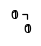

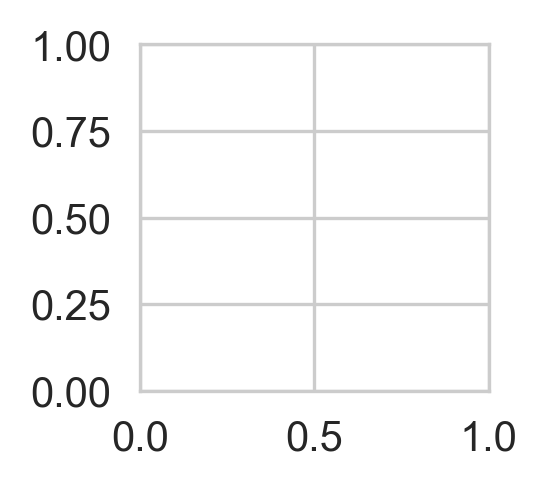

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.subplots(1,1,figsize=(1e-5, 1e-5))
mpl.rcParams['figure.dpi'] = 300
sns.set_style('whitegrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import torch
from torch import nn
import torch.nn.functional as F
import glob
# Here you import other functions and classes
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import encode_batch, AA_KEYS, BL62_VALUES, BL62FREQ_VALUES, BL50, BL50_VALUES
from src.models import NNAlignEFSinglePass, NNAlignEFTwoStage
from src.datasets import NNAlignDataset
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import binomtest
plt.subplots(1,1,figsize=(1.5,1.5))
sns.set_palette('tab10', 6)

In [2]:
train_1 = pd.read_csv('../data/copy_rsync/250130_MHCI_structure_train_900k_fixed_partitions.csv')
test_1 = pd.read_csv('../data/copy_rsync/250213_MHCI_structure_test_79305_REFIXED_OVERLAP.csv')
train_2 = pd.read_csv('../data/copy_rsync/HLA_DR_subsample_all_partitions_922k.csv')
test_2 = pd.read_csv('../data/copy_rsync/HLA_DR_500K_unseen_sequence_test_set.csv')

# features analysis // summaries

In [3]:
def get_mean_feat(x):
    return np.mean([float(z) for z in x.split(',')])
fcols = ['rsa', 'disorder', 'pq3_H', 'pq3_E', 'pq3_C']
for c in fcols:
    train_1[f'mean_{c}'] = train_1[c].apply(get_mean_feat)
    test_1[f'mean_{c}'] = test_1[c].apply(get_mean_feat)
    train_2[f'mean_{c}'] = train_2[c].apply(get_mean_feat)
    test_2[f'mean_{c}'] = test_2[c].apply(get_mean_feat)

In [12]:
train_1

Unnamed: 0       sequence  target         HLA    index       context  \
0                0    VDKFEDNLRCK     0.0  HLA-C03:03  1000366  QTLVDKRCKYFW   
1                1    GPRGSTPGRDP     0.0  HLA-B07:02   325106  SPPGPRRDPEPE   
2                2    RKIHTGERPYK     0.0  HLA-B44:02   796479  IQHRKIPYKCNE   
3                3   ELARVLHDFGLD     0.0  HLA-C14:02   200466  GRCELAGLDGYR   
4                4     VELMGTVAKQ     0.0  HLA-B18:01  1004131  PLTVELAKQLVP   
...            ...            ...     ...         ...      ...           ...   
899995      899995       DEQYACHL     1.0  HLA-B18:01   123467  SQSDEQCHLGCQ   
899996      899996    TGQLADLESER     0.0  HLA-A25:01   950492  SSLTGQSERTQR   
899997      899997  EECPEEVYDPRSL     0.0  HLA-B35:01   174679  EDPEECRSLYER   
899998      899998    DALWSLPLYLE     0.0  HLA-A02:01   114752  SHEDALYLESYL   
899999      899999   YWNSYTEFPNRR     0.0  HLA-A31:01  1108721  NARYWNNRRAHG   

       protein_id  start_position  end_position  \
0          Q8WXR4             810           820   
1          Q8N3X1              21            31   
2          Q99676             577           587   
3          Q8IXA5              94           105   
4          P49765              58            67   
...           ...             ...           ...   
899995     Q9BXS4             108           115   
899996     Q96JN2             251           261   
899997     Q9GZU8              42            54   
899998     O15287             584           594   
899999     Q5TBK1             211           222   

                                                      rsa  \
0       0.0977390706539154,0.5420976877212524,0.146556...   
1       0.742992639541626,0.744196355342865,0.76573359...   
2       0.3654434084892273,0.5380080938339233,0.231812...   
3       0.35480964183807373,0.01041343342512846,0.0171...   
4       0.5336278676986694,0.5611379146575928,0.377546...   
...                                                   ...   
899995  0.6531866192817688,0.4774656891822815,0.232622...   
899996  0.5181927680969238,0.5355244278907776,0.593239...   
899997  0.7678696513175964,0.7689811587333679,0.639403...   
899998  0.6188642978668213,0.3077339828014374,0.228883...   
899999  0.5786603093147278,0.5113202333450317,0.623537...   

                                                    pq3_H  \
0       0.9943457245826721,0.9927472472190857,0.988634...   
1       0.00024157138250302523,0.00024501633015461266,...   
2       0.9681409001350403,0.9739171266555786,0.921805...   
3       0.9989112615585327,0.9982365369796753,0.996191...   
4       0.5713850855827332,0.4496038556098938,0.273989...   
...                                                   ...   
899995  0.23907975852489471,0.5762993693351746,0.88377...   
899996  0.836097776889801,0.7330952286720276,0.7393191...   
899997  0.010170511901378632,0.008469674736261368,0.00...   
899998  0.36730068922042847,0.46381470561027527,0.4345...   
899999  0.004271572455763817,0.004639884456992149,0.00...   

                                                    pq3_E  \
0       0.00019204716954845935,0.0002309745323145762,0...   
1       0.00012490748486015946,0.00011027448636014014,...   
2       0.0014793990412726998,0.0009205076494254172,0....   
3       3.14557328238152e-05,5.253648851066828e-05,8.2...   
4       0.051781248301267624,0.09234899282455444,0.118...   
...                                                   ...   
899995  0.003564578713849187,0.006268617231398821,0.00...   
899996  0.000614520104136318,0.0005737283499911427,0.0...   
899997  0.0033794292248785496,0.0035234116949141026,0....   
899998  0.005854567978531122,0.006869649980217218,0.01...   
899999  0.004871115554124117,0.0037981446366757154,0.0...   

                                                    pq3_C  \
0       0.005462169647216797,0.007021745666861534,0.01...   
1       0.9996335506439209,0.9996447563171387,0.999469...   
2       0.030379697680473328,0.025162311270833015,0.

In [70]:
display(train_1.groupby('target').agg(count=('sequence','count')))
display(test_1.groupby('target').agg(count=('sequence','count')))
display(train_2.groupby('target').agg(count=('sequence','count')))
display(test_2.groupby('target').agg(count=('sequence','count')))

count
target        
0.0     855363
1.0      44637

count
target       
0.0     76334
1.0      2971

count
target        
0.0     829455
1.0      93370

count
target        
0.0     474159
1.0      25841

In [170]:
train_1['len'] = train_1['sequence'].apply(len)
train_1 = train_1.query('len==9')
test_1['len'] = test_1['sequence'].apply(len)
test_1 = test_1.query('len==9')
train_2['len'] = train_2['sequence'].apply(len)
train_2 = train_2.query('len==15')
test_2['len'] = test_2['sequence'].apply(len)
test_2 = test_2.query('len==15')

## Class 1 

In [172]:
train_1.groupby(['target']).count()

Unnamed: 0  sequence     HLA   index  context  protein_id  \
target                                                              
0.0         142160    142160  142160  142160   142160      142160   
1.0          25615     25615   25615   25615    25615       25615   

        start_position  end_position     rsa   pq3_H   pq3_E   pq3_C  \
target                                                                 
0.0             142160        142160  142160  142160  142160  142160   
1.0              25615         25615   25615   25615   25615   25615   

        disorder    fold  mean_rsa  mean_disorder  mean_pq3_H  mean_pq3_E  \
target                                                                      
0.0       142160  142160    142160         142160      142160      142160   
1.0        25615   25615     25615          25615       25615       25615   

        mean_pq3_C     len  
target                      
0.0         142160  142160  
1.0          25615   25615

In [171]:
from scipy.stats import ttest_ind
gb = train_1.drop(columns=fcols).groupby(['target'])[[f'mean_{c}' for c in fcols]].describe()
display(gb.drop(columns=[x for x in gb.columns if x[1] not in ['mean', 'std']]).round(3))
pos = train_1.query('target==1')
neg = train_1.query('target!=1')
for c in fcols:
    alt = 'greater' if pos[f'mean_{c}'].mean()>neg[f'mean_{c}'].mean() else 'less'
    print(c, '\t', ttest_ind(pos[f'mean_{c}'].values, neg[f'mean_{c}'].values, alternative=alt, equal_var=False).pvalue)

mean_rsa        mean_disorder        mean_pq3_H        mean_pq3_E  \
           mean    std          mean    std       mean    std       mean   
target                                                                     
0.0       0.399  0.161         0.259  0.370      0.321  0.357       0.13   
1.0       0.345  0.153         0.172  0.318      0.416  0.379       0.14   

              mean_pq3_C         
          std       mean    std  
target                           
0.0     0.213      0.548  0.328  
1.0     0.227      0.445  0.317

rsa 	 0.0
disorder 	 0.0
pq3_H 	 1.5683476879461551e-292
pq3_E 	 2.0524817822709133e-10
pq3_C 	 0.0


In [173]:
test_1.groupby(['target']).count()

Unnamed: 0.1  Unnamed: 0  sequence    HLA  index  context  protein_id  \
target                                                                          
0.0            12634       12634     12634  12634  12634    12634       12634   
1.0             1561        1561      1561   1561   1561     1561        1561   

        start_position  end_position    rsa  ...  pq3_E  pq3_C  disorder  \
target                                       ...                           
0.0              12634         12634  12634  ...  12634  12634     12634   
1.0               1561          1561   1561  ...   1561   1561      1561   

         fold  mean_rsa  mean_disorder  mean_pq3_H  mean_pq3_E  mean_pq3_C  \
target                                                                       
0.0     12634     12634          12634       12634       12634       12634   
1.0      1561      1561           1561        1561        1561        1561   

          len  
target         
0.0     12634  
1.0      1561  

[2 rows x 21 columns]

In [175]:
from scipy.stats import ttest_ind
gb = test_1.drop(columns=fcols).groupby(['target'])[[f'mean_{c}' for c in fcols]].describe()
display(gb.drop(columns=[x for x in gb.columns if x[1] not in ['mean', 'std']]).round(3))
pos = test_1.query('target==1')
neg = test_1.query('target!=1')
for c in fcols:
    alt = 'greater' if pos[f'mean_{c}'].mean()>neg[f'mean_{c}'].mean() else 'less'
    print(c, '\t', ttest_ind(pos[f'mean_{c}'].values, neg[f'mean_{c}'].values, alternative=alt, equal_var=False).pvalue)

mean_rsa        mean_disorder        mean_pq3_H        mean_pq3_E  \
           mean    std          mean    std       mean    std       mean   
target                                                                     
0.0       0.397  0.160          0.26  0.369      0.324  0.358      0.129   
1.0       0.343  0.151          0.17  0.316      0.411  0.383      0.150   

              mean_pq3_C         
          std       mean    std  
target                           
0.0     0.213      0.547  0.329  
1.0     0.233      0.439  0.315

rsa 	 8.823927237642483e-39
disorder 	 6.663304475778956e-25
pq3_H 	 9.630970681728841e-18
pq3_E 	 0.0004353121255956312
pq3_C 	 5.87744179326986e-36


## Class 2

In [177]:
train_2.groupby(['target']).count()

binding_core  rank_prediction  sequence  sample    MHC  \
target                                                           
0.0            78090            78090     78090   78090  78090   
1.0            17366            17366     17366   17366  17366   

        mhc_reliability  Prot_ID  prot_seq_start    rsa  pq3_H  ...  pq3_C  \
target                                                          ...          
0.0               78090    78090           78090  78090  78090  ...  78090   
1.0               17366    17366           17366  17366  17366  ...  17366   

        disorder  split   fold  mean_rsa  mean_disorder  mean_pq3_H  \
target                                                                
0.0        78090  78090  78090     78090          78090       78090   
1.0        17366  17366  17366     17366          17366       17366   

        mean_pq3_E  mean_pq3_C    len  
target                                 
0.0          78090       78090  78090  
1.0          17366       17366  17366  

[2 rows x 21 columns]

In [178]:
from scipy.stats import ttest_ind
gb = train_2.drop(columns=fcols).groupby(['target'])[[f'mean_{c}' for c in fcols]].describe()
display(gb.drop(columns=[x for x in gb.columns if x[1] not in ['mean', 'std']]).round(3))
pos = train_2.query('target==1')
neg = train_2.query('target!=1')
for c in fcols:
    alt = 'greater' if pos[f'mean_{c}'].mean()>neg[f'mean_{c}'].mean() else 'less'
    print(c, '\t', ttest_ind(pos[f'mean_{c}'].values, neg[f'mean_{c}'].values, alternative=alt, equal_var=False).pvalue)

mean_rsa        mean_disorder        mean_pq3_H        mean_pq3_E  \
           mean    std          mean    std       mean    std       mean   
target                                                                     
0.0       0.395  0.144         0.242  0.353      0.332  0.331      0.131   
1.0       0.351  0.125         0.127  0.273      0.319  0.330      0.223   

              mean_pq3_C         
          std       mean    std  
target                           
0.0     0.193      0.537  0.296  
1.0     0.237      0.459  0.249

rsa 	 0.0
disorder 	 0.0
pq3_H 	 1.558069825252376e-06
pq3_E 	 0.0
pq3_C 	 5.095780472121233e-280


In [179]:
test_2.groupby(['target']).count()

sequence    MHC  Unnamed: 0  binding_core  rank_prediction  sample  \
target                                                                       
0.0        44547  44547       44547         44547            44547   44547   
1.0         4384   4384        4384          4384             4384    4384   

        mhc_reliability  Prot_ID  prot_seq_start    rsa  ...  pq3_C  disorder  \
target                                                   ...                    
0.0               44547    44547           44547  44547  ...  44547     44547   
1.0                4384     4384            4384   4384  ...   4384      4384   

        split   fold  mean_rsa  mean_disorder  mean_pq3_H  mean_pq3_E  \
target                                                                  
0.0     44547  44547     44547          44547       44547       44547   
1.0      4384   4384      4384           4384        4384        4384   

        mean_pq3_C    len  
target                     
0.0          44547  44547  
1.0           4384   4384  

[2 rows x 22 columns]

In [180]:
from scipy.stats import ttest_ind
gb = test_2.drop(columns=fcols).groupby(['target'])[[f'mean_{c}' for c in fcols]].describe()
display(gb.drop(columns=[x for x in gb.columns if x[1] not in ['mean', 'std']]).round(3))

pos = test_2.query('target==1')
neg = test_2.query('target!=1')
for c in fcols:
    alt = 'greater' if pos[f'mean_{c}'].mean()>neg[f'mean_{c}'].mean() else 'less'
    print(c, '\t', ttest_ind(pos[f'mean_{c}'].values, neg[f'mean_{c}'].values, alternative=alt, equal_var=False).pvalue)

mean_rsa        mean_disorder        mean_pq3_H        mean_pq3_E  \
           mean    std          mean    std       mean    std       mean   
target                                                                     
0.0       0.394  0.145         0.242  0.353      0.332  0.332      0.131   
1.0       0.361  0.127         0.145  0.289      0.333  0.335      0.201   

              mean_pq3_C         
          std       mean    std  
target                           
0.0     0.193      0.536  0.297  
1.0     0.233      0.466  0.258

rsa 	 3.7928957596975534e-56
disorder 	 1.3507397038632694e-91
pq3_H 	 0.49098767393111714
pq3_E 	 9.296744705853118e-80
pq3_C 	 8.248758162029314e-63


# results

In [4]:
DD='../output/250218_StructAll_results_REREDONE/'
%ls ../output/250218_StructAll_results_REREDONE| head -n 3

HLA-DR_KCV.png
HLA-DR_KCV_pvals.csv
HLA-DR_Test.png


In [5]:
def get_name(fn):
    if 'ensemble_test' in fn:
        return fn.split('ensemble_test_')[1].replace('.csv','').split('_per_HLA')[0]
    elif 'valid' in fn:
        return fn.split('valid_')[1].replace('.csv','').split('_per_HLA')[0]

def read_result(fn):
    name = get_name(fn)
    return pd.read_csv(fn).assign(model=name)
    
def get_binompval(k,n, alt="greater"):
    return binomtest(k,n, alternative=alt).pvalue
    
def do_binom(df):
    bs = df.query('model=="baseline"').set_index('MHC')[['auc','auc01','ppv']]
    n = len(bs)
    results = []
    for model in [x for x in df.model.unique() if x !="baseline"]:
        tmp = df.query('model==@model').set_index('MHC')
        ks = (tmp[['auc','auc01','ppv']] > bs).sum()
        results.append(pd.DataFrame(ks.apply(get_binompval, n=n), columns=[model]).T)
    return pd.concat(results).rename(columns={k:f'{k}_pval' for k in ['auc','auc01','ppv']}).rename(index={'baseline':'Baseline', 'mean_struct':'Mean',
                 'pos_struct':'All', 'rsa_only':'RSA', 
                 'disorder_only':'Disorder', 'pq3_only':'pq3'}).loc[['Mean', 'All', 'RSA', 'Disorder', 'pq3']]

In [6]:
def make_box(df, figsize=(12,7), saturation=0.8, alpha=0.8, 
             width=0.8, size=1, swarm=False, fill=True, fn=None, od='../output/250218_StructAll_results_REREDONE/'):
    # df stuff
    fs = 16
    fw = 'semibold'
    pvals = do_binom(df)
    sigs = pvals.applymap(lambda x: 'ns' if x > 0.05 else 
                                    '****' if x <= 0.0001 else 
                                    '***' if x <= 0.001 else 
                                    '**' if x <= 0.01 else 
                                    '*')
    sigs = pd.concat([pd.DataFrame({'auc_pval':'None', 'auc01_pval':'None', 'ppv_pval':'None'}, 
                                   index=['baseline']),
                     sigs])
    tmp = df.melt(id_vars=['model'], value_vars=['auc','auc01','ppv'])
    tmp.replace({'baseline':'Baseline', 'mean_struct':'Mean',
                 'pos_struct':'All', 'rsa_only':'RSA', 
                 'disorder_only':'Disorder', 'pq3_only':'pq3',
                 'auc':'AUC', 'auc01':'AUC01', 'ppv':'PPV'}, inplace=True)
    # Make boxplot
    palette=sns.color_palette('tab10', 6)
    hue_order = ['Baseline']+list(pvals.index)#,'Mean','All','RSA', 'Disorder', 'pq3']
    fig, ax = plt.subplots(1,1, figsize=figsize)

    ax.set_yticks(np.arange(0., 1.1, 0.1))
    ax.set_ylim([0.15, 1.05])
    sns.boxplot(tmp, y='value', x='variable', hue='model', ax=ax, saturation=saturation,
                hue_order=hue_order, width=width, fill=fill, dodge=True, gap=0.1)

    for i,p in enumerate([x for x in ax.patches if type(x).__name__=='PathPatch']):
        p.set_alpha(alpha)

    # Make Swarm
    if swarm:
        sns.swarmplot(tmp, y='value', x='variable', hue='model', ax=ax, dodge=True, size=size,
                      alpha=min(1,alpha*2), legend=False)

    # Significance levels
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines = ax.get_lines()
    lines_per_box = 6 if fill else 7
    for i, median in enumerate(lines[4:len(lines):lines_per_box]):
        if i in [0, 1, 2]:continue#0, 0+6, 0+12]: continue
        else:
            x, y = (data.mean() for data in median.get_data())
            # updating seaborn changed the order in which the fucking boxes are made
            # now the index is [0, 1, 2] = [hue_0_x0, hue0_x1, hue0_x2]
            ax.text(x, y=1.025,s=sigs.T.melt().iloc[i,1], 
                    horizontalalignment='center', verticalalignment='center',
                    fontweight=fw, fontsize=fs)

    # Formatting
    ax.set_xlabel('Metric', fontweight=fw, fontsize=fs)
    ax.set_ylabel('Value', fontweight=fw, fontsize=fs)
    ax.set_yticklabels(ax.get_yticklabels(), fontweight=fw, fontsize=fs)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight=fw, fontsize=fs)
    ax.legend(title=None,prop={'weight':fw,'size':fs}, loc='lower left')

    ax.grid(True, axis='y', which='major', linestyle='-', linewidth=0.7)
    ax.grid(False, which='minor')
    if fn is not None:
        fig.savefig(f'{od}{fn}.png', dpi=300, bbox_inches='tight')
        pvals.to_csv(f'{od}{fn}_pvals.csv')
    return pvals, sigs, ax

In [5]:
alpha=0.7
size=2.5
figsize=(18,10)
width=.8
saturation=1
swarm=True
fill=False
fn=None
mhc1_kcv_pvs, mhc1_kcv_sgs,_ = make_box(mhc1_kcv, figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc1_kcv_sgs)

NameError: name 'mhc1_kcv' is not defined

## Class I

### KCV (I)

auc_pval  auc01_pval  ppv_pval
Mean      1.000000    1.000000  1.000000
All       0.994968    0.162239  0.578051
RSA       0.083722    0.083722  0.942766
Disorder  0.500000    0.162239  0.500000
pq3       0.024117    0.002768  0.975883

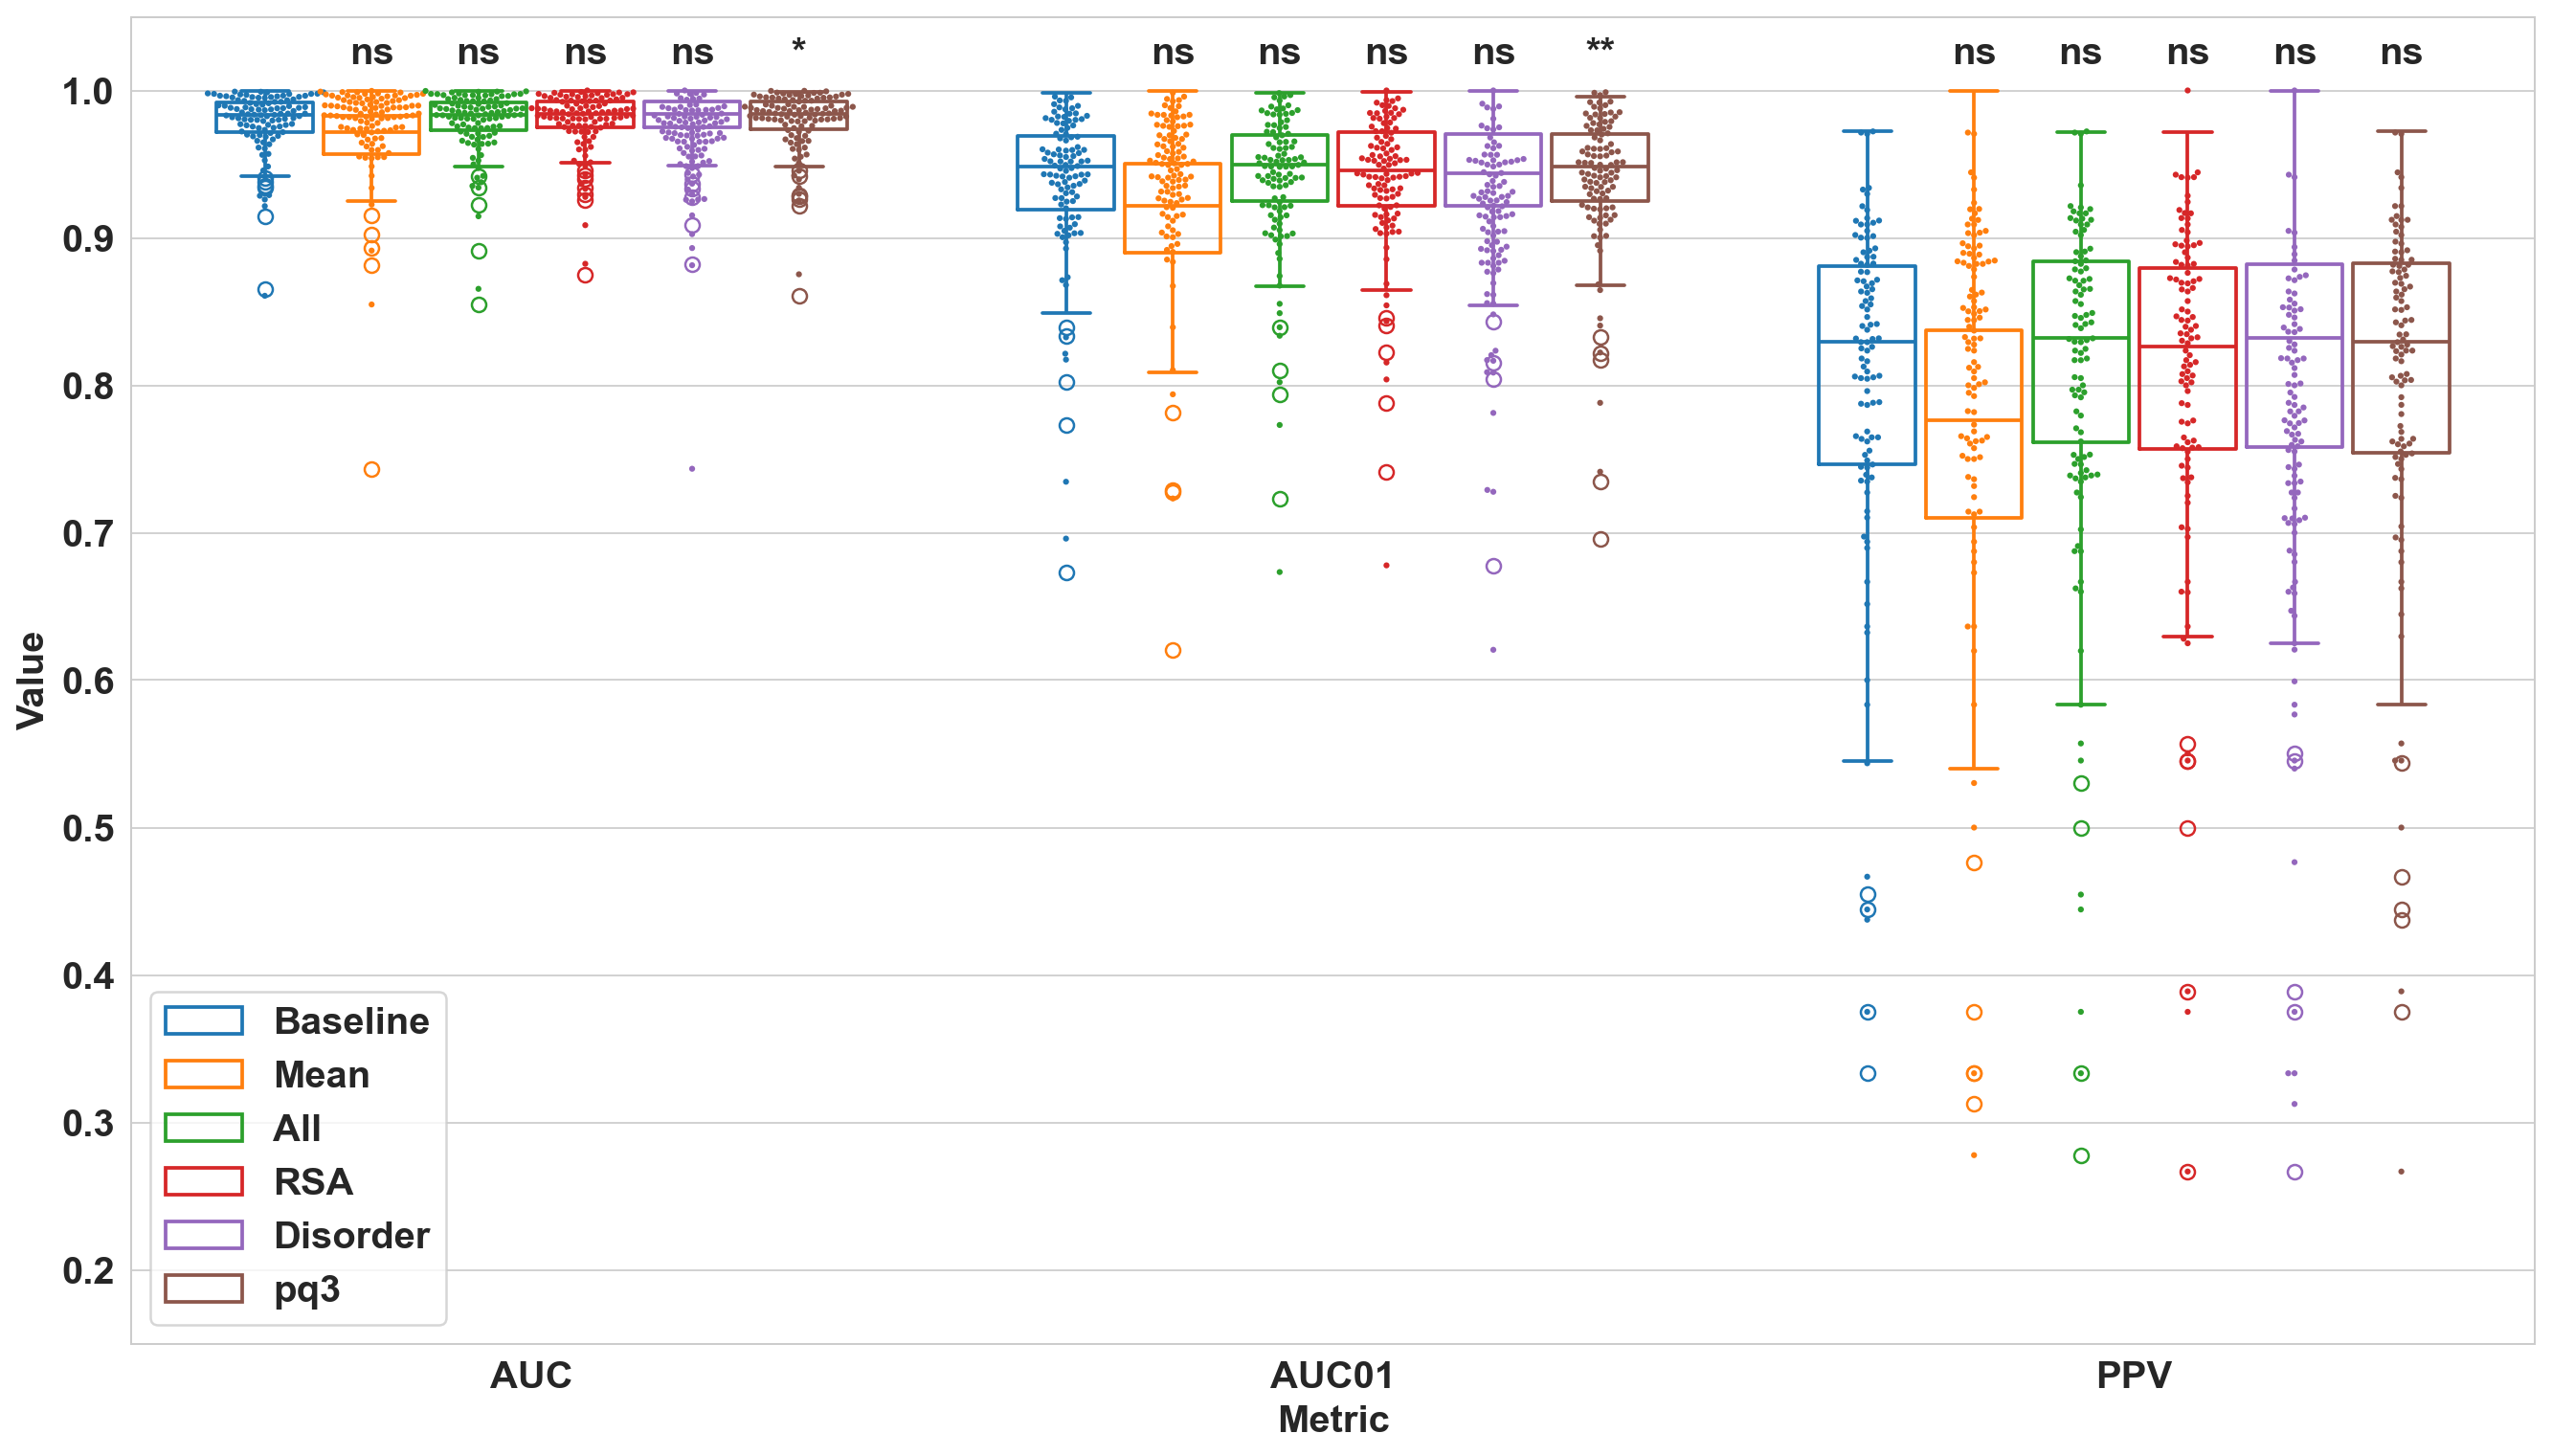

In [6]:
files = glob.glob(f'{DD}*MHCI_valid*')
fn='MHC1_KCV'
mhc1_kcv = pd.concat([read_result(f) for f in files])
mhc1_kcv_pvs, mhc1_kcv_sgs,_ = make_box(mhc1_kcv, figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc1_kcv_pvs)

### Test set (I)

auc_pval  auc01_pval  ppv_pval
Mean      1.000000    1.000000  1.000000
All       0.087643    0.054428  0.990671
RSA       0.866094    0.356115  0.999995
Disorder  0.548921    0.730709  0.999995
pq3       0.945572    0.730709  0.982209

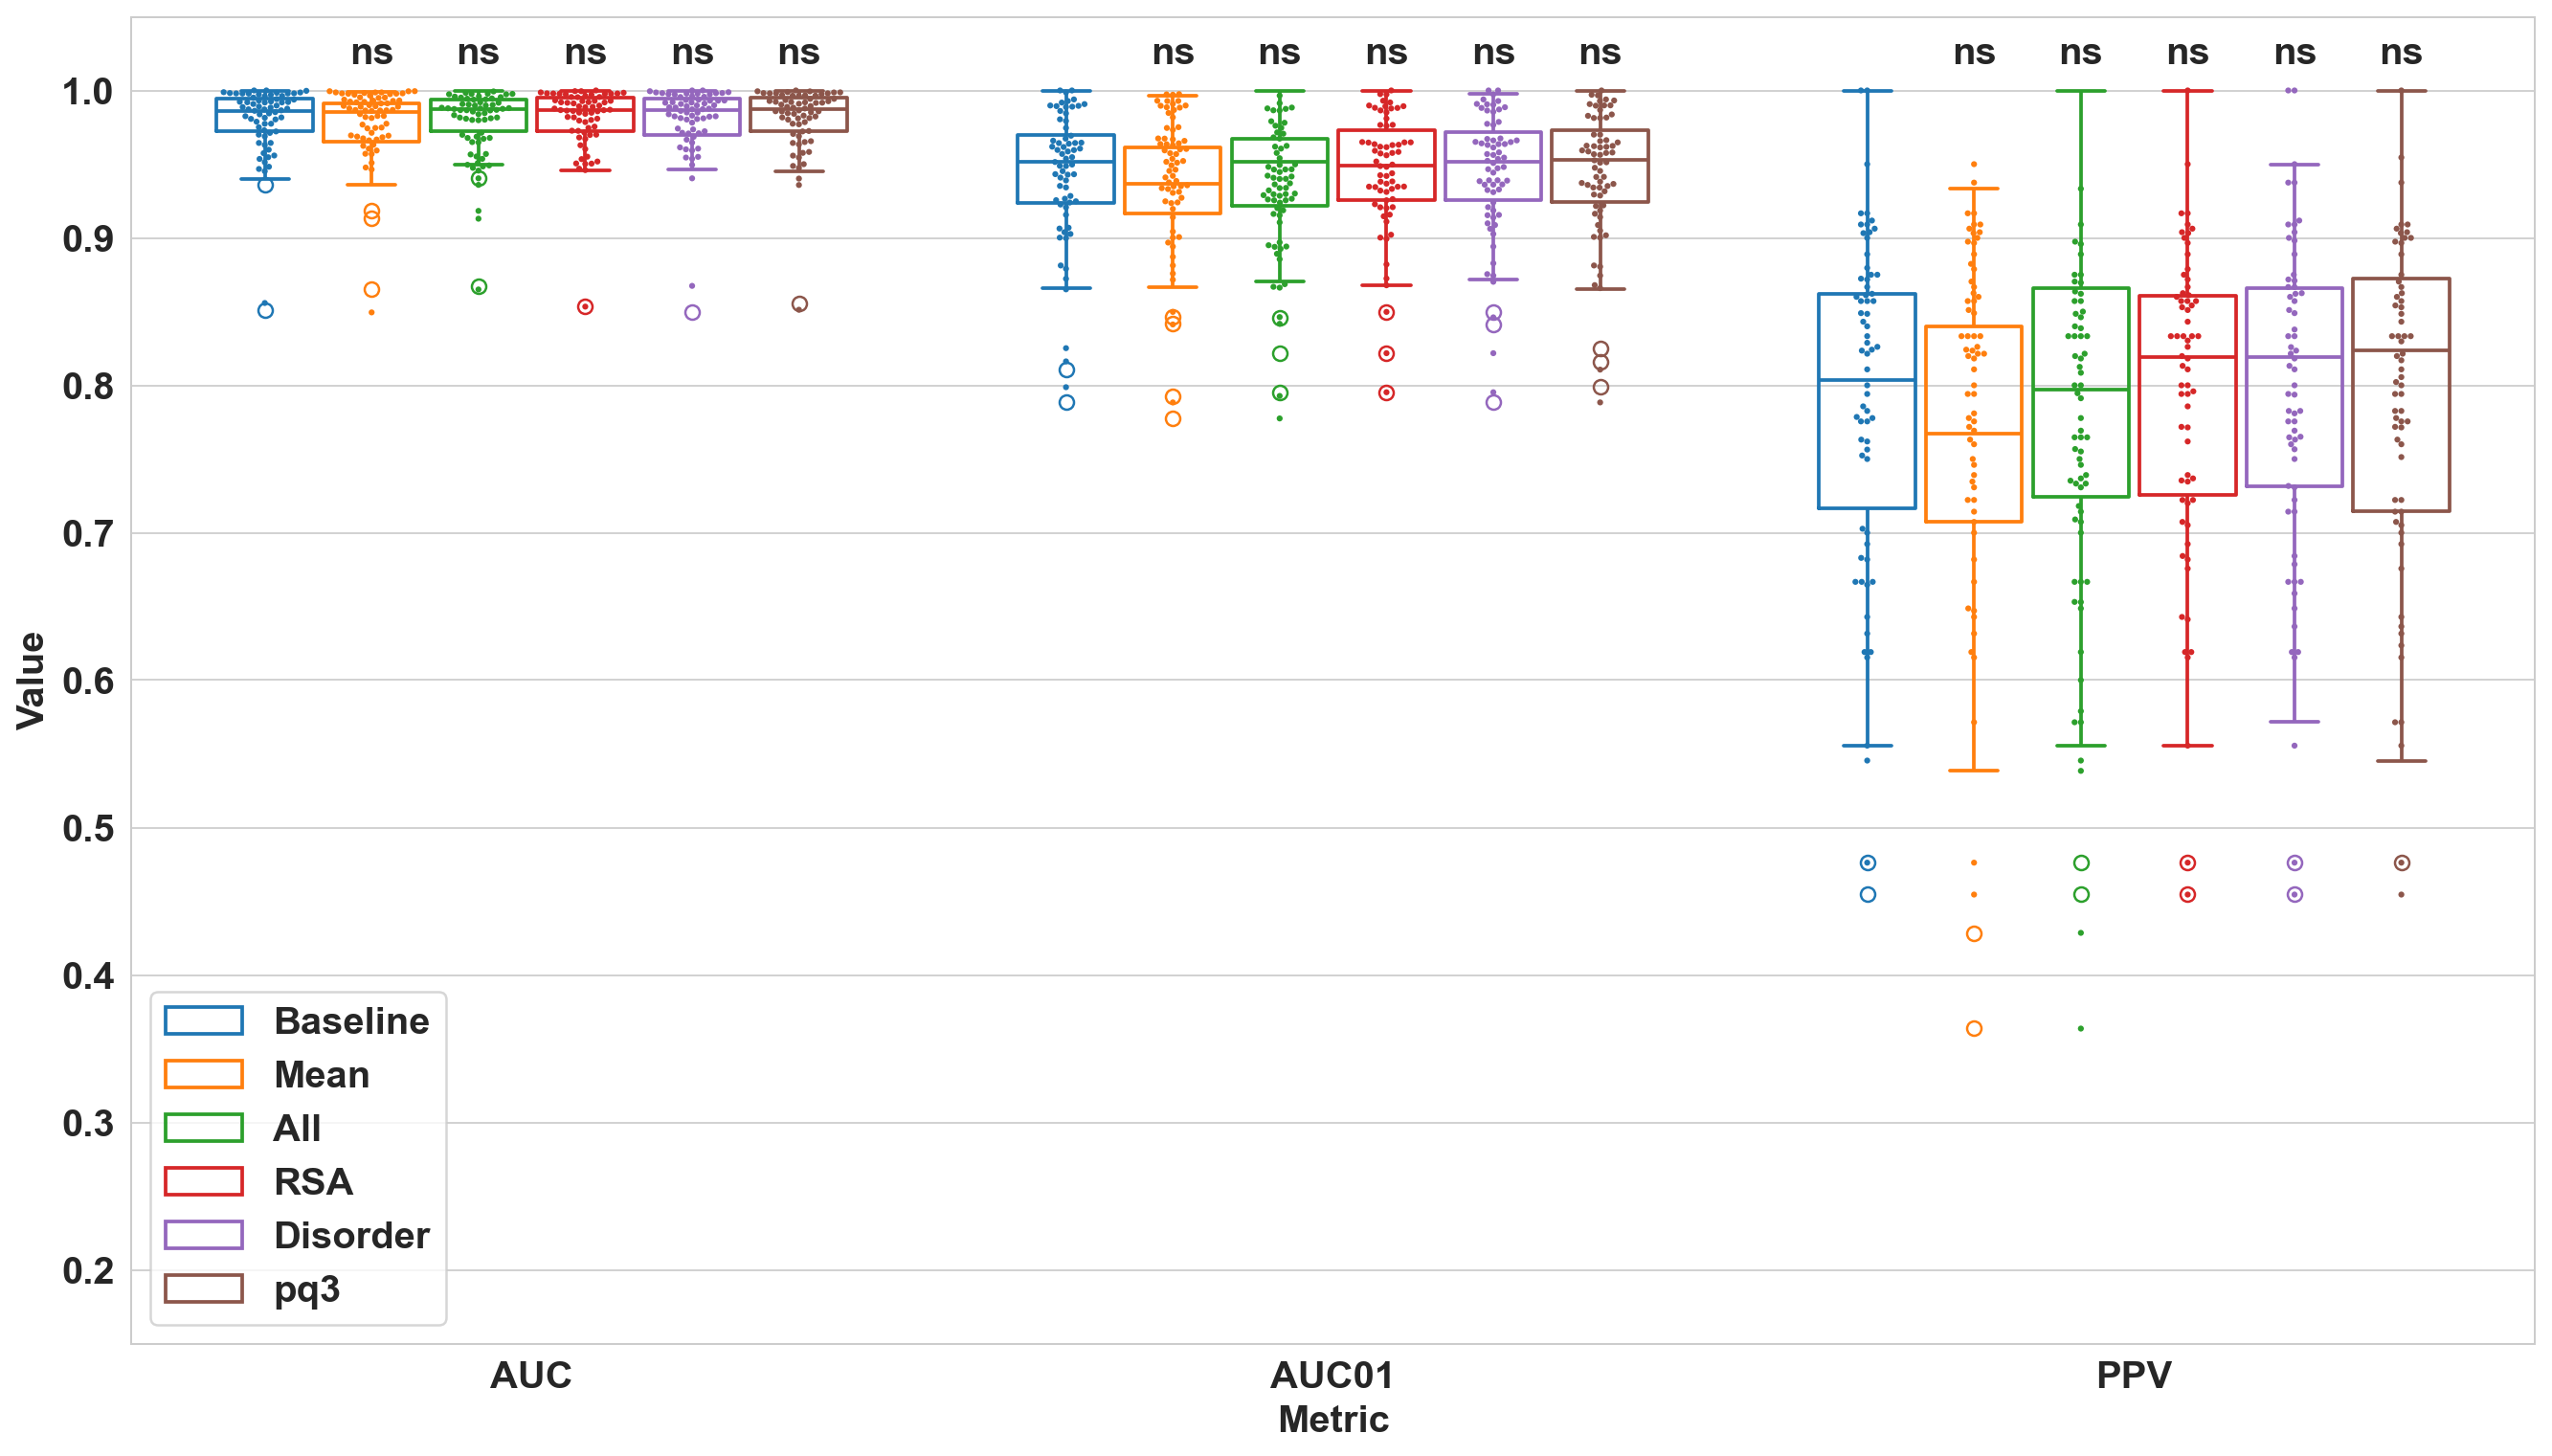

In [8]:
files = glob.glob(f'{DD}*MHCI_ensemble_test*')
fn='MHC1_Test'
mhc1_test = pd.concat([read_result(f) for f in files])
do_binom(mhc1_test)
mhc1_test_pvs, mhc1_test_sgs,_ = make_box(mhc1_test,  figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc1_test_pvs)

## Class II

### KCV (II)

In [14]:
glob.glob(f'{DD}*DR_valid*.csv')

['../output/250218_StructAll_results_REREDONE/HLA-DR_valid_mean_struct_per_HLA_all_partitions_concat.csv',
 '../output/250218_StructAll_results_REREDONE/HLA-DR_valid_baseline_per_HLA_all_partitions_concat.csv',
 '../output/250218_StructAll_results_REREDONE/HLA-DR_valid_pq3_only_per_HLA_all_partitions_concat.csv',
 '../output/250218_StructAll_results_REREDONE/HLA-DR_valid_rsa_only_per_HLA_all_partitions_concat.csv',
 '../output/250218_StructAll_results_REREDONE/HLA-DR_valid_disorder_only_per_HLA_all_partitions_concat.csv',
 '../output/250218_StructAll_results_REREDONE/HLA-DR_valid_pos_struct_per_HLA_all_partitions_concat.csv']

auc_pval  auc01_pval  ppv_pval
Mean      1.000000    1.000000  1.000000
All       0.000008    0.000008  0.003958
RSA       0.044215    0.044215  0.082075
Disorder  0.044215    0.321984  0.139978
pq3       0.001444    0.021779  0.021779

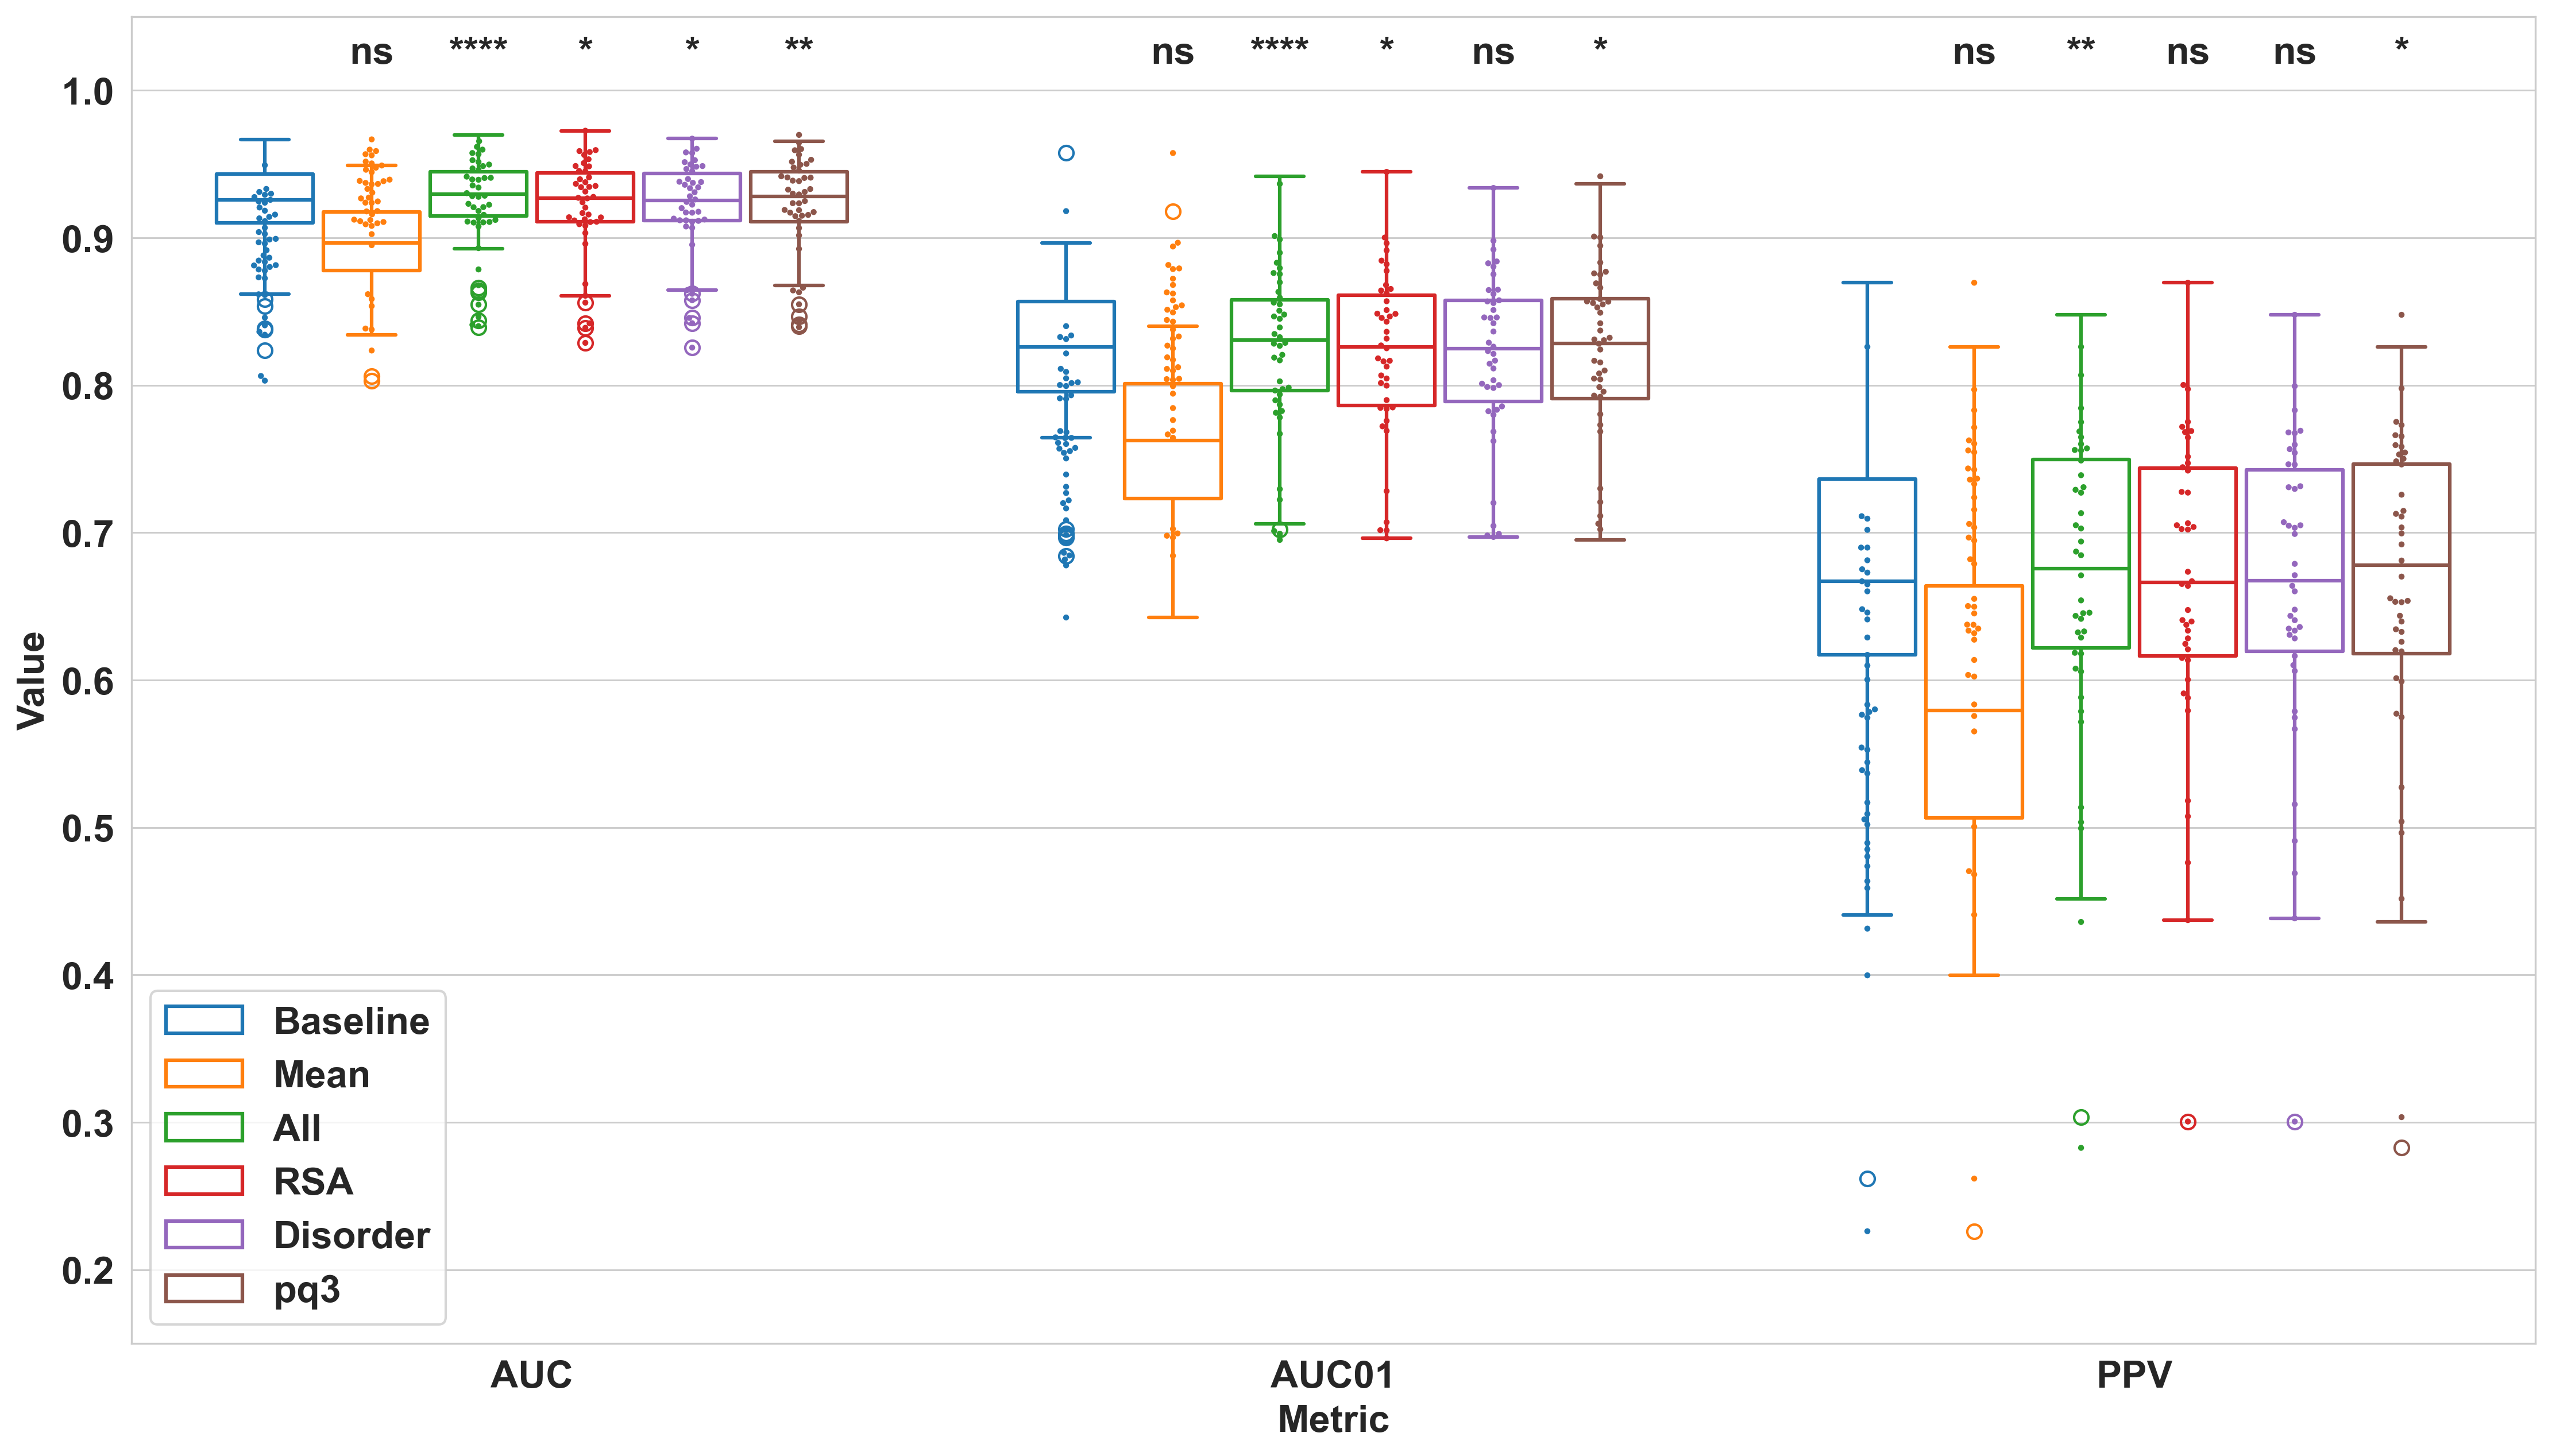

In [742]:
files = glob.glob(f'{DD}*DR_valid*.csv')
fn='HLA-DR_KCV'
mhc2_kcv = pd.concat([read_result(f) for f in files])
mhc2_kcv_pvs, mhc2_kcv_sgs,_ = make_box(mhc2_kcv,  figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc2_kcv_pvs)

### Test set (II)

auc_pval  auc01_pval  ppv_pval
Mean      0.894488    1.000000  1.000000
All       0.058638    0.029792  0.029792
RSA       0.970208    0.733645  0.500000
Disorder  1.000000    1.000000  1.000000
pq3       0.266355    0.733645  0.500000

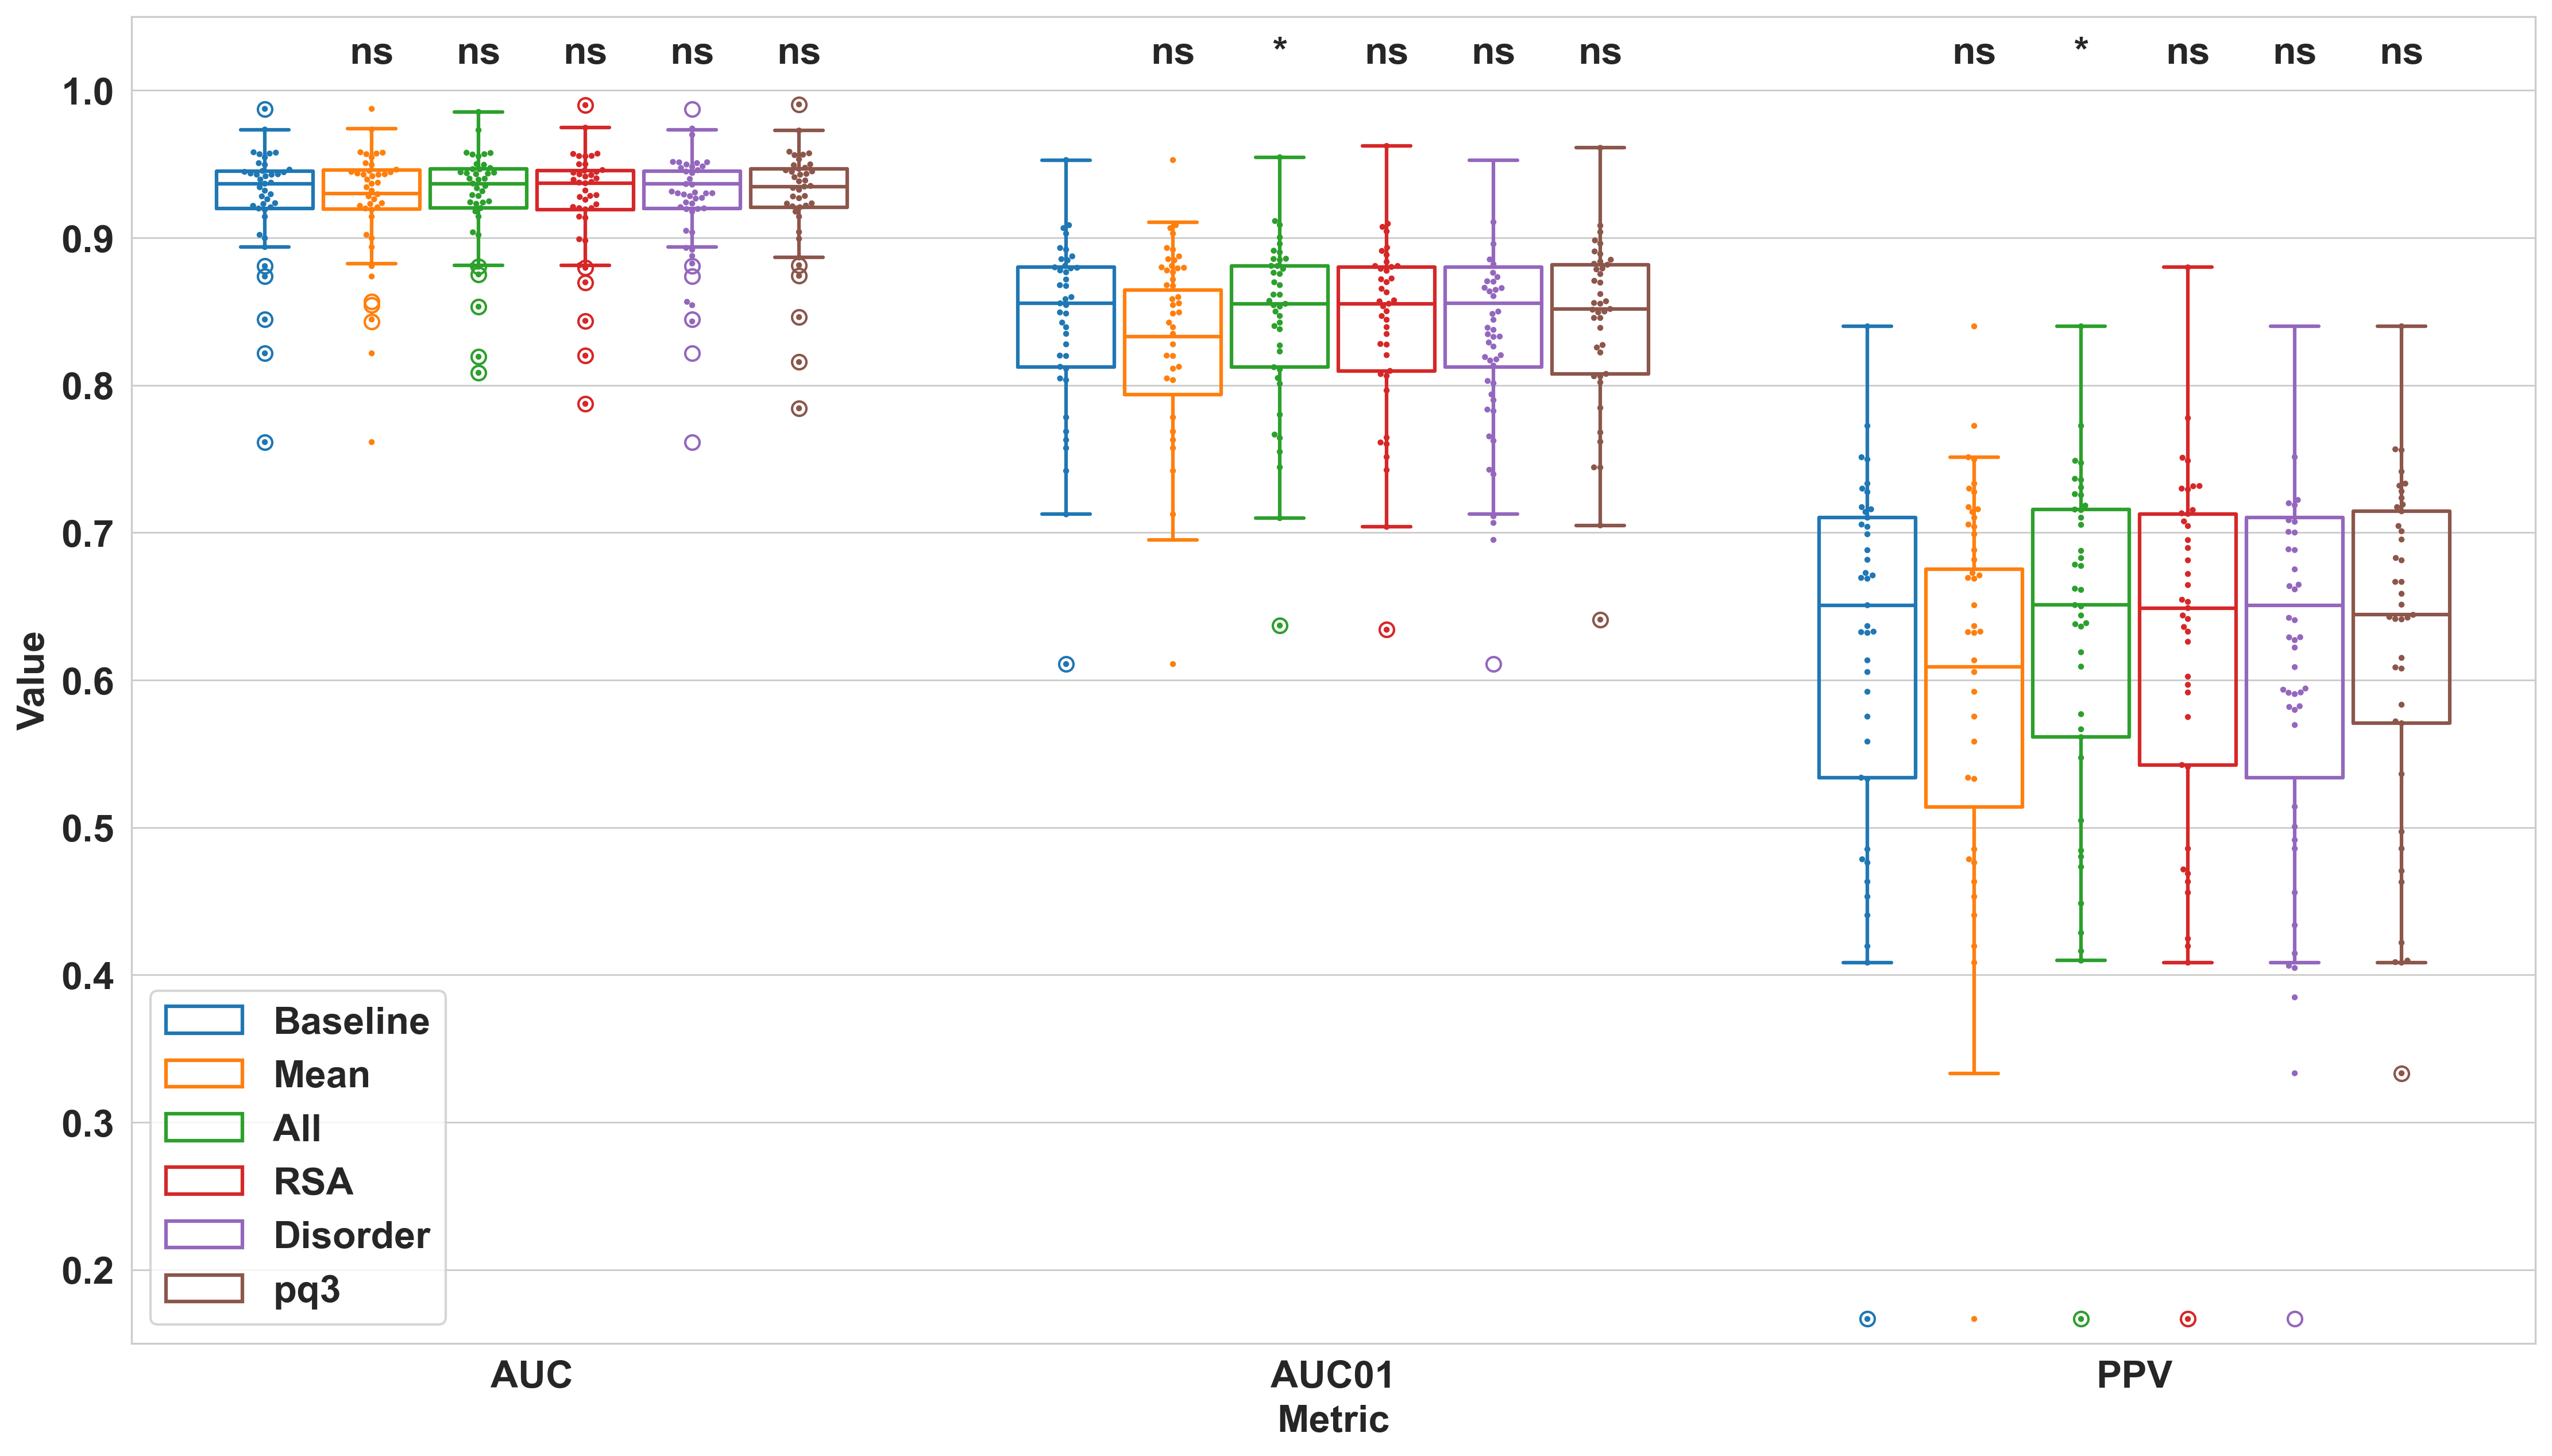

In [741]:
sns.set_palette('tab10', 6)
files = glob.glob(f'{DD}*DR_ensemble_test*.csv')
mhc2_test = pd.concat([read_result(f) for f in files])
fn='HLA-DR_Test'
do_binom(mhc2_test)
mhc2_test_pvs, mhc2_test_sgs, _ = make_box(mhc2_test,  figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc2_test_pvs)

## pvals and enrichment stuff

In [750]:
a=mhc2_kcv.query('model=="baseline"').set_index('MHC')[['auc', 'auc01', 'ppv']]
b=mhc2_kcv.query('model=="pos_struct"').set_index('MHC')[['auc', 'auc01', 'ppv']]
(b>a).query('auc01')

auc  auc01    ppv
MHC                           
DRB1_0101   True   True   True
DRB1_0102   True   True   True
DRB1_0103   True   True   True
DRB1_0301   True   True   True
DRB1_0302   True   True   True
DRB1_0401   True   True   True
DRB1_0403  False   True  False
DRB1_0404   True   True  False
DRB1_0407   True   True  False
DRB1_0408   True   True  False
DRB1_0701   True   True   True
DRB1_0801   True   True   True
DRB1_0802   True   True   True
DRB1_0803   True   True   True
DRB1_0804   True   True   True
DRB1_0901   True   True   True
DRB1_1101   True   True   True
DRB1_1102  False   True   True
DRB1_1104   True   True   True
DRB1_1301   True   True   True
DRB1_1302   True   True   True
DRB1_1303   True   True  False
DRB1_1401   True   True   True
DRB1_1402   True   True   True
DRB1_1454   True   True   True
DRB1_1501   True   True   True
DRB1_1502   True   True   True
DRB1_1503  False   True   True
DRB1_1601   True   True   True
DRB3_0101   True   True   True
DRB3_0202   True   True   True
DRB3_0301   True   True  False
DRB4_0101   True   True   True
DRB5_0101   True   True   True
DRB5_0202   True   True   True

In [81]:
# get enriched list (for Delta AUC01 > threshold) vs non enriched list
(b-a).query('auc01>2.5e-3').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_validset_delta_AUC01_2.5e-3_allele_list.txt', header=False, index=False)
(b>a).query('not auc01').reset_index()['MHC'].to_csv(f'{DD}NOT_ENRICHED_HLA_DR_validset_allele_list.txt', header=False, index=False)
(b>a).query('auc01').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_validset_all_delta_AUC01_allele_list.txt', header=False, index=False)

In [191]:
binomtest(26,41, alternative="greater")

BinomTestResult(k=26, n=41, alternative='greater', statistic=0.6341463414634146, pvalue=0.05863760297870613)

In [196]:
(d>c).apply(lambda x: binomtest(x.sum(), x.count(), alternative="greater").pvalue)

auc      0.058638
auc01    0.029792
ppv      0.029792
dtype: float64

In [743]:
c=mhc2_test.query('model=="baseline"').set_index('MHC')[['auc', 'auc01', 'ppv']]
d=mhc2_test.query('model=="pos_struct"').set_index('MHC')[['auc', 'auc01', 'ppv']]
(d>c).query('auc01')

auc  auc01    ppv
MHC                           
DRB1_0101   True   True   True
DRB1_0102  False   True   True
DRB1_0103  False   True  False
DRB1_0301   True   True   True
DRB1_0401   True   True   True
DRB1_0403   True   True   True
DRB1_0404   True   True   True
DRB1_0407   True   True   True
DRB1_0701   True   True   True
DRB1_0801   True   True   True
DRB1_0804   True   True   True
DRB1_0901   True   True   True
DRB1_1101   True   True  False
DRB1_1102   True   True  False
DRB1_1104  False   True   True
DRB1_1301   True   True   True
DRB1_1302   True   True   True
DRB1_1401   True   True   True
DRB1_1402   True   True  False
DRB1_1454  False   True  False
DRB1_1501   True   True   True
DRB3_0101   True   True   True
DRB3_0202  False   True   True
DRB3_0301   True   True   True
DRB4_0101  False   True   True
DRB5_0101   True   True   True
DRB5_0202  False   True  False

In [83]:
(d>c).query('auc01')

auc  auc01    ppv
MHC                           
DRB1_0101   True   True   True
DRB1_0102  False   True   True
DRB1_0103  False   True  False
DRB1_0301   True   True   True
DRB1_0401   True   True   True
DRB1_0403   True   True   True
DRB1_0404   True   True   True
DRB1_0407   True   True   True
DRB1_0701   True   True   True
DRB1_0801   True   True   True
DRB1_0804   True   True   True
DRB1_0901   True   True   True
DRB1_1101   True   True  False
DRB1_1102   True   True  False
DRB1_1104  False   True   True
DRB1_1301   True   True   True
DRB1_1302   True   True   True
DRB1_1401   True   True   True
DRB1_1402   True   True  False
DRB1_1454  False   True  False
DRB1_1501   True   True   True
DRB3_0101   True   True   True
DRB3_0202  False   True   True
DRB3_0301   True   True   True
DRB4_0101  False   True   True
DRB5_0101   True   True   True
DRB5_0202  False   True  False

In [758]:
test_alleles = (d-c).query('auc01>2.5e-3').index
kcv_alleles = (b-a).query('auc01>2.5e-3').index

len(test_alleles.join(kcv_alleles, how='inner')), len(test_alleles)

(14, 15)

In [763]:
[x for x in test_alleles if x  not in kcv_alleles]

['DRB1_0403']

In [759]:
test_alleles.difference(kcv_alleles)

Index(['DRB1_0403'], dtype='object', name='MHC')

In [752]:
len((d-c).query('auc01>2.5e-3')), len((d-c).query('auc01<-2.5e-3'))

(15, 8)

In [749]:
(d-c).query('auc01<-2.5e-3')

auc    auc01      ppv
MHC                                 
DRB1_0302 -0.01256 -0.00250  0.03126
DRB1_0408 -0.00037 -0.00252  0.00000
DRB1_0802  0.00172 -0.00433 -0.00975
DRB1_0803  0.00867 -0.00256 -0.01191
DRB1_1001 -0.00059 -0.00549 -0.00813
DRB1_1201 -0.00377 -0.00586 -0.03637
DRB1_1502 -0.00111 -0.01018  0.00834
DRB1_1601 -0.00154 -0.00417  0.00719

In [751]:
(b-a).query('auc01<-2.5e-3')

auc    auc01      ppv
MHC                                 
DRB1_0305  0.00305 -0.01579 -0.02174
DRB1_0405 -0.00035 -0.00574 -0.01308
DRB1_1001 -0.00029 -0.00869 -0.01537
DRB1_1202 -0.00411 -0.01395 -0.02614

In [220]:
len((d>c).query('auc01'))

27

In [84]:
# get enriched list (for Delta AUC01 > threshold) vs non enriched list
(d-c).query('auc01>2.5e-3').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_testset_delta_AUC01_2.5e-3_allele_list.txt', header=False, index=False)
(d>c).query('not auc01').reset_index()['MHC'].to_csv(f'{DD}NOT_ENRICHED_HLA_DR_testset_allele_list.txt', header=False, index=False)
(d>c).query('auc01').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_testset_all_delta_AUC01_allele_list.txt', header=False, index=False)

# ?

In [79]:
%wc -l $DD

UsageError: Line magic function `%wc` not found.


In [7]:
%ls $DD | grep enrich

enriched_HLA_DR_testset_all_delta_AUC01_allele_list.txt
enriched_HLA_DR_testset_delta_AUC01_2.5e-3_allele_list.txt
enriched_HLA_DR_validset_all_delta_AUC01_allele_list.txt
enriched_HLA_DR_validset_delta_AUC01_2.5e-3_allele_list.txt


In [8]:
enrich_test = pd.read_csv(f'{DD}enriched_HLA_DR_testset_delta_AUC01_2.5e-3_allele_list.txt')
enrich_kcv = pd.read_csv(f'{DD}enriched_HLA_DR_validset_delta_AUC01_2.5e-3_allele_list.txt')

In [78]:
%cat $DD/enriched_HLA_DR_validset_all_delta_AUC01_allele_list.txt



DRB1_0101
DRB1_0102
DRB1_0103
DRB1_0301
DRB1_0302
DRB1_0401
DRB1_0403
DRB1_0404
DRB1_0407
DRB1_0408
DRB1_0701
DRB1_0801
DRB1_0802
DRB1_0803
DRB1_0804
DRB1_0901
DRB1_1101
DRB1_1102
DRB1_1104
DRB1_1301
DRB1_1302
DRB1_1303
DRB1_1401
DRB1_1402
DRB1_1454
DRB1_1501
DRB1_1502
DRB1_1503
DRB1_1601
DRB3_0101
DRB3_0202
DRB3_0301
DRB4_0101
DRB5_0101
DRB5_0202


In [76]:
enrich_kcv

DRB1_0101
0   DRB1_0102
1   DRB1_0103
2   DRB1_0301
3   DRB1_0302
4   DRB1_0401
5   DRB1_0407
6   DRB1_0408
7   DRB1_0701
8   DRB1_0801
9   DRB1_0802
10  DRB1_0803
11  DRB1_0804
12  DRB1_0901
13  DRB1_1101
14  DRB1_1102
15  DRB1_1104
16  DRB1_1301
17  DRB1_1302
18  DRB1_1401
19  DRB1_1402
20  DRB1_1454
21  DRB1_1501
22  DRB1_1502
23  DRB1_1601
24  DRB3_0101
25  DRB3_0202
26  DRB5_0101
27  DRB5_0202

In [9]:
%ls $DD/features

HLA-DR_aacomp_kcv_out_merged.csv     do_get_aa_composition.out_ratio
HLA-DR_aacomp_test_out_merged.csv    do_get_aa_composition_val*
do_get_aa_composition*               do_get_aa_composition_val.out
do_get_aa_composition.out            do_get_aa_composition_val.out_ratio


In [10]:
test_ratios = pd.read_csv(f'{DD}features/do_get_aa_composition.out_ratio', sep=' ', header=None, names=['AA', 'log(E_nE)'])
test_raw = pd.read_csv(f'{DD}features/do_get_aa_composition.out', sep=' ',header=None, names=['AA', 'n_E', 'freq_E', 'n_total_E', 'n_nE', 'freq_nE', 'n_total_nE'])
kcv_ratios = pd.read_csv(f'{DD}features/do_get_aa_composition_val.out_ratio', sep=' ', header=None, names=['AA', 'log(E_nE)'])
kcv_raw = pd.read_csv(f'{DD}features/do_get_aa_composition_val.out', sep=' ', header=None, names=['AA', 'n_E', 'freq_E', 'n_total_E', 'n_nE', 'freq_nE', 'n_total_nE'])
test_raw['n_total_E'] = test_raw['n_total_E'].apply(lambda x: int(x.split('\t')[0]))
kcv_raw['n_total_E'] = kcv_raw['n_total_E'].apply(lambda x: int(x.split('\t')[0]))

dr_test=test_raw.merge(test_ratios, left_on=['AA'], right_on=['AA'])
dr_kcv=kcv_raw.merge(kcv_ratios, left_on=['AA'], right_on=['AA'])

In [111]:
dr_test.to_csv(f'{DD}/features/HLA-DR_aacomp_test_out_merged.csv')
dr_kcv.to_csv(f'{DD}/features/HLA-DR_aacomp_kcv_out_merged.csv')

In [99]:
dr_test

AA   n_E    freq_E  n_total_E  n_nE   freq_nE  n_total_nE  log(E_nE)
0   A  2859  0.095300      30000  2338  0.083500       28000   0.132183
1   C    23  0.000767      30000    21  0.000750       28000   0.021979
2   D  1544  0.051467      30000  1813  0.064750       28000  -0.229599
3   E   703  0.023433      30000  1252  0.044714       28000  -0.646135
4   F  1932  0.064400      30000  2230  0.079643       28000  -0.212439
5   G  1246  0.041533      30000  1040  0.037143       28000   0.111723
6   H   304  0.010133      30000   178  0.006357       28000   0.466248
7   I  3912  0.130400      30000  3474  0.124071       28000   0.049753
8   K  2115  0.070500      30000  1143  0.040821       28000   0.546406
9   L  2757  0.091900      30000  3324  0.118714       28000  -0.256016
10  M   460  0.015333      30000   555  0.019821       28000  -0.256735
11  N  1255  0.041833      30000  1295  0.046250       28000  -0.100369
12  P   254  0.008467      30000   288  0.010286       28000  -0.194617
13  Q   711  0.023700      30000   809  0.028893       28000  -0.198121
14  R  1874  0.062467      30000   735  0.026250       28000   0.866968
15  S  1905  0.063500      30000  1527  0.054536       28000   0.152184
16  T  1313  0.043767      30000  1108  0.039571       28000   0.100767
17  V  2850  0.095000      30000  2357  0.084179       28000   0.120936
18  W   196  0.006533      30000   220  0.007857       28000  -0.184506
19  Y  1787  0.059567      30000  2293  0.081893       28000  -0.318316

In [119]:
def get_chi2_p(a, b, n=30000, m=28000):
    contig = [[a, n-a],
              [b, m-b]]
    return chi2_contingency(contig).pvalue

def get_z_p(a,b,n=30000,m=28000):
    se=np.sqrt(((1/a)-(1/n) + (1/b) - (1/m)))
    pa=a/n
    pb=b/m
    z = np.log(pa/pb)/se
    alt='greater' if pa>=pb else 'less'
    z_p = 1 - norm.cdf(z) if pa>=pb else norm.cdf(z)
    return z_p

dr_kcv['chi2_p'] = dr_kcv.apply(lambda x: get_chi2_p(a=x['n_E'], b=x['n_nE'], n=x['n_total_E'], m=x['n_total_nE']), axis=1)
dr_kcv['z_p'] = dr_kcv.apply(lambda x: get_z_p(a=x['n_E'], b=x['n_nE'], n=x['n_total_E'], m=x['n_total_nE']), axis=1)
dr_test['chi2_p'] = dr_test.apply(lambda x: get_chi2_p(a=x['n_E'], b=x['n_nE'], n=x['n_total_E'], m=x['n_total_nE']), axis=1)
dr_test['z_p'] = dr_test.apply(lambda x: get_z_p(a=x['n_E'], b=x['n_nE'], n=x['n_total_E'], m=x['n_total_nE']), axis=1)

In [128]:
def get_sig(p):
    sig = '****' if p<0.0001 else\
          '***' if p<0.001 else \
          '**' if p<0.01 else \
          '*' if p<0.05 else \
          'ns'
    return sig

In [129]:
dr_kcv['chi2_sig'] = dr_kcv['chi2_p'].apply(get_sig)
dr_kcv['z_sig'] = dr_kcv['z_p'].apply(get_sig)
dr_test['chi2_sig'] = dr_test['chi2_p'].apply(get_sig)
dr_test['z_sig'] = dr_test['z_p'].apply(get_sig)

In [130]:
dr_test

AA   n_E    freq_E  n_total_E  n_nE   freq_nE  n_total_nE  log(E_nE)  \
0   A  2859  0.095300      30000  2338  0.083500       28000   0.132183   
1   C    23  0.000767      30000    21  0.000750       28000   0.021979   
2   D  1544  0.051467      30000  1813  0.064750       28000  -0.229599   
3   E   703  0.023433      30000  1252  0.044714       28000  -0.646135   
4   F  1932  0.064400      30000  2230  0.079643       28000  -0.212439   
5   G  1246  0.041533      30000  1040  0.037143       28000   0.111723   
6   H   304  0.010133      30000   178  0.006357       28000   0.466248   
7   I  3912  0.130400      30000  3474  0.124071       28000   0.049753   
8   K  2115  0.070500      30000  1143  0.040821       28000   0.546406   
9   L  2757  0.091900      30000  3324  0.118714       28000  -0.256016   
10  M   460  0.015333      30000   555  0.019821       28000  -0.256735   
11  N  1255  0.041833      30000  1295  0.046250       28000  -0.100369   
12  P   254  0.008467      30000   288  0.010286       28000  -0.194617   
13  Q   711  0.023700      30000   809  0.028893       28000  -0.198121   
14  R  1874  0.062467      30000   735  0.026250       28000   0.866968   
15  S  1905  0.063500      30000  1527  0.054536       28000   0.152184   
16  T  1313  0.043767      30000  1108  0.039571       28000   0.100767   
17  V  2850  0.095000      30000  2357  0.084179       28000   0.120936   
18  W   196  0.006533      30000   220  0.007857       28000  -0.184506   
19  Y  1787  0.059567      30000  2293  0.081893       28000  -0.318316   

          chi2_p           z_p chi2_sig z_sig  
0   7.142798e-07  3.413850e-07     ****  ****  
1   1.000000e+00  4.709635e-01       ns    ns  
2   8.616278e-12  4.257992e-12     ****  ****  
3   1.452854e-45  2.143488e-44     ****  ****  
4   1.326401e-12  6.552449e-13     ****  ****  
5   7.057535e-03  3.327104e-03       **    **  
6   7.044491e-07  3.534734e-07     ****  ****  
7   2.307534e-02  1.118505e-02        *     *  
8   3.825945e-54  0.000000e+00     ****  ****  
9   6.998234e-26  4.315184e-26     ****  ****  
10  4.362059e-05  1.999542e-05     ****  ****  
11  1.010293e-02  4.777651e-03        *    **  
12  2.561262e-02  1.155532e-02        *     *  
13  1.019429e-04  4.703842e-05      ***  ****  
14  5.505045e-98  0.000000e+00     ****  ****  
15  5.248373e-06  2.482830e-06     ****  ****  
16  1.229293e-02  5.817931e-03        *    **  
17  5.594078e-06  2.667164e-06     ****  ****  
18  6.596284e-02  2.969998e-02       ns     *  
19  9.564450e-26  6.820742e-26     ****  ****

In [131]:
dr_kcv

AA   n_E    freq_E  n_total_E  n_nE   freq_nE  n_total_nE  log(E_nE)  \
0   A  5642  0.097276      58000  1165  0.083214       14000   0.156132   
1   C    52  0.000897      58000     6  0.000429       14000   0.738100   
2   D  2883  0.049707      58000  1144  0.081714       14000  -0.497085   
3   E  1408  0.024276      58000   483  0.034500       14000  -0.351475   
4   F  4401  0.075879      58000   852  0.060857       14000   0.220615   
5   G  2560  0.044138      58000   480  0.034286       14000   0.252590   
6   H   504  0.008690      58000   110  0.007857       14000   0.100711   
7   I  6811  0.117431      58000  2016  0.144000       14000  -0.203962   
8   K  4296  0.074069      58000   364  0.026000       14000   1.046900   
9   L  5513  0.095052      58000  2086  0.149000       14000  -0.449525   
10  M   938  0.016172      58000   321  0.022929       14000  -0.349079   
11  N  2141  0.036914      58000   593  0.042357       14000  -0.137551   
12  P   485  0.008362      58000   215  0.015357       14000  -0.607872   
13  Q  1316  0.022690      58000   500  0.035714       14000  -0.453640   
14  R  3944  0.068000      58000   268  0.019143       14000   1.267580   
15  S  3351  0.057776      58000   661  0.047214       14000   0.201875   
16  T  2177  0.037534      58000   569  0.040643       14000  -0.079564   
17  V  5100  0.087931      58000  1208  0.086286       14000   0.018888   
18  W   404  0.006966      58000    94  0.006714       14000   0.036734   
19  Y  4074  0.070241      58000   865  0.061786       14000   0.128266   

           chi2_p           z_p chi2_sig z_sig  
0    3.622763e-07  1.950149e-07     ****  ****  
1    1.127905e-01  4.342019e-02       ns     *  
2    2.226761e-49  1.105925e-49     ****  ****  
3    1.379282e-11  6.251389e-12     ****  ****  
4    9.590096e-10  5.641820e-10     ****  ****  
5    2.225350e-07  1.158858e-07     ****  ****  
6    3.626721e-01  1.683188e-01       ns    ns  
7    8.805186e-18  2.275736e-18     ****  ****  
8    1.896099e-95  0.000000e+00     ****  ****  
9    1.795381e-77  4.239976e-79     ****  ****  
10   5.389307e-08  2.427659e-08     ****  ****  
11   2.701130e-03  1.234374e-03       **    **  
12   5.360164e-14  4.050843e-14     ****  ****  
13   1.478722e-18  8.375147e-19     ****  ****  
14  4.117518e-108  0.000000e+00     ****  ****  
15   1.121025e-06  5.753525e-07     ****  ****  
16   8.933943e-02  4.229183e-02       ns     *  
17   5.476049e-01  2.684015e-01       ns    ns  
18   7.909258e-01  3.737740e-01       ns    ns  
19   4.094740e-04  2.000799e-04      ***   ***

In [132]:
from src.data_processing import AA_KEYS
AA_KEYS
dr_merged = pd.merge(dr_test.rename(columns={'log(E_nE)':'aa_enrichment'}), 
                     dr_kcv.rename(columns={'log(E_nE)':'aa_enrichment'}), 
                     left_on=['AA'], right_on=['AA'], suffixes=('_test', '_KCV'))
display(dr_merged.head())
dr_melted = dr_merged.melt(id_vars=['AA'], value_vars=['aa_enrichment_test', 'aa_enrichment_KCV',
                                                       'freq_E_test', 'freq_nE_test', 'freq_E_KCV', 'freq_nE_KCV'])

AA  n_E_test  freq_E_test  n_total_E_test  n_nE_test  freq_nE_test  \
0  A      2859     0.095300           30000       2338      0.083500   
1  C        23     0.000767           30000         21      0.000750   
2  D      1544     0.051467           30000       1813      0.064750   
3  E       703     0.023433           30000       1252      0.044714   
4  F      1932     0.064400           30000       2230      0.079643   

   n_total_nE_test  aa_enrichment_test   chi2_p_test      z_p_test  ...  \
0            28000            0.132183  7.142798e-07  3.413850e-07  ...   
1            28000            0.021979  1.000000e+00  4.709635e-01  ...   
2            28000           -0.229599  8.616278e-12  4.257992e-12  ...   
3            28000           -0.646135  1.452854e-45  2.143488e-44  ...   
4            28000           -0.212439  1.326401e-12  6.552449e-13  ...   

  freq_E_KCV n_total_E_KCV  n_nE_KCV  freq_nE_KCV  n_total_nE_KCV  \
0   0.097276         58000      1165     0.083214           14000   
1   0.000897         58000         6     0.000429           14000   
2   0.049707         58000      1144     0.081714           14000   
3   0.024276         58000       483     0.034500           14000   
4   0.075879         58000       852     0.060857           14000   

   aa_enrichment_KCV    chi2_p_KCV       z_p_KCV  chi2_sig_KCV  z_sig_KCV  
0           0.156132  3.622763e-07  1.950149e-07          ****       ****  
1           0.738100  1.127905e-01  4.342019e-02            ns          *  
2          -0.497085  2.226761e-49  1.105925e-49          ****       ****  
3          -0.351475  1.379282e-11  6.251389e-12          ****       ****  
4           0.220615  9.590096e-10  5.641820e-10          ****       ****  

[5 rows x 23 columns]

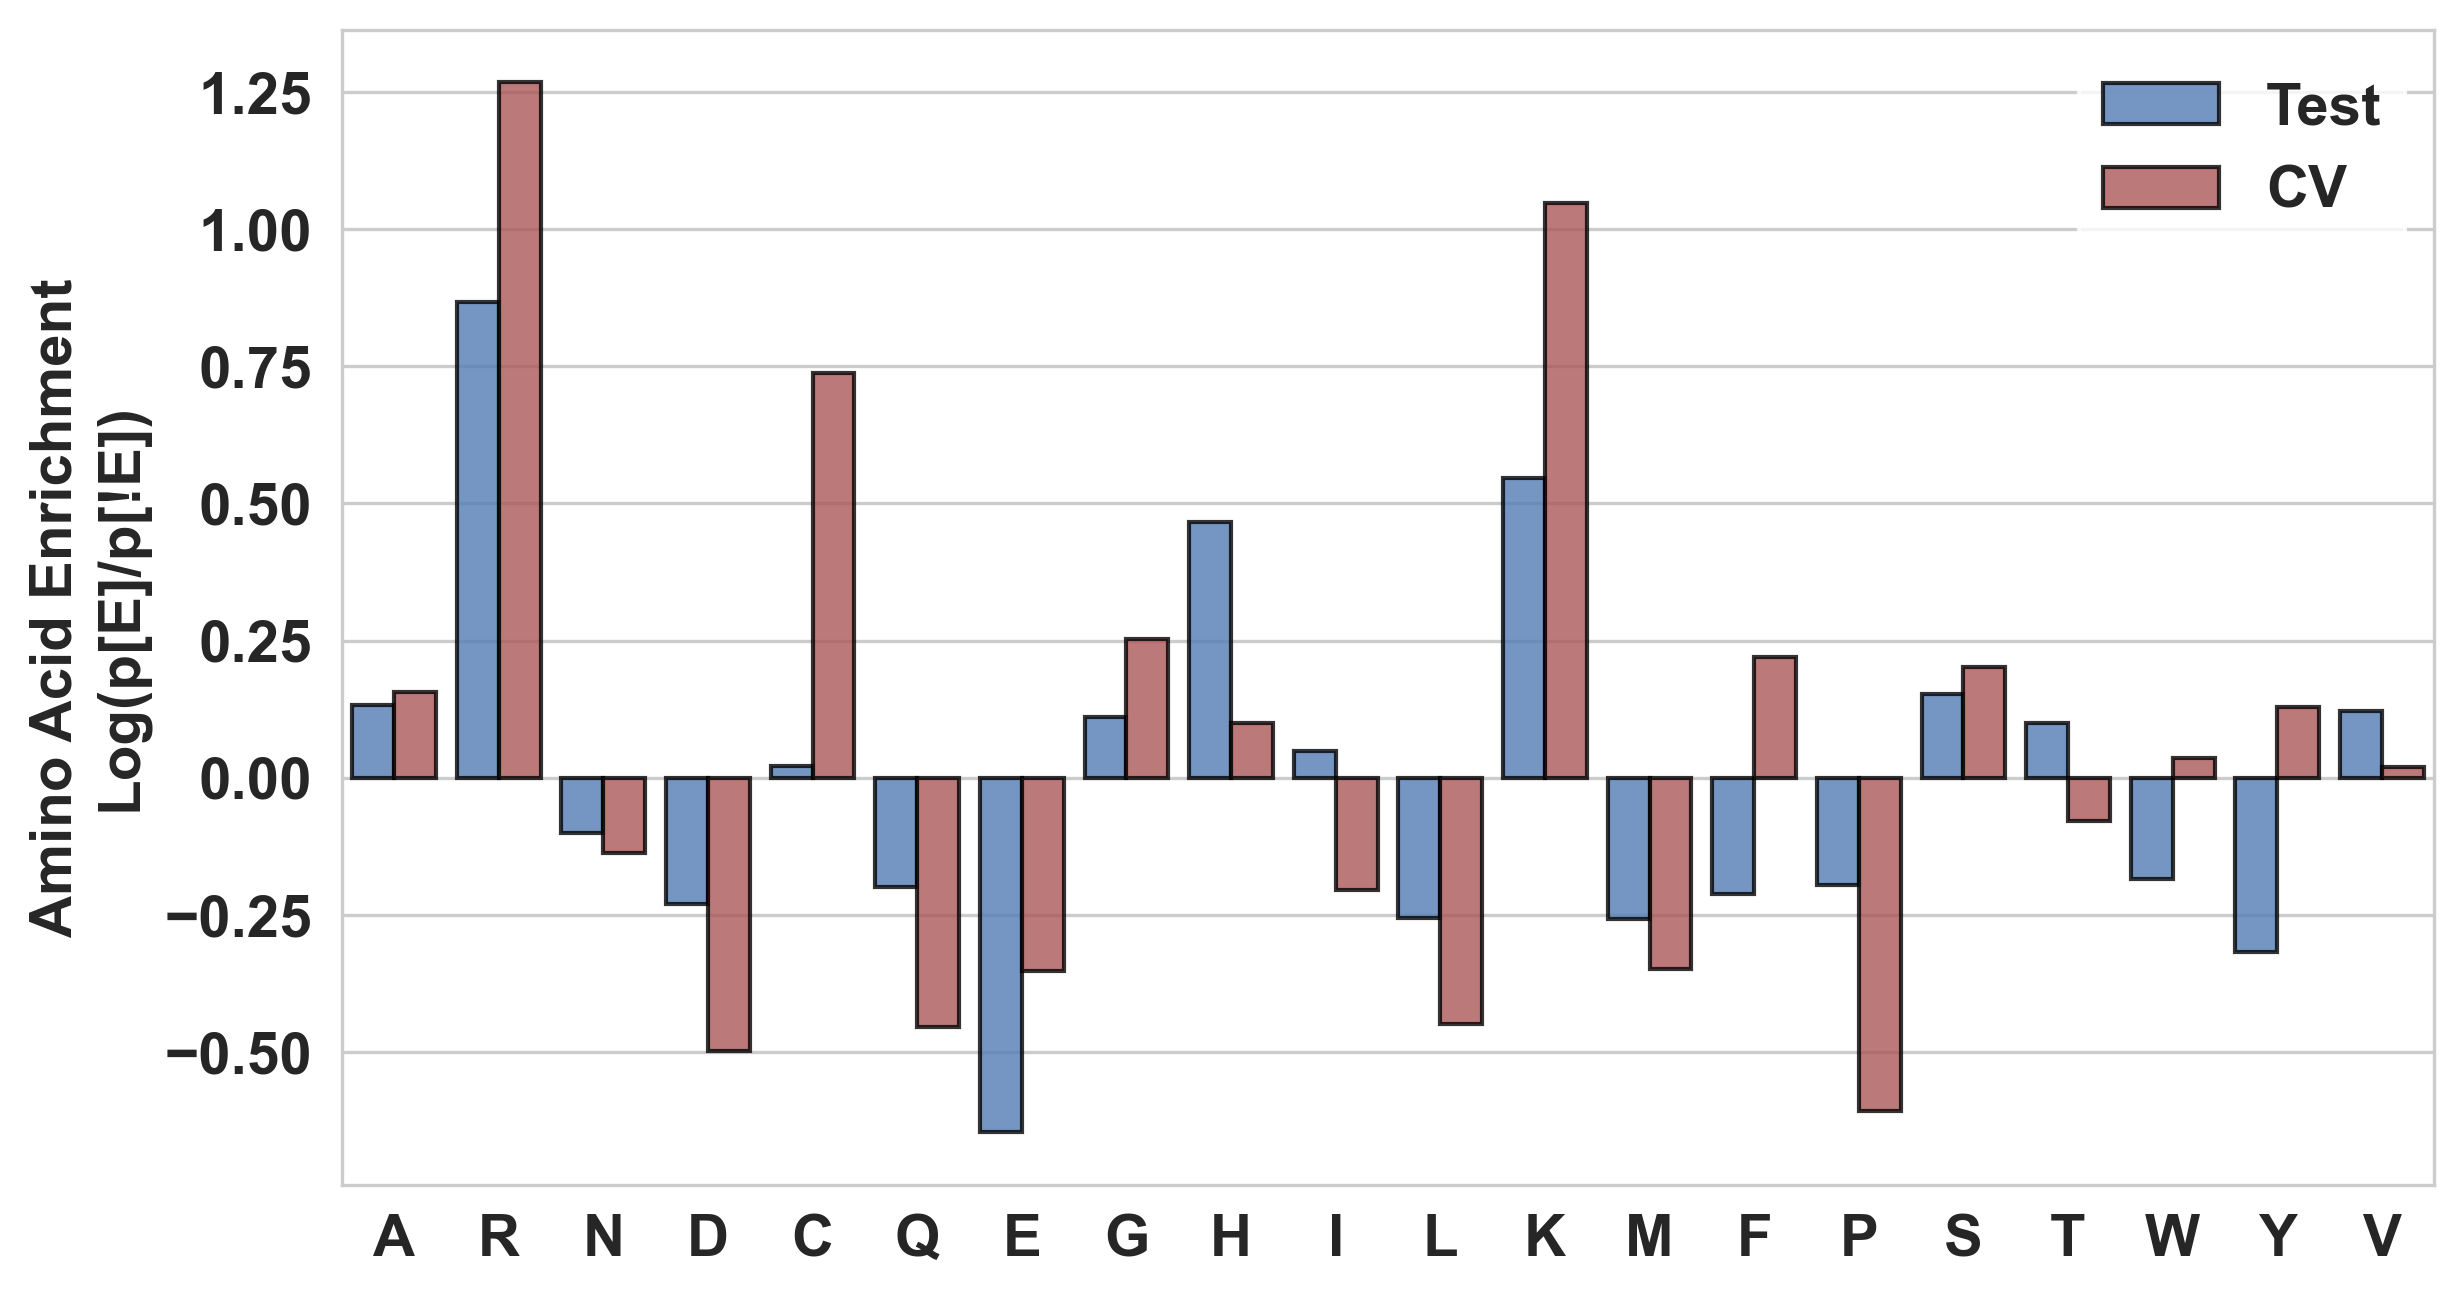

In [436]:
# pal=sns.color_palette('tab10', 10)
# sns.set_palette([pal[0], pal[3]])
pal=sns.color_palette('vlag', 15)
sns.set_palette([pal[0], pal[-1]])
fw, fs = 'semibold', 14
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.barplot(dr_melted.replace({'aa_enrichment_test':'Test', 'aa_enrichment_KCV':'CV'})\
                     .rename(columns={'variable':'Dataset', 'value':'AA Enrichment'}), 
            x='AA', y='AA Enrichment', hue='Dataset', hue_order=['Test', 'CV'],
            order=AA_KEYS, ax=ax, saturation=.85, alpha=.8, edgecolor='k', gap=0)
ax.set_xlabel(None)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fs, fontweight=fw)
ax.legend(prop={'weight':fw, 'size':fs},  edgecolor='w')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=fs, fontweight=fw)
ax.set_ylabel('Amino Acid Enrichment\nLog(p[E]/p[!E])', fontsize=fs, fontweight=fw)
fig.savefig('../../../writing/pynnalign_draft/figure/HLA-DR_aa_enrichment.png', dpi=300, bbox_inches='tight')

In [241]:
rereindex = [x for x in 'ACDEFGHIKLMNPQRSTVWY']
dr_merged[['AA']+[x for x in dr_merged.columns if 'chi2' in x]].set_index('AA').reindex(rereindex).to_clipboard()

[-0.2, 0.8, 1.8, 2.8, 3.8, 4.8, 5.8, 6.8, 7.8, 8.8, 9.8, 10.8, 11.8, 12.8, 13.8, 14.8, 15.8, 16.8, 17.8, 18.8, 0.20000000000000007, 1.2000000000000002, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 14.2, 15.2, 16.2, 17.2, 18.2, 19.2, 0.0, 0.0]


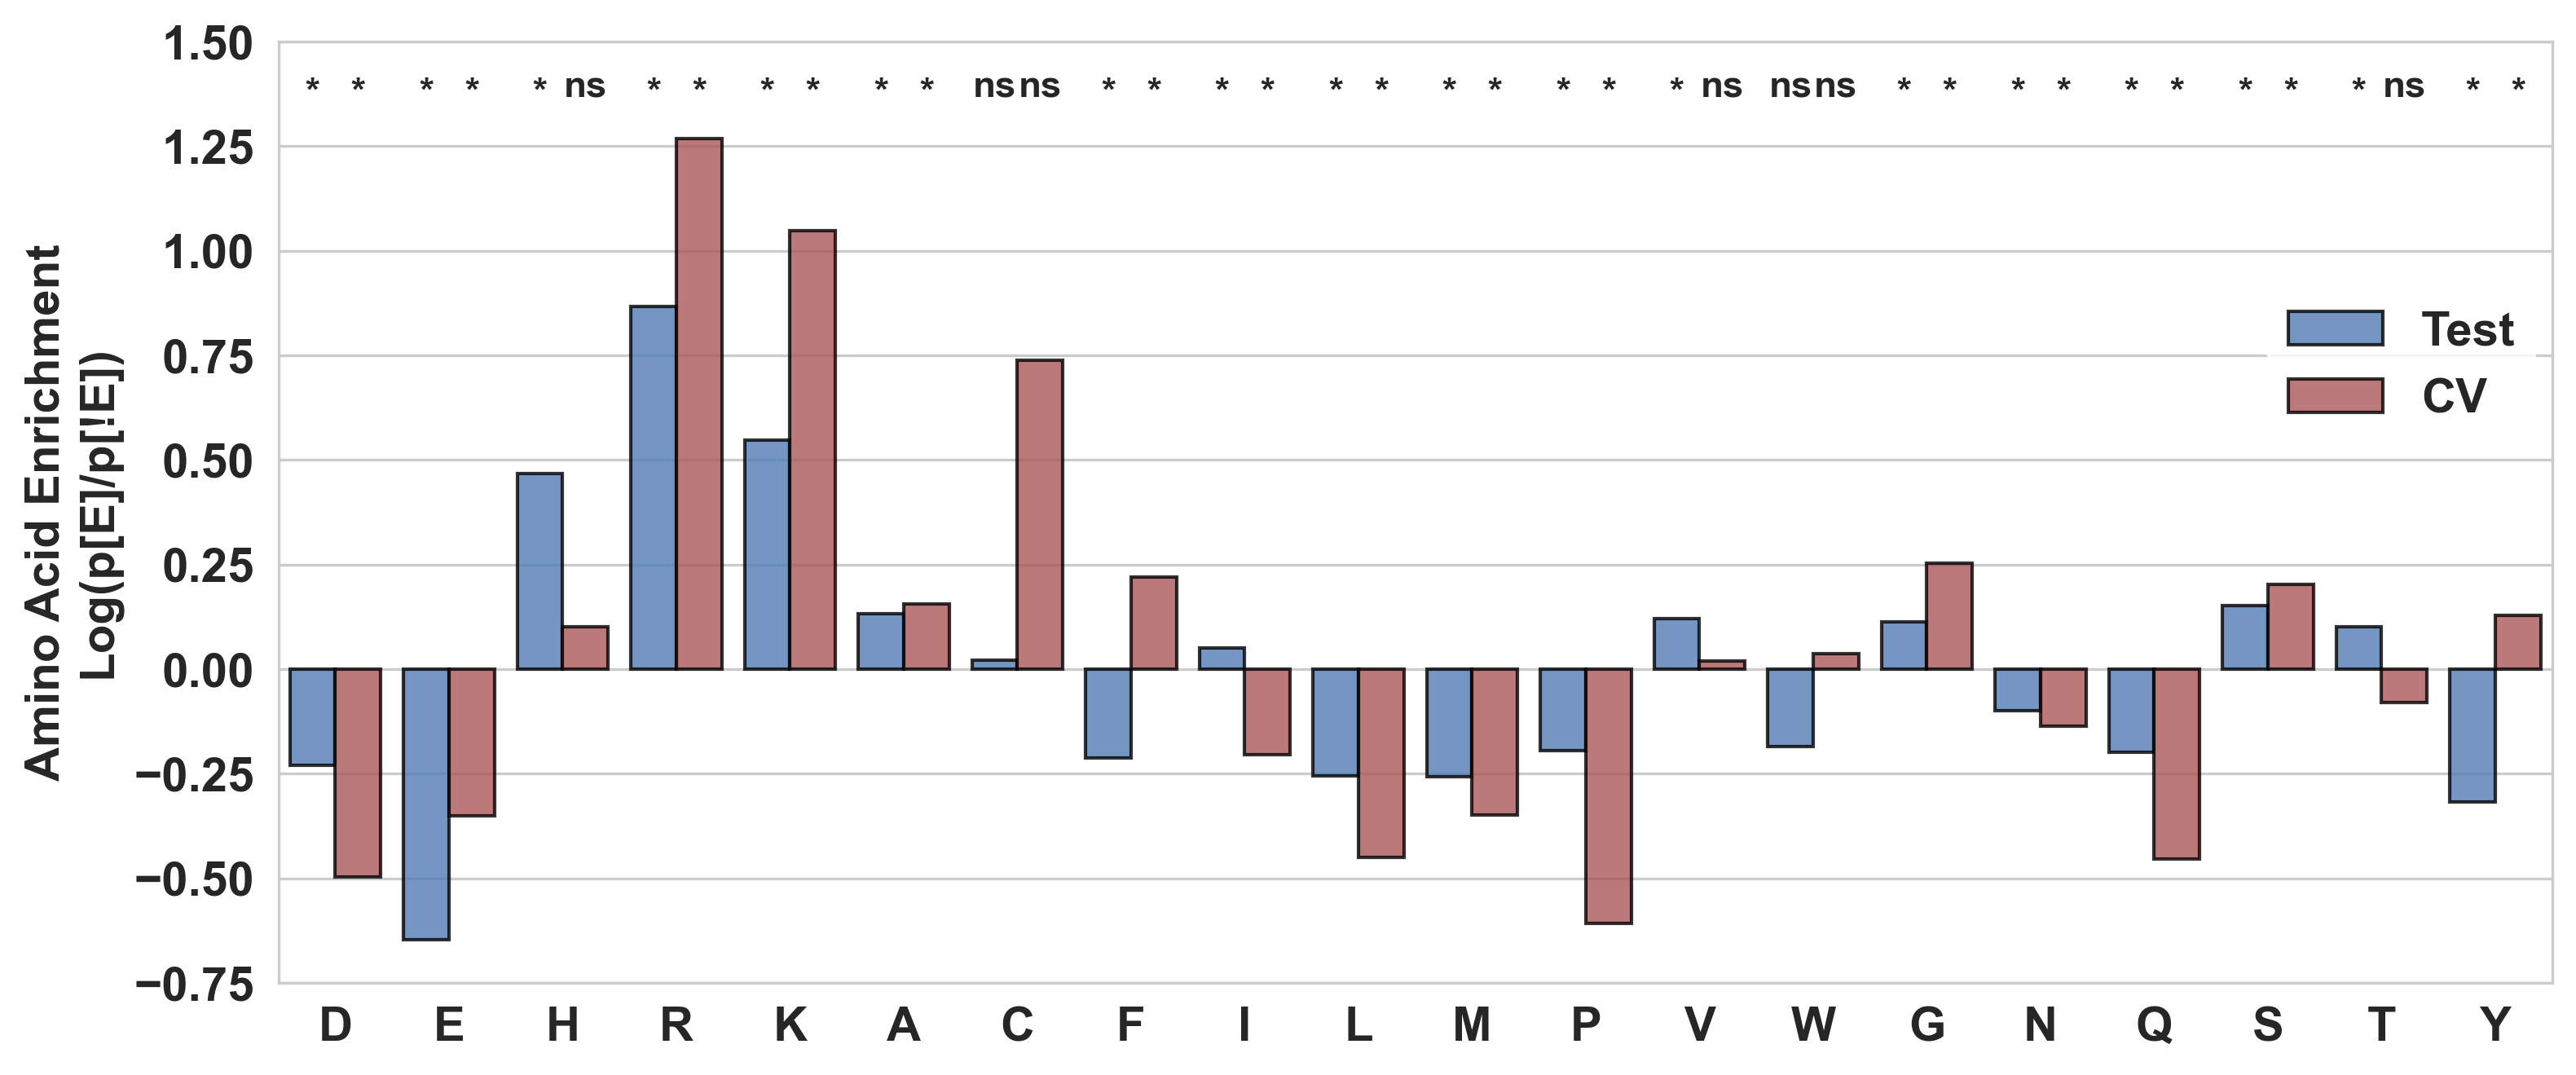

In [413]:
# plot_melted=dr_melted.query('variable.str.contains("enrichment")')
# chi2_melted = chi2_sigs.reset_index().melt(id_vars=['AA'])
# chi2_melted['set'] = chi2_melted['variable'].apply(lambda x: x.split('sig_')[1])
# plot_melted['set'] = plot_melted['variable'].apply(lambda x: x.split('chment_')[1])
# plot_melted = plot_melted.merge(chi2_melted.rename(columns={'value':'sig'}), left_on=['AA','set'], right_on=['AA','set'])
# plot_melted['sig_plot'] = plot_melted['sig'].apply(lambda x: 'ns' if x=="ns" else '*')

aa_groups = {
        'Acidic': set("DE"),
        'Basic': set("HRK"),
        'Hydrophobic': set("ACFILMPVW"),
        'Neutral': set("GNQSTY")
}
reorder = [x for x in 'DEHRKACFILMPVWGNQSTY']
pal=sns.color_palette('vlag', 15)
sns.set_palette([pal[0], pal[-1]])
fw, fs = 'semibold', 14
fig, ax = plt.subplots(1,1, figsize=(12,5))


sns.barplot(dr_melted.replace({'aa_enrichment_test':'Test', 'aa_enrichment_KCV':'CV'})\
                     .rename(columns={'variable':'Dataset', 'value':'AA Enrichment'}), 
            x='AA', y='AA Enrichment', hue='Dataset', hue_order=['Test', 'CV'],
            order=reorder, ax=ax, saturation=.85, alpha=.8, edgecolor='k', gap=0)
ax.set_xlabel(None)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fs, fontweight=fw)
ax.legend(prop={'weight':fw, 'size':fs}, edgecolor='w', bbox_to_anchor=(0.865,0.55))
ax.set_yticklabels(ax.get_yticklabels(), fontsize=fs, fontweight=fw)
ax.set_ylabel('Amino Acid Enrichment\nLog(p[E]/p[!E])', fontsize=fs, fontweight=fw)
ax.set_ylim([-.75, 1.5])

fill=True
# Significance levels
centers = [patch.get_x() + patch.get_width()/2 for patch in ax.patches]
print(centers)
xd=[str(i) for i in range(40)]
sigs= chi2_sigs.reset_index().melt(id_vars=['AA'], value_vars=['chi2_sig_test', 'chi2_sig_KCV'])
for i,x in enumerate(centers):
    # updating seaborn changed the order in which the fucking boxes are made
    # now the index is [0, 1, 2] = [hue_0_x0, hue0_x1, hue0_x2]
    if x==0:continue
    # print(i)
    sig='ns' if sigs.iloc[i]['value']=='ns' else '*'
    va = 'baseline' if sig=='*' else 'bottom'
    
    ax.text(x, y=1.35,s=f'{sig}',# {xd[i]}',
            horizontalalignment='center', verticalalignment=va,
            fontweight='semibold', fontsize=11)

fig.savefig('../../../writing/pynnalign_draft/figure/HLA-DR_aa_enrichment_reorder.png', dpi=300, bbox_inches='tight')

In [415]:
np.log((52/58000)/(6/14000))

0.7380985684222116

In [416]:
chi2_contingency([[52, 58000-52],[6, 14000-6]])

Chi2ContingencyResult(statistic=2.5146807175704757, pvalue=0.11279047558411015, dof=1, expected_freq=array([[4.67222222e+01, 5.79532778e+04],
       [1.12777778e+01, 1.39887222e+04]]))

# Do DeepLoc

In [190]:
pd.Series(test_2['Prot_ID'].unique()).to_csv('../data/NetMHCII_EL_jonas/HLA_DR_test_500k_unique_prot_ids.txt', index=False, header=False)

In [245]:
locs = pd.read_csv('../data/NetMHCII_EL_jonas/results_20250315-163922.csv')
locs['Prot_ID'] = locs['Protein_ID'].apply(lambda x: x.split('|')[1])
locs

Protein_ID      Localizations  \
0      sp|Q60888|10D1B_MOUSE      Cell membrane   
1      sp|Q8VBW9|10H28_MOUSE      Cell membrane   
2      sp|Q60885|10P22_MOUSE      Cell membrane   
3      sp|P31946|1433B_HUMAN  Cytoplasm|Nucleus   
4      sp|Q9CQV8|1433B_MOUSE  Cytoplasm|Nucleus   
...                      ...                ...   
30230    sp|Q15942|ZYX_HUMAN          Cytoplasm   
30231    sp|Q62523|ZYX_MOUSE          Cytoplasm   
30232  sp|O43149|ZZEF1_HUMAN          Cytoplasm   
30233  sp|Q5SSH7|ZZEF1_MOUSE          Cytoplasm   
30234   sp|Q8IYH5|ZZZ3_HUMAN            Nucleus   

                                                 Signals  \
0                                   Transmembrane domain   
1                                   Transmembrane domain   
2                                   Transmembrane domain   
3                                  Nuclear export signal   
4                                  Nuclear export signal   
...                                                  ...   
30230                              Nuclear export signal   
30231                              Nuclear export signal   
30232  Nuclear localization signal|Nuclear export signal   
30233                              Nuclear export signal   
30234                        Nuclear localization signal   

                        Membrane types  Cytoplasm  Nucleus  Extracellular  \
0                        Transmembrane     0.1664   0.1303         0.0208   
1                        Transmembrane     0.1634   0.1614         0.0329   
2                        Transmembrane     0.1414   0.1512         0.0272   
3                              Soluble     0.7828   0.5551         0.0324   
4                              Soluble     0.7861   0.5603         0.0309   
...                                ...        ...      ...            ...   
30230               Peripheral|Soluble     0.7908   0.3192         0.0773   
30231               Peripheral|Soluble     0.7992   0.3189         0.0691   
30232  Peripheral|Lipid anchor|Soluble     0.5324   0.5097         0.0505   
30233  Peripheral|Lipid anchor|Soluble     0.5297   0.5204         0.0468   
30234                          Soluble     0.3480   0.9272         0.0171   

       Cell membrane  Mitochondrion  Plastid  Endoplasmic reticulum  \
0             0.8638         0.2046   0.0114                 0.1100   
1             0.9099         0.1884   0.0051                 0.1394   
2             0.9119         0.2540   0.0057                 0.1047   
3             0.2618         0.1140   0.0005                 0.1080   
4             0.2518         0.1112   0.0005                 0.1100   
...              ...            ...      ...                    ...   
30230         0.2598         0.0934   0.0014                 0.1515   
30231         0.2720         0.0915   0.0016                 0.1524   
30232         0.2934         0.2412   0.0081                 0.2573   
30233         0.2815         0.2130   0.0085                 0.2602   
30234         0.0398         0.0478   0.0059                 0.0317   

       Lysosome/Vacuole  Golgi apparatus  Peroxisome  Peripheral  \
0                0.2164           0.0845      0.0200      0.0707   
1                0.2457           0.0746      0.0179      0.0757   
2                0.2764           0.0791      0.0138      0.0806   
3                0.3278           0.1046      0.0854      0.4681   
4                0.3270           0.1068      0.0803      0.4714   
...                 ...              ...         ...         ...   
30230            0.2972           0.3580      0.0019      0.6728   
30231            0.3242           0.3516      0.0021      0.6677   
30232            0.4193           0.4558      0.0173      0.7318   
30233            0.3747           0.4191      0.0219      0.7205   
30234            0.0573           0.0290      0.0041      0.4419   

       Transmembrane  Lipid anchor  Soluble Prot_ID  
0             0.9941        0.0423 

In [252]:
a=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_0_250203_2303_IleIo/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f00_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_0_250203_2303_IleIo.csv')
b=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_1_250204_0005_IleIo/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f01_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_1_250204_0005_IleIo.csv')
c=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_2_250204_0005_IleIo/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f02_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_2_250204_0005_IleIo.csv')
d=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_3_250204_0005_IleIo/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f03_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_3_250204_0005_IleIo.csv')
e=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_4_250204_0310_IleIo/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f04_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_4_250204_0310_IleIo.csv')

es = pd.concat([a.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(a))], model='a'),
                            b.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(b))], model='b'),
                            c.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(c))], model='c'),
                            d.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(d))], model='d'),
                            e.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(e))], model='e')])
ensemble_preds_structure = es.groupby(['seq_id']).agg(ensemble_pred=('pred','mean'),
                                            target=('target','mean'),
                                            sequence=('sequence','first'),
                                            rank=('rank_prediction','mean'),
                                            sample=('sample','first'),
                                            MHC=('MHC','first'),
                                            mhc_rel=('mhc_reliability','mean'),
                                            Prot_ID=('Prot_ID','first'))
ensemble_preds_structure

ensemble_pred  target               sequence       rank  \
seq_id                                                                 
SEQ_0000000       0.024455     0.0      RIQKDHHQASNSSRLHT   8.242545   
SEQ_0000001       0.003146     0.0  TFSALQILPYTLASLYHREKQ  18.861940   
SEQ_0000002       0.011600     0.0          LSQLVNLYLGRSH   9.317119   
SEQ_0000003       0.020626     0.0  FDLRPGVIVRDLDLKKPIYQR  48.163578   
SEQ_0000004       0.000020     0.0        KNCVLLGNICYNCGR  90.962227   
...                    ...     ...                    ...        ...   
SEQ_0499995       0.000813     0.0  GGPGGLKGPVWPAKEENSCSH  52.785919   
SEQ_0499996       0.033741     0.0   FIERDLIEQATMVALEQAGR  10.563462   
SEQ_0499997       0.014373     0.0    NDFQCWEKGQASQITASNL  12.118920   
SEQ_0499998       0.880770     0.0       NNMPEFHKLKAKLIKK   0.380667   
SEQ_0499999       0.000166     0.0        RDDPAFLVLLSIWLC  97.207603   

                               sample        MHC  mhc_rel Prot_ID  
seq_id                                                             
SEQ_0000000        Racle__3808_HMC_DR  DRB1_0701     0.60  O94907  
SEQ_0000001       Racle__3830_NJF_DQP  DRB1_1101     0.60  Q96JT2  
SEQ_0000002               Racle__TIL1  DRB4_0103     0.35  Q9BQ70  
SEQ_0000003         Scally__DRB1_0402  DRB1_0402     1.00  P31153  
SEQ_0000004           Ooi__DR15_human  DRB1_1501     0.60  Q8WW36  
...                               ...        ...      ...     ...  
SEQ_0499995  Abelin__MAPTAC_DRB1_1501  DRB1_1501     1.00  Q6RVD6  
SEQ_0499996              Racle__RA957  DRB1_0401     0.55  Q8TE49  
SEQ_0499997           Racle__CD165_DR  DRB1_1101     0.60  Q9BRX5  
SEQ_0499998     Abelin__HLA_DR_Spleen  DRB1_0101     0.95  Q96NL8  
SEQ_0499999  Abelin__MAPTAC_DRB1_1302  DRB1_1302     1.00  Q53HI1  

[500000 rows x 8 columns]

In [253]:
a=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_0_250203_1553_S7E7m/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f00_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_0_250203_1553_S7E7m.csv')
b=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_1_250203_1857_S7E7m/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f01_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_1_250203_1857_S7E7m.csv')
c=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_2_250203_1958_S7E7m/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f02_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_2_250203_1958_S7E7m.csv')
d=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_3_250203_1958_S7E7m/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f03_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_3_250203_1958_S7E7m.csv')
e=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_4_250203_1959_S7E7m/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f04_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_4_250203_1959_S7E7m.csv')

es = pd.concat([a.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(a))], model='a'),
                            b.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(b))], model='b'),
                            c.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(c))], model='c'),
                            d.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(d))], model='d'),
                            e.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(e))], model='e')])
ensemble_preds_baseline = es.groupby(['seq_id']).agg(ensemble_pred=('pred','mean'),
                                            target=('target','mean'),
                                            sequence=('sequence','first'),
                                            rank=('rank_prediction','mean'),
                                            sample=('sample','first'),
                                            MHC=('MHC','first'),
                                            mhc_rel=('mhc_reliability','mean'),
                                            Prot_ID=('Prot_ID','first'))
ensemble_preds_baseline

ensemble_pred  target               sequence       rank  \
seq_id                                                                 
SEQ_0000000       0.029385     0.0      RIQKDHHQASNSSRLHT   8.242545   
SEQ_0000001       0.006167     0.0  TFSALQILPYTLASLYHREKQ  18.861940   
SEQ_0000002       0.011484     0.0          LSQLVNLYLGRSH   9.317119   
SEQ_0000003       0.018255     0.0  FDLRPGVIVRDLDLKKPIYQR  48.163578   
SEQ_0000004       0.000027     0.0        KNCVLLGNICYNCGR  90.962227   
...                    ...     ...                    ...        ...   
SEQ_0499995       0.000269     0.0  GGPGGLKGPVWPAKEENSCSH  52.785919   
SEQ_0499996       0.027656     0.0   FIERDLIEQATMVALEQAGR  10.563462   
SEQ_0499997       0.095583     0.0    NDFQCWEKGQASQITASNL  12.118920   
SEQ_0499998       0.831241     0.0       NNMPEFHKLKAKLIKK   0.380667   
SEQ_0499999       0.000148     0.0        RDDPAFLVLLSIWLC  97.207603   

                               sample        MHC  mhc_rel Prot_ID  
seq_id                                                             
SEQ_0000000        Racle__3808_HMC_DR  DRB1_0701     0.60  O94907  
SEQ_0000001       Racle__3830_NJF_DQP  DRB1_1101     0.60  Q96JT2  
SEQ_0000002               Racle__TIL1  DRB4_0103     0.35  Q9BQ70  
SEQ_0000003         Scally__DRB1_0402  DRB1_0402     1.00  P31153  
SEQ_0000004           Ooi__DR15_human  DRB1_1501     0.60  Q8WW36  
...                               ...        ...      ...     ...  
SEQ_0499995  Abelin__MAPTAC_DRB1_1501  DRB1_1501     1.00  Q6RVD6  
SEQ_0499996              Racle__RA957  DRB1_0401     0.55  Q8TE49  
SEQ_0499997           Racle__CD165_DR  DRB1_1101     0.60  Q9BRX5  
SEQ_0499998     Abelin__HLA_DR_Spleen  DRB1_0101     0.95  Q96NL8  
SEQ_0499999  Abelin__MAPTAC_DRB1_1302  DRB1_1302     1.00  Q53HI1  

[500000 rows x 8 columns]

In [254]:
locs.head()

Protein_ID      Localizations                Signals  \
0  sp|Q60888|10D1B_MOUSE      Cell membrane   Transmembrane domain   
1  sp|Q8VBW9|10H28_MOUSE      Cell membrane   Transmembrane domain   
2  sp|Q60885|10P22_MOUSE      Cell membrane   Transmembrane domain   
3  sp|P31946|1433B_HUMAN  Cytoplasm|Nucleus  Nuclear export signal   
4  sp|Q9CQV8|1433B_MOUSE  Cytoplasm|Nucleus  Nuclear export signal   

  Membrane types  Cytoplasm  Nucleus  Extracellular  Cell membrane  \
0  Transmembrane     0.1664   0.1303         0.0208         0.8638   
1  Transmembrane     0.1634   0.1614         0.0329         0.9099   
2  Transmembrane     0.1414   0.1512         0.0272         0.9119   
3        Soluble     0.7828   0.5551         0.0324         0.2618   
4        Soluble     0.7861   0.5603         0.0309         0.2518   

   Mitochondrion  Plastid  Endoplasmic reticulum  Lysosome/Vacuole  \
0         0.2046   0.0114                 0.1100            0.2164   
1         0.1884   0.0051                 0.1394            0.2457   
2         0.2540   0.0057                 0.1047            0.2764   
3         0.1140   0.0005                 0.1080            0.3278   
4         0.1112   0.0005                 0.1100            0.3270   

   Golgi apparatus  Peroxisome  Peripheral  Transmembrane  Lipid anchor  \
0           0.0845      0.0200      0.0707         0.9941        0.0423   
1           0.0746      0.0179      0.0757         0.9949        0.0418   
2           0.0791      0.0138      0.0806         0.9927        0.0394   
3           0.1046      0.0854      0.4681         0.0125        0.1419   
4           0.1068      0.0803      0.4714         0.0129        0.1485   

   Soluble Prot_ID  
0   0.1288  Q60888  
1   0.1255  Q8VBW9  
2   0.1553  Q60885  
3   0.8637  P31946  
4   0.8624  Q9CQV8

In [257]:
ensemble_preds_merged = pd.merge(ensemble_preds_baseline[['ensemble_pred']].rename(columns={'ensemble_pred':'ensemble_pred_baseline'}),
                                 ensemble_preds_structure.rename(columns={'ensemble_pred':'ensemble_pred_structure'}),
                                 left_index=True, right_index=True)
ensemble_preds_merged = ensemble_preds_merged.merge(locs.drop(columns=['Protein_ID']), left_on=['Prot_ID'], right_on=['Prot_ID'], how='left').set_index(['sequence','Prot_ID'])
ensemble_preds_merged.head()

ensemble_pred_baseline  \
sequence              Prot_ID                           
RIQKDHHQASNSSRLHT     O94907                 0.029385   
TFSALQILPYTLASLYHREKQ Q96JT2                 0.006167   
LSQLVNLYLGRSH         Q9BQ70                 0.011484   
FDLRPGVIVRDLDLKKPIYQR P31153                 0.018255   
KNCVLLGNICYNCGR       Q8WW36                 0.000027   

                               ensemble_pred_structure  target       rank  \
sequence              Prot_ID                                               
RIQKDHHQASNSSRLHT     O94907                  0.024455     0.0   8.242545   
TFSALQILPYTLASLYHREKQ Q96JT2                  0.003146     0.0  18.861940   
LSQLVNLYLGRSH         Q9BQ70                  0.011600     0.0   9.317119   
FDLRPGVIVRDLDLKKPIYQR P31153                  0.020626     0.0  48.163578   
KNCVLLGNICYNCGR       Q8WW36                  0.000020     0.0  90.962227   

                                            sample        MHC  mhc_rel  \
sequence              Prot_ID                                            
RIQKDHHQASNSSRLHT     O94907    Racle__3808_HMC_DR  DRB1_0701     0.60   
TFSALQILPYTLASLYHREKQ Q96JT2   Racle__3830_NJF_DQP  DRB1_1101     0.60   
LSQLVNLYLGRSH         Q9BQ70           Racle__TIL1  DRB4_0103     0.35   
FDLRPGVIVRDLDLKKPIYQR P31153     Scally__DRB1_0402  DRB1_0402     1.00   
KNCVLLGNICYNCGR       Q8WW36       Ooi__DR15_human  DRB1_1501     0.60   

                                   Localizations  \
sequence              Prot_ID                      
RIQKDHHQASNSSRLHT     O94907       Extracellular   
TFSALQILPYTLASLYHREKQ Q96JT2    Lysosome/Vacuole   
LSQLVNLYLGRSH         Q9BQ70   Cytoplasm|Nucleus   
FDLRPGVIVRDLDLKKPIYQR P31153          Peroxisome   
KNCVLLGNICYNCGR       Q8WW36           Cytoplasm   

                                                           Signals  \
sequence              Prot_ID                                        
RIQKDHHQASNSSRLHT     O94907                        Signal peptide   
TFSALQILPYTLASLYHREKQ Q96JT2   Signal peptide|Transmembrane domain   
LSQLVNLYLGRSH         Q9BQ70                 Nuclear export signal   
FDLRPGVIVRDLDLKKPIYQR P31153          Peroxisomal targeting signal   
KNCVLLGNICYNCGR       Q8WW36                                   NaN   

                              Membrane types  ...  Mitochondrion  Plastid  \
sequence              Prot_ID                 ...                           
RIQKDHHQASNSSRLHT     O94907         Soluble  ...         0.0967   0.0097   
TFSALQILPYTLASLYHREKQ Q96JT2   Transmembrane  ...         0.1276   0.0031   
LSQLVNLYLGRSH         Q9BQ70         Soluble  ...         0.1091   0.0002   
FDLRPGVIVRDLDLKKPIYQR P31153         Soluble  ...         0.2142   0.0271   
KNCVLLGNICYNCGR       Q8WW36         Soluble  ...         0.1301   0.0128   

                               Endoplasmic reticulum  Lysosome/Vacuole  \
sequence              Prot_ID                                            
RIQKDHHQASNSSRLHT     O94907                  0.2940            0.2854   
TFSALQILPYTLASLYHREKQ Q96JT2                  0.4034            0.4999   
LSQLVNLYLGRSH         Q9BQ70                  0.0527            0.0832   
FDLRPGVIVRDLDLKKPIYQR P31153                  0.0578            0.0520   
KNCVLLGNICYNCGR       Q8WW36                  0.1360            0.2055   

                               Golgi apparatus  Peroxisome  Peripheral  \
sequence              Prot_ID                                            
RIQKDHHQASNSSRLHT     O94907            0.4229      0.0036      0.3513   
TFSALQILPYTLASLYHREKQ Q96JT2            0.5265      0.0102      0.0720   
LSQLVNLYLGRSH         Q9BQ70            0.1114      0.0575      0.5328   
FDLRPGVIVRDLDLKKPIYQR P31153            0.0336      0.7696      0.4431   
KNCVLLGNICYNCGR       Q8WW36            0.0860      0.0044      0.1752   

                               Transmembrane  Lipid anchor  Soluble  
sequence              Prot_ID                                       

In [259]:
ensemble_preds_baseline = ensemble_preds_baseline.merge(locs.drop(columns=['Protein_ID']), left_on=['Prot_ID'], right_on=['Prot_ID'], how='left').set_index(['sequence','Prot_ID'])
ensemble_preds_structure = ensemble_preds_structure.merge(locs.drop(columns=['Protein_ID']), left_on=['Prot_ID'], right_on=['Prot_ID'], how='left').set_index(['sequence','Prot_ID'])

In [260]:
print(roc_auc_score(ensemble_preds_baseline['target'],ensemble_preds_baseline['ensemble_pred']))
print(roc_auc_score(ensemble_preds_structure['target'],ensemble_preds_structure['ensemble_pred']))


0.932585062998253
0.9336826262384527


A maybe crazy idea. The class II pathway is high complex, and ligands can come from many sources (reviewed here). Could it be that the structural signal of the ligands is dependent on the pathway and hence maybe the subcellular localization of the source protein?. Could we use DeepLoc to predict these localizations and next use this as additional input to the model (i.e take prediction vector from DeepLoc-2.1 for the 10 classes as input to the first hidden layer)? Alternatively, you can predict the subcellular location of the source proteins in the class II data set, and split the prediction file into subsets based on these predictions, and from see if the performance gain is higher for some localisations compared to others.

## per loc

In [282]:
[x for x in ensemble_preds_structure['Localizations'].unique() if '|' not in x]

['Extracellular',
 'Lysosome/Vacuole',
 'Peroxisome',
 'Cytoplasm',
 'Golgi apparatus',
 'Nucleus',
 'Endoplasmic reticulum',
 'Cell membrane',
 'Mitochondrion',
 'Plastid']

In [291]:
[x for x in ensemble_preds_structure['Localizations'].unique() if '|' in x and not ('Cytoplasm' in x or 'Cell membrane' in x)]

['Endoplasmic reticulum|Golgi apparatus',
 'Nucleus|Lysosome/Vacuole',
 'Endoplasmic reticulum|Lysosome/Vacuole|Golgi apparatus',
 'Extracellular|Endoplasmic reticulum',
 'Mitochondrion|Peroxisome',
 'Extracellular|Lysosome/Vacuole',
 'Endoplasmic reticulum|Peroxisome',
 'Endoplasmic reticulum|Lysosome/Vacuole',
 'Lysosome/Vacuole|Golgi apparatus',
 'Extracellular|Golgi apparatus',
 'Mitochondrion|Endoplasmic reticulum',
 'Mitochondrion|Lysosome/Vacuole',
 'Mitochondrion|Golgi apparatus',
 'Mitochondrion|Plastid',
 'Mitochondrion|Endoplasmic reticulum|Lysosome/Vacuole|Golgi apparatus',
 'Nucleus|Mitochondrion',
 'Nucleus|Endoplasmic reticulum',
 'Mitochondrion|Endoplasmic reticulum|Lysosome/Vacuole',
 'Extracellular|Mitochondrion',
 'Nucleus|Peroxisome']

In [261]:
def gb_auc(x):
    try:
        return roc_auc_score(x['target'], x['ensemble_pred'])
    except:
        return np.nan

def gb_auc01(x):
    try:
        return roc_auc_score(x['target'], x['ensemble_pred'], max_fpr=0.1)
    except:
        return np.nan

def gb_ppv(x):
    # print(type(x), x)
    n_pos = len(x.query('target==1'))
    if n_pos==0:
        return np.nan
    head = x.sort_values('ensemble_pred',ascending=False).head(n_pos)
    return len(head.query('target==1'))/n_pos

loc_cols = ['Cytoplasm', 'Nucleus', 'Extracellular', 'Cell membrane', 
            'Mitochondrion', 'Plastid', 'Endoplasmic reticulum', 
            'Lysosome/Vacuole', 'Golgi apparatus', 'Peroxisome']
def get_argmax(row):
    return pd.to_numeric(row[loc_cols]).idxmax()

def get_merged_gb_auc(df_struct, df_base, gbcol):
    counts = df_struct.groupby([gbcol]).agg(count=('rank','count'))
    n_pos = df_struct.groupby([gbcol]).agg(pos_count=('target','sum')).astype(int)
    counts = pd.merge(counts, n_pos, left_index=True, right_index=True)
    merged_auc = pd.merge(df_struct.groupby([gbcol]).apply(lambda x: gb_auc(x)).rename('AUC'),
                    df_base.groupby([gbcol]).apply(lambda x: gb_auc(x)).rename('AUC'),
                    left_index=True, right_index=True, suffixes=('_PosStruct','_baseline'))
    
    merged_auc01 = pd.merge(df_struct.groupby([gbcol]).apply(lambda x: gb_auc01(x)).rename('AUC01'),
                            df_base.groupby([gbcol]).apply(lambda x: gb_auc01(x)).rename('AUC01'),
                            left_index=True, right_index=True, suffixes=('_PosStruct','_baseline'))
    
    merged_ppv = pd.merge(df_struct.groupby([gbcol]).apply(lambda x: gb_ppv(x)).rename('PPV'),
                          df_base.groupby([gbcol]).apply(lambda x: gb_ppv(x)).rename('PPV'),
                          left_index=True, right_index=True, suffixes=('_PosStruct','_baseline'))
    merged = pd.merge(counts, merged_auc, left_index=True, right_index=True, how='right')
    merged['delta_AUC']=merged['AUC_PosStruct']-merged['AUC_baseline']
    
    merged = pd.merge(merged, merged_auc01, left_index=True, right_index=True, how='left')
    merged['delta_AUC01']=merged['AUC01_PosStruct']-merged['AUC01_baseline']
    
    merged = pd.merge(merged, merged_ppv, left_index=True, right_index=True, how='left')
    merged['delta_PPV']=merged['PPV_PosStruct']-merged['PPV_baseline']
    # merged['better']=merged['AUC_PosStruct']>merged['AUC_baseline']
    return merged.round(5)

In [262]:
# do argmax of the predicted loc score and give a "unambiguous class"
ensemble_preds_structure['loc_first'] = ensemble_preds_structure['Localizations'].apply(lambda x: x.split('|')[0])
ensemble_preds_structure['loc_argmax'] = ensemble_preds_structure.apply(get_argmax, axis=1)

ensemble_preds_baseline['loc_first'] = ensemble_preds_baseline['Localizations'].apply(lambda x: x.split('|')[0])
ensemble_preds_baseline['loc_argmax'] = ensemble_preds_baseline.apply(get_argmax, axis=1)

ensemble_preds_merged['loc_first'] = ensemble_preds_merged['Localizations'].apply(lambda x: x.split('|')[0])
ensemble_preds_merged['loc_argmax'] = ensemble_preds_merged.apply(get_argmax, axis=1)


In [295]:
ensemble_preds_merged.to_csv('../output/250327_HLA_DR_ensemble_preds_merged_loc.csv')

In [294]:
a=get_merged_gb_auc(ensemble_preds_structure, ensemble_preds_baseline, 'Localizations')
a.drop([x for x in a.index if '|' in x]).to_csv(f'../output/250319_HLA_DR_results_by_loca_ambiguous.csv')
b=get_merged_gb_auc(ensemble_preds_structure, ensemble_preds_baseline, 'loc_first')
b.to_csv(f'../output/250319_HLA_DR_results_by_loca_first.csv')
c=get_merged_gb_auc(ensemble_preds_structure, ensemble_preds_baseline, 'loc_argmax')
c.to_csv(f'../output/250319_HLA_DR_results_by_loca_argmax.csv')

In [423]:
a.drop([x for x in a.index if '|' in x]).sort_values('delta_AUC').sort_index().query('delta_AUC>0.001 or delta_AUC<0.001')

count  pos_count  AUC_PosStruct  AUC_baseline  \
Localizations                                                           
Cell membrane           73655       5075        0.94687       0.94164   
Cytoplasm              112528       4535        0.91842       0.91930   
Endoplasmic reticulum   23456       1630        0.94422       0.94068   
Extracellular           42618       4535        0.94799       0.94927   
Golgi apparatus          7315       1149        0.93754       0.93831   
Lysosome/Vacuole         3570        442        0.95410       0.95414   
Mitochondrion           22617        494        0.89293       0.89569   
Nucleus                 80164        739        0.82310       0.82595   
Peroxisome               1008         47        0.94002       0.93863   
Plastid                    26          1        1.00000       0.96000   

                       delta_AUC  AUC01_PosStruct  AUC01_baseline  \
Localizations                                                       
Cell membrane            0.00523          0.87297         0.86416   
Cytoplasm               -0.00088          0.86716         0.86969   
Endoplasmic reticulum    0.00354          0.85113         0.84715   
Extracellular           -0.00128          0.86768         0.86904   
Golgi apparatus         -0.00077          0.83536         0.84079   
Lysosome/Vacuole        -0.00003          0.89788         0.89681   
Mitochondrion           -0.00276          0.84647         0.84779   
Nucleus                 -0.00286          0.76305         0.76799   
Peroxisome               0.00139          0.88994         0.88365   
Plastid                  0.04000          1.00000         0.78947   

                       delta_AUC01  PPV_PosStruct  PPV_baseline  delta_PPV  
Localizations                                                               
Cell membrane              0.00881        0.70365       0.68493    0.01872  
Cytoplasm                 -0.00252        0.65755       0.65954   -0.00198  
Endoplasmic reticulum      0.00397        0.66012       0.65215    0.00798  
Extracellular             -0.00136        0.74068       0.74046    0.00022  
Golgi apparatus           -0.00543        0.73368       0.74500   -0.01131  
Lysosome/Vacuole           0.00107        0.79412       0.78733    0.00679  
Mitochondrion             -0.00132        0.57085       0.55870    0.01215  
Nucleus                   -0.00494        0.35453       0.35995   -0.00541  
Peroxisome                 0.00629        0.72340       0.68085    0.04255  
Plastid                    0.21053        1.00000       0.00000    1.00000

In [424]:
b

count  pos_count  AUC_PosStruct  AUC_baseline  \
loc_first                                                               
Cell membrane           94229       7470        0.94712       0.94321   
Cytoplasm              213303       8033        0.92058       0.92162   
Endoplasmic reticulum   28140       1879        0.94637       0.94312   
Extracellular           46454       5356        0.94580       0.94735   
Golgi apparatus          7315       1149        0.93754       0.93831   
Lysosome/Vacuole         5314        650        0.95347       0.95280   
Mitochondrion           23705        513        0.89507       0.89717   
Nucleus                 80506        743        0.82398       0.82683   
Peroxisome               1008         47        0.94002       0.93863   
Plastid                    26          1        1.00000       0.96000   

                       delta_AUC  AUC01_PosStruct  AUC01_baseline  \
loc_first                                                           
Cell membrane            0.00392          0.87253         0.86700   
Cytoplasm               -0.00104          0.86788         0.87024   
Endoplasmic reticulum    0.00326          0.85551         0.85203   
Extracellular           -0.00156          0.86437         0.86648   
Golgi apparatus         -0.00077          0.83536         0.84079   
Lysosome/Vacuole         0.00067          0.89557         0.89219   
Mitochondrion           -0.00210          0.84882         0.84983   
Nucleus                 -0.00285          0.76402         0.76890   
Peroxisome               0.00139          0.88994         0.88365   
Plastid                  0.04000          1.00000         0.78947   

                       delta_AUC01  PPV_PosStruct  PPV_baseline  delta_PPV  
loc_first                                                                   
Cell membrane              0.00553        0.71888       0.70509    0.01379  
Cytoplasm                 -0.00236        0.65057       0.65268   -0.00212  
Endoplasmic reticulum      0.00348        0.66472       0.65620    0.00852  
Extracellular             -0.00210        0.74683       0.74552    0.00131  
Golgi apparatus           -0.00543        0.73368       0.74500   -0.01131  
Lysosome/Vacuole           0.00337        0.79538       0.78154    0.01385  
Mitochondrion             -0.00101        0.57700       0.56335    0.01365  
Nucleus                   -0.00488        0.35801       0.36070   -0.00269  
Peroxisome                 0.00629        0.72340       0.68085    0.04255  
Plastid                    0.21053        1.00000       0.00000    1.00000

In [425]:
c

count  pos_count  AUC_PosStruct  AUC_baseline  \
loc_argmax                                                              
Cell membrane           89965       6659        0.94656       0.94276   
Cytoplasm              147616       6147        0.92401       0.92527   
Endoplasmic reticulum   30975       2010        0.94279       0.93928   
Extracellular           48612       5388        0.94371       0.94523   
Golgi apparatus         18955       2232        0.94381       0.94296   
Lysosome/Vacuole        11119        978        0.95971       0.95922   
Mitochondrion           26588        605        0.89278       0.89427   
Nucleus                123685       1710        0.86059       0.86244   
Peroxisome               2398        111        0.91489       0.91115   
Plastid                    87          1        0.96512       0.91860   

                       delta_AUC  AUC01_PosStruct  AUC01_baseline  \
loc_argmax                                                          
Cell membrane            0.00380          0.87318         0.86746   
Cytoplasm               -0.00126          0.87024         0.87288   
Endoplasmic reticulum    0.00350          0.85812         0.85485   
Extracellular           -0.00152          0.86160         0.86389   
Golgi apparatus          0.00085          0.85702         0.85758   
Lysosome/Vacuole         0.00049          0.89137         0.89118   
Mitochondrion           -0.00150          0.84400         0.84544   
Nucleus                 -0.00185          0.80811         0.80987   
Peroxisome               0.00374          0.84116         0.84856   
Plastid                  0.04651          0.81640         0.57160   

                       delta_AUC01  PPV_PosStruct  PPV_baseline  delta_PPV  
loc_argmax                                                                  
Cell membrane              0.00573        0.71242       0.69815    0.01427  
Cytoplasm                 -0.00264        0.66341       0.66585   -0.00244  
Endoplasmic reticulum      0.00328        0.66617       0.65970    0.00647  
Extracellular             -0.00229        0.73831       0.73701    0.00130  
Golgi apparatus           -0.00056        0.73477       0.73656   -0.00179  
Lysosome/Vacuole           0.00019        0.75358       0.75971   -0.00613  
Mitochondrion             -0.00144        0.56364       0.56694   -0.00331  
Nucleus                   -0.00176        0.46082       0.47427   -0.01345  
Peroxisome                -0.00740        0.64865       0.63063    0.01802  
Plastid                    0.24480        0.00000       0.00000    0.00000

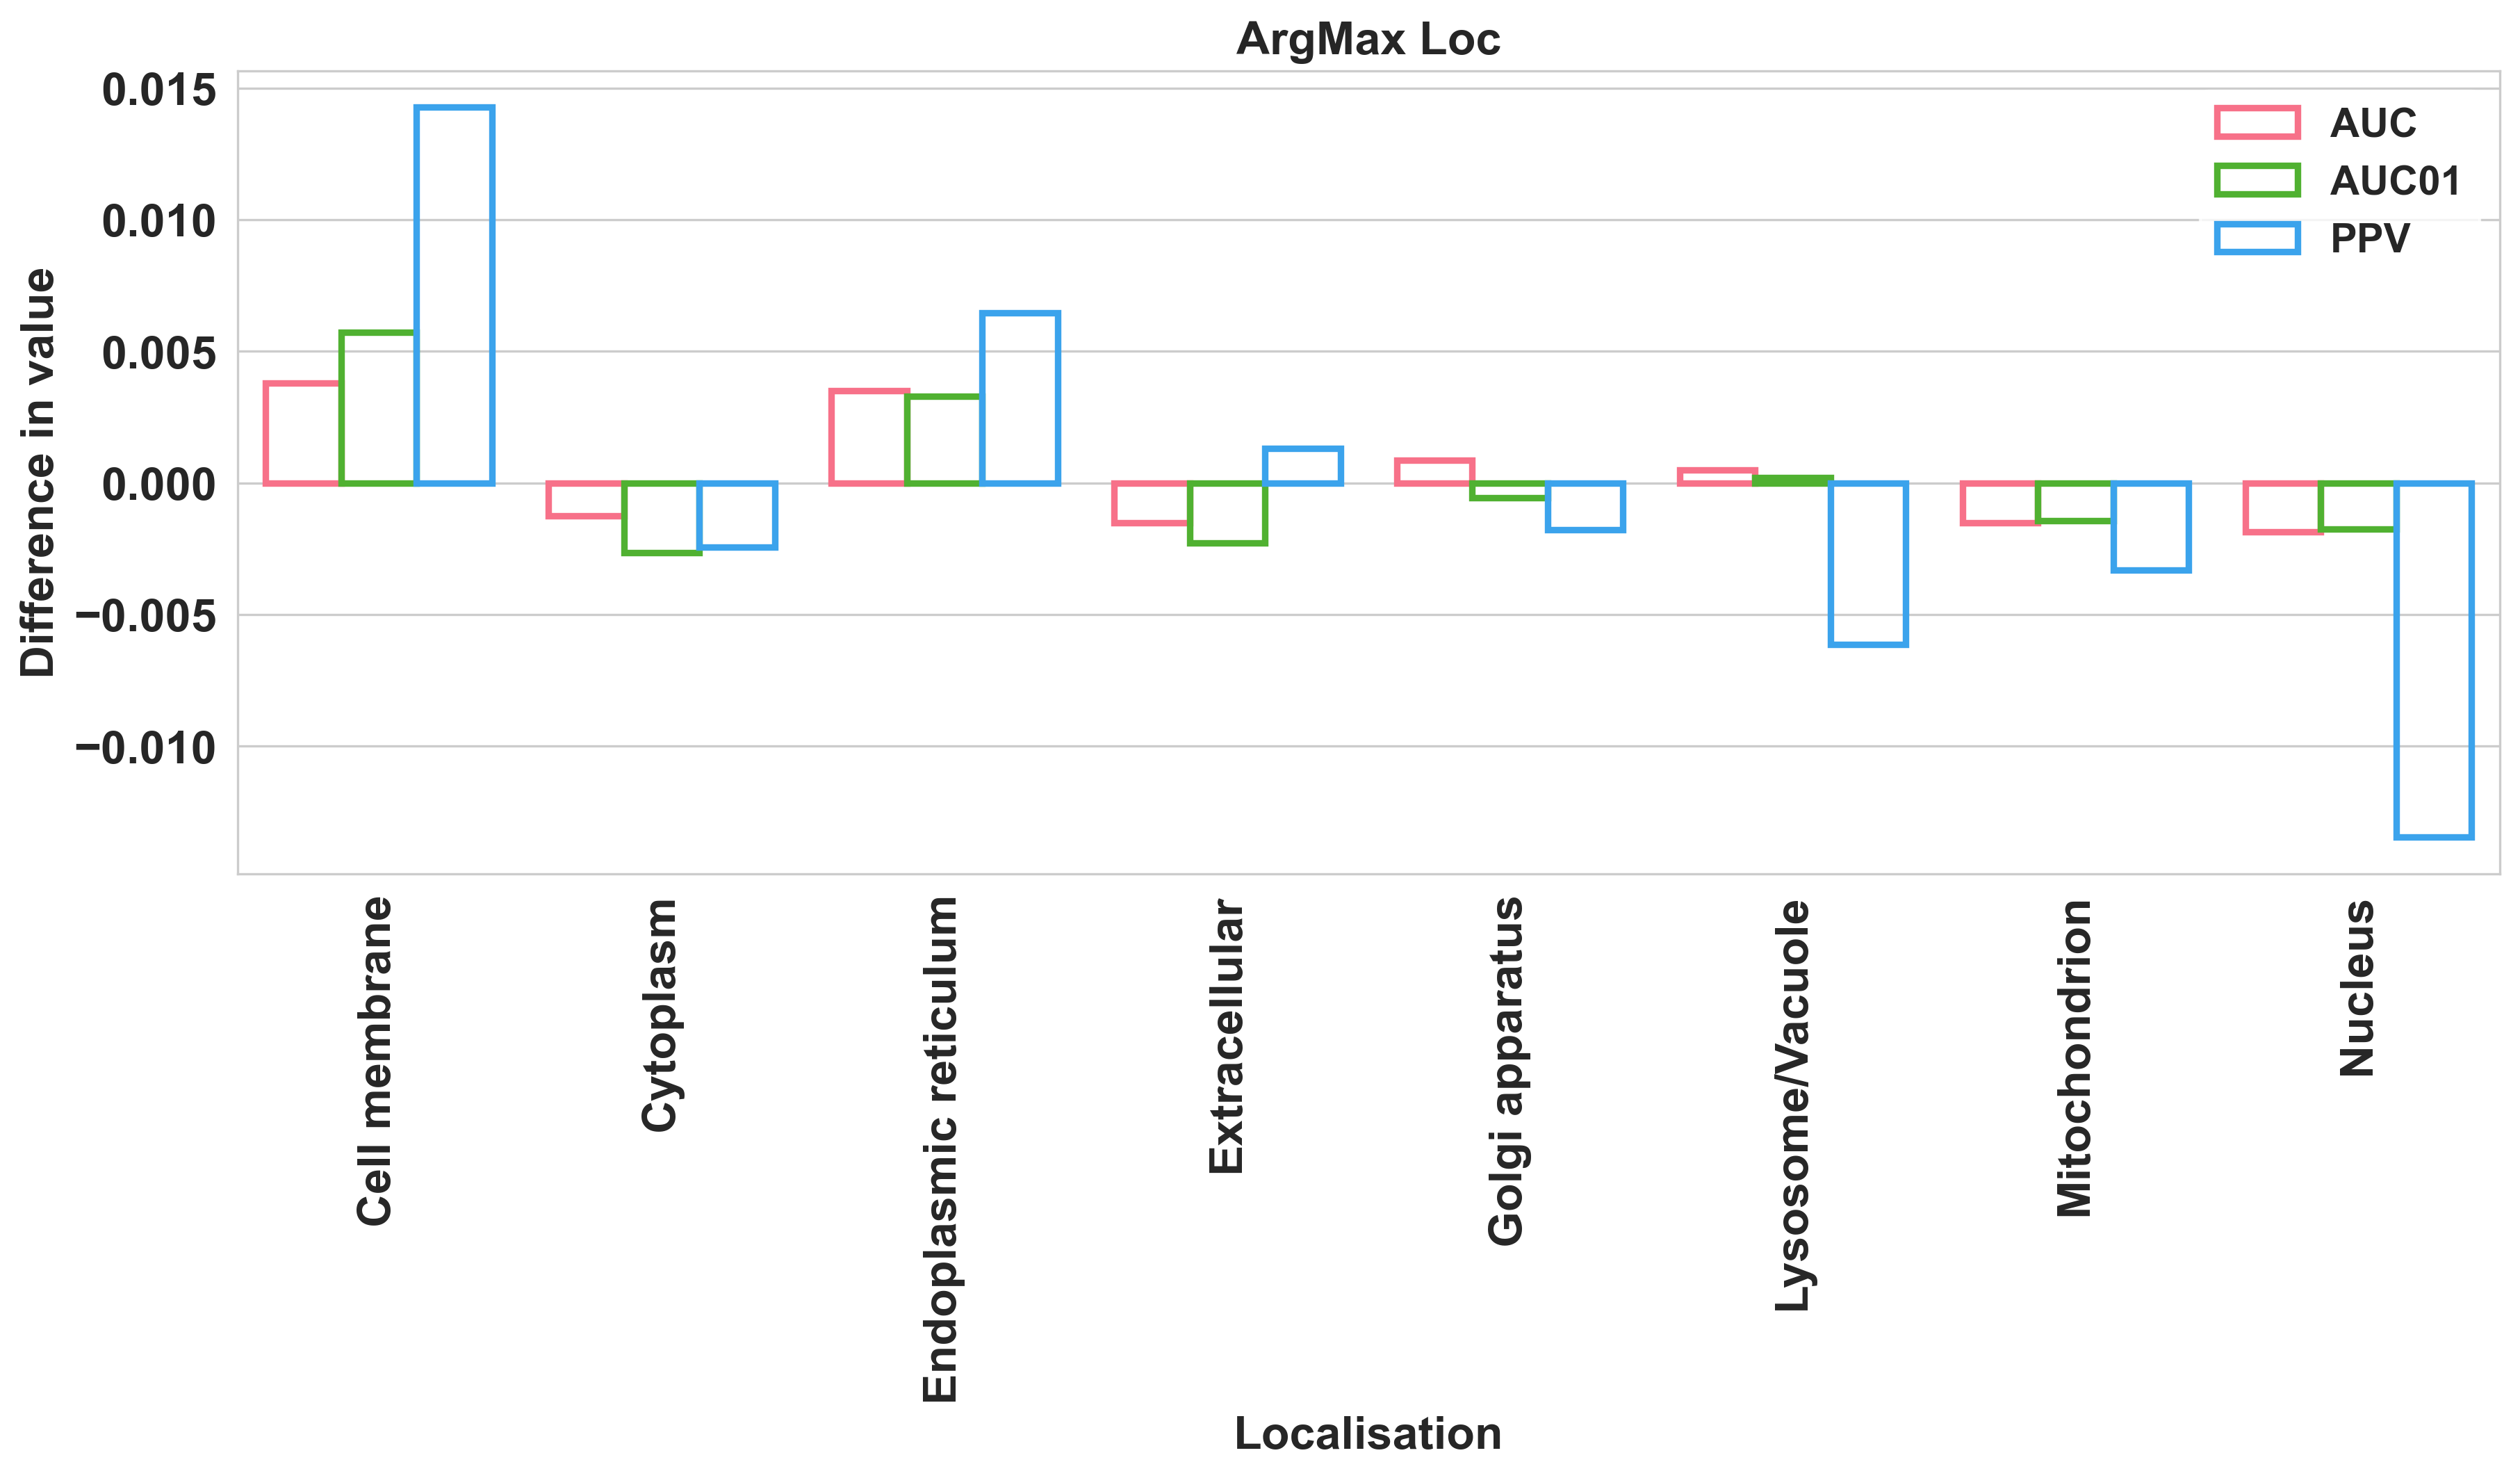

In [323]:
def make_bar(gbdf, value_cols = ['delta_AUC', 'delta_AUC01', 'delta_PPV'], filter=None,
            fs=16, fw='semibold', title=None, fn=None):
    idname=gbdf.index.name
    melted = gbdf.reset_index().melt(id_vars=[idname], value_vars=value_cols)
    if filter is not None:
        melted = melted.query(f'{idname} not in @filter')

    fig,ax = plt.subplots(1,1,figsize=(14,5))
    sns.barplot(melted.replace({'delta_AUC':'AUC',
                                'delta_AUC01':'AUC01',
                                'delta_PPV':'PPV'}),
                x=idname, y='value', hue='variable', fill=False)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight=fw, fontsize=fs, rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), fontweight=fw, fontsize=fs)
    ax.set_xlabel('Localisation', fontweight=fw, fontsize=fs)
    ax.set_ylabel('Difference in value', fontweight=fw, fontsize=fs)
    ax.legend(prop={'weight':fw, 'size':fs-2},  edgecolor='w')
    if title is not None:
        ax.set_title(title, fontweight=fw, fontsize=fs)
    if fn is not None:
        fig.savefig(fn, dpi=300, bbox_inches='tight')

make_bar(c, filter=['Plastid', 'Peroxisome'], title='ArgMax Loc')

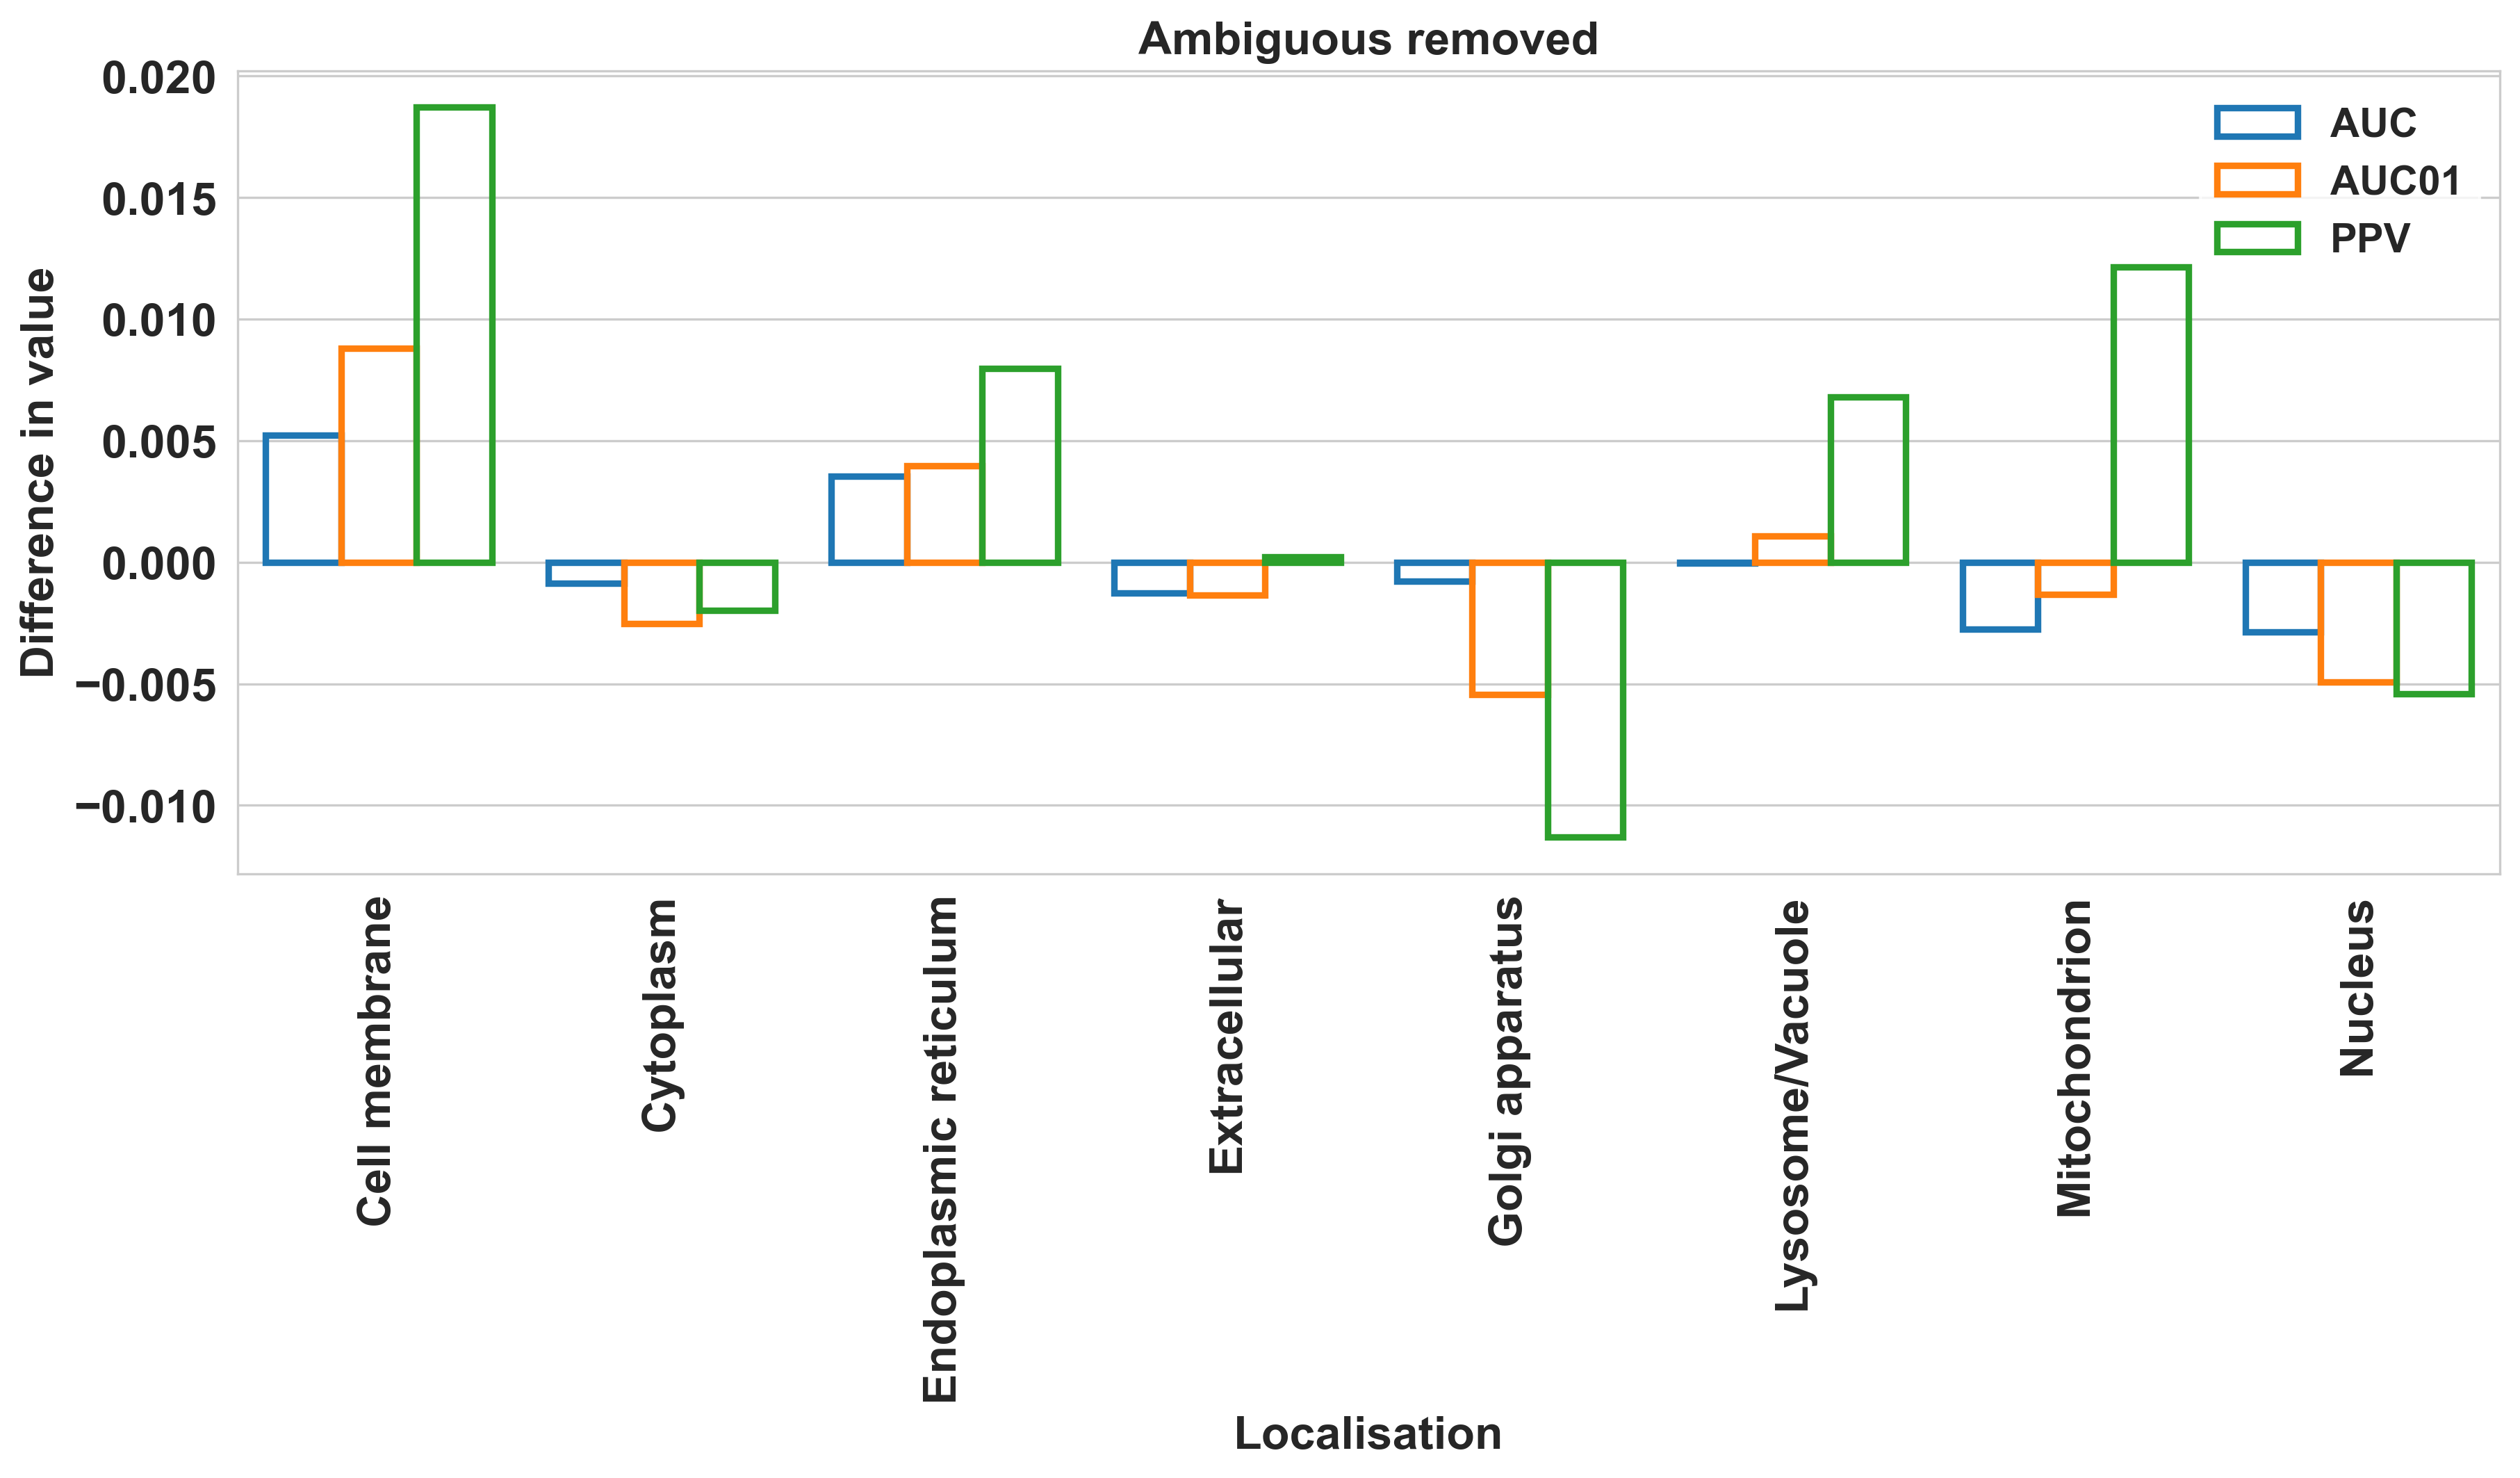

In [435]:
make_bar(a.drop([x for x in a.index if '|' in x]), filter=['Plastid', 'Peroxisome'], title='Ambiguous removed')

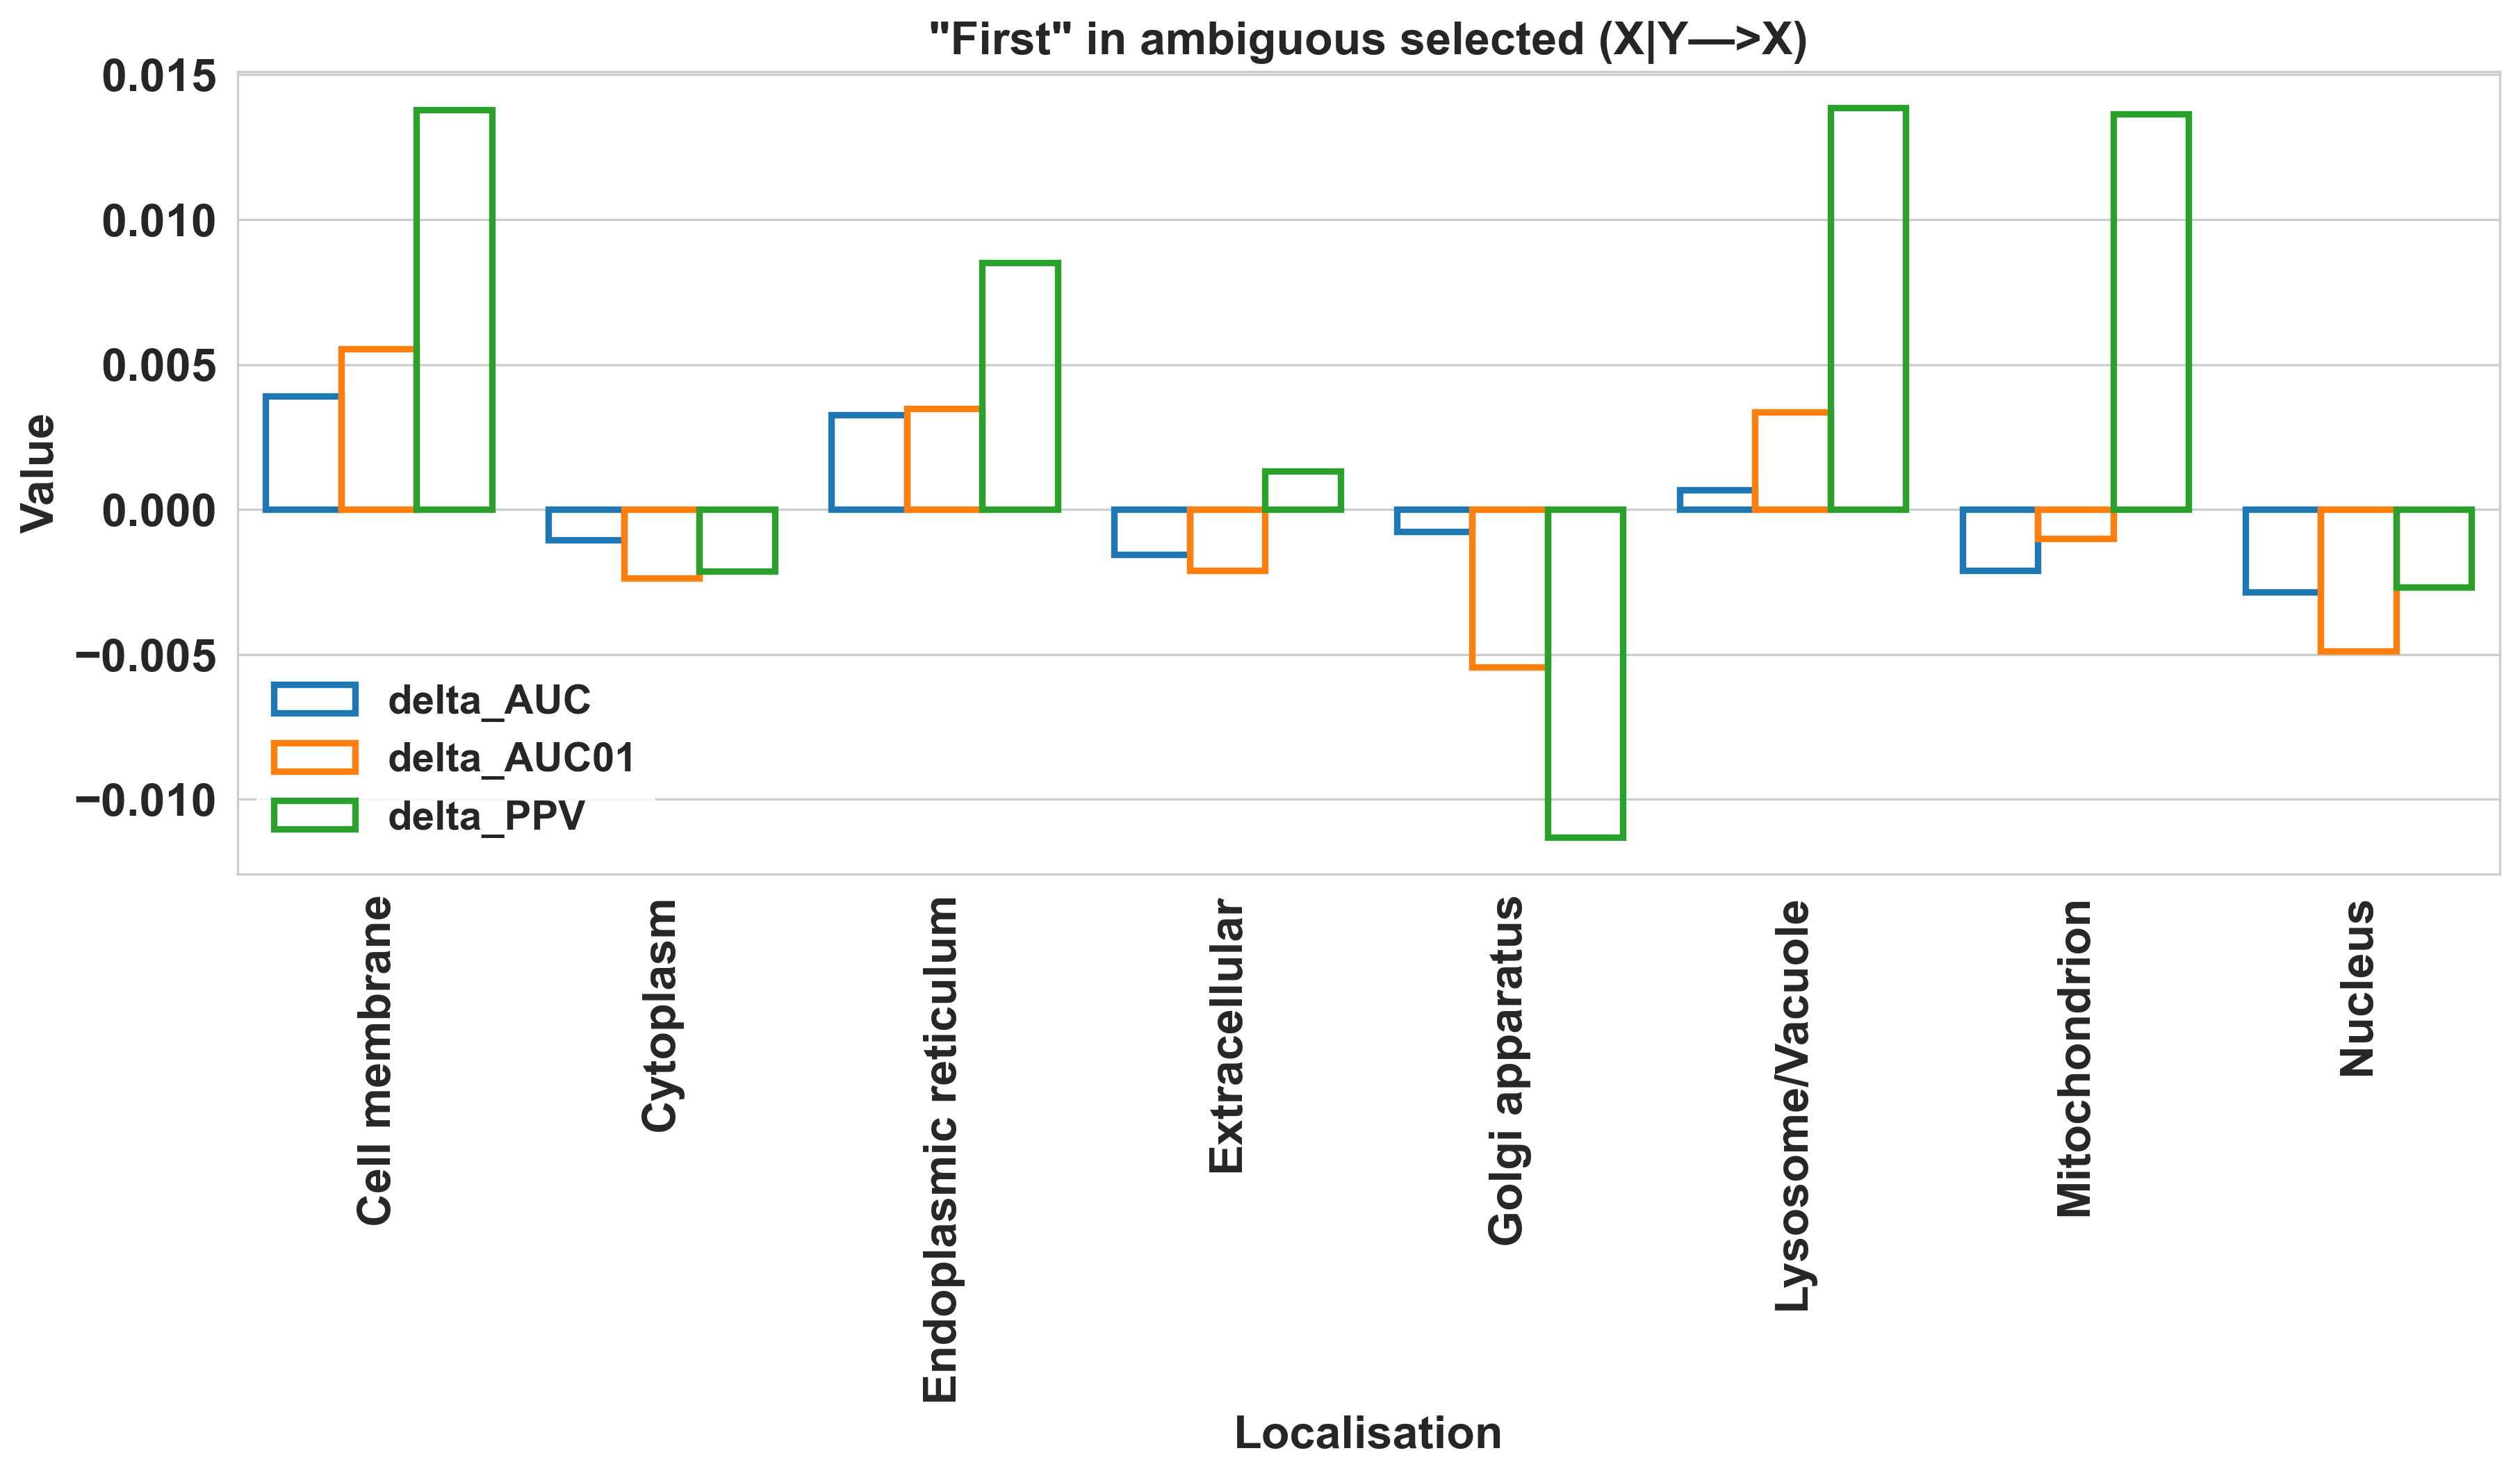

In [429]:
make_bar(b, filter=['Plastid', 'Peroxisome'], title='"First" in ambiguous selected (X|Y—>X)')

## Do by pathway instead

In [296]:
ensemble_preds_merged = pd.read_csv('../output/250327_HLA_DR_ensemble_preds_merged_loc.csv')

In [316]:
# cytosolic pathway : 
cyto_pw=['Nucleus', 'Cytoplasm', 'Mitochondrion', 'Peroxisome']
# endolysosomal pathway:
endo_pw=['Extracellular', 'cell membrane', 'Endoplastmic reticulum', 'Golgi apparatus', 'Lysosome/Vacuole']

def get_pw(loc):
    # cytosolic pathway : 
    cyto_pw=['Nucleus', 'Cytoplasm', 'Mitochondrion', 'Peroxisome']
    # endolysosomal pathway:
    endo_pw=['Extracellular', 'Cell membrane', 'Endoplasmic reticulum', 'Golgi apparatus', 'Lysosome/Vacuole']
    if '|' in loc:
        locs = loc.split('|')
        count_endo=0
        count_cyto=0
        for l in locs:
            if l in cyto_pw:
                count_cyto+=1
            elif l in endo_pw:
                count_endo+=1
        if (count_cyto!=0 and count_endo!=0):
            return 'ambiguous'
        if count_endo==0:
            return 'cytosolic'
        elif count_cyto==0:
            return 'endolysosomal'
        elif count_cyto==0 and count_endo==0:
            return 'wtf2'
    else:
        if loc in endo_pw:
            return 'endolysosomal'
        elif loc in cyto_pw:
            return 'cytosolic'
        else:
            return 'Plastid'

In [317]:
ensemble_preds_merged['pathway'] = ensemble_preds_merged['Localizations'].apply(get_pw)
ensemble_preds_merged.query('pathway=="wtf2"')[['Localizations', 'pathway']]

Empty DataFrame
Columns: [Localizations, pathway]
Index: []

In [318]:
def gb_auc(x, pred_col):
    try:
        return roc_auc_score(x['target'], x[pred_col])
    except:
        return np.nan

def gb_auc01(x, pred_col):
    try:
        return roc_auc_score(x['target'], x[pred_col], max_fpr=0.1)
    except:
        return np.nan

def gb_ppv(x, pred_col):
    # print(type(x), x)
    n_pos = len(x.query('target==1'))
    if n_pos==0:
        return np.nan
    head = x.sort_values(pred_col,ascending=False).head(n_pos)
    return len(head.query('target==1'))/n_pos

def get_merged_gb_auc(ensemble_preds_merged, gbcol='pathway'):
    counts = ensemble_preds_merged.groupby([gbcol]).agg(count=('rank','count'))
    n_pos = ensemble_preds_merged.groupby([gbcol]).agg(pos_count=('target','sum')).astype(int)
    counts = pd.merge(counts, n_pos, left_index=True, right_index=True)
    
    merged_auc = pd.merge(ensemble_preds_merged.groupby([gbcol]).apply(lambda x: gb_auc(x, pred_col='ensemble_pred_structure')).rename('AUC'),
                    ensemble_preds_merged.groupby([gbcol]).apply(lambda x: gb_auc(x, pred_col='ensemble_pred_baseline')).rename('AUC'),
                    left_index=True, right_index=True, suffixes=('_PosStruct','_baseline'))
    
    merged_auc01 = pd.merge(ensemble_preds_merged.groupby([gbcol]).apply(lambda x: gb_auc01(x, pred_col='ensemble_pred_structure')).rename('AUC01'),
                            ensemble_preds_merged.groupby([gbcol]).apply(lambda x: gb_auc01(x, pred_col='ensemble_pred_baseline')).rename('AUC01'),
                            left_index=True, right_index=True, suffixes=('_PosStruct','_baseline'))
    
    merged_ppv = pd.merge(ensemble_preds_merged.groupby([gbcol]).apply(lambda x: gb_ppv(x, pred_col='ensemble_pred_structure')).rename('PPV'),
                          ensemble_preds_merged.groupby([gbcol]).apply(lambda x: gb_ppv(x, pred_col='ensemble_pred_baseline')).rename('PPV'),
                          left_index=True, right_index=True, suffixes=('_PosStruct','_baseline'))
    merged = pd.merge(counts, merged_auc, left_index=True, right_index=True, how='right')
    merged['delta_AUC']=merged['AUC_PosStruct']-merged['AUC_baseline']
    
    merged = pd.merge(merged, merged_auc01, left_index=True, right_index=True, how='left')
    merged['delta_AUC01']=merged['AUC01_PosStruct']-merged['AUC01_baseline']
    
    merged = pd.merge(merged, merged_ppv, left_index=True, right_index=True, how='left')
    merged['delta_PPV']=merged['PPV_PosStruct']-merged['PPV_baseline']
    # merged['better']=merged['AUC_PosStruct']>merged['AUC_baseline']
    return merged.round(5)

In [382]:
xd=ensemble_preds_merged.query('Localizations=="Plastid"')
len(xd), len(xd['Prot_ID'].unique())

(26, 2)

In [327]:
cytosolic_subset = ensemble_preds_merged.query('pathway=="cytosolic"')
ambiguous_subset = ensemble_preds_merged.query('pathway=="ambiguous"')
endolyso_subset = ensemble_preds_merged.query('pathway=="endolysosomal"')

In [354]:
ensemble_preds_merged.to_csv('../output/2503XX_DeepLocAnalysis/250327_ensemble_preds_merged_loc.csv')

In [355]:
cytosolic_subset.to_csv('../output/2503XX_DeepLocAnalysis/250327_cytosolic_subset.csv')
ambiguous_subset.to_csv('../output/2503XX_DeepLocAnalysis/250327_ambiguous_subset.csv')
endolyso_subset.to_csv('../output/2503XX_DeepLocAnalysis/250327_endolysosomal_subset.csv')

In [359]:
from joblib import Parallel, delayed
from functools import partial
from tqdm.auto import tqdm

def bootstrap_single(df, seed, frac=1.0, replace=True):
    resample = df.sample(frac=frac, replace=replace, random_state=seed)
    npos = len(df.query('target==1'))
    topn_baseline = resample.sort_values('ensemble_pred_baseline', ascending=False).head(npos)
    topn_structure = resample.sort_values('ensemble_pred_structure', ascending=False).head(npos)
    
    return {'AUC_baseline': roc_auc_score(resample['target'].values, resample['ensemble_pred_baseline'].values),
            'AUC01_baseline': roc_auc_score(resample['target'].values, resample['ensemble_pred_baseline'].values, max_fpr=0.1),
            'PPV_baseline': len(topn_baseline.query('target==1'))/npos, 
            'AUC_structure': roc_auc_score(resample['target'].values, resample['ensemble_pred_structure'].values),
            'AUC01_structure': roc_auc_score(resample['target'].values, resample['ensemble_pred_structure'].values, max_fpr=0.1),
            'PPV_structure': len(topn_structure.query('target==1'))/npos}
            
def bootstrap_metrics(df, frac=1.0, replace=True, n_strap=100000, n_jobs=-1):
    wrapper = partial(bootstrap_single, df=df, frac=frac, replace=replace)
    output = Parallel(n_jobs=n_jobs)(delayed(wrapper)(seed=seed) for seed in tqdm(range(n_strap)))
    return pd.DataFrame(output)

cytosolic_subset_bootstrapped = bootstrap_metrics(cytosolic_subset, n_strap=10000, n_jobs=10)
ambiguous_subset_bootstrapped = bootstrap_metrics(ambiguous_subset, n_strap=10000, n_jobs=10)
endolyso_subset_bootstrapped = bootstrap_metrics(endolyso_subset, n_strap=10000, n_jobs=10)

cytosolic_subset_bootstrapped.to_csv('./cytosolic_subset_bootstrapped_results.csv')
ambiguous_subset_bootstrapped.to_csv('./ambiguous_subset_bootstrapped_results.csv')
endolyso_subset_bootstrapped.to_csv('./endolyso_subset_bootstrapped_results.csv')


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

NameError: name 'ambiguous_subset_baseline_bootstrapped' is not defined

In [378]:
print(len(cytosolic_subset), len(cytosolic_subset['Prot_ID'].unique()))
print(len(endolyso_subset), len(endolyso_subset['Prot_ID'].unique()))
print(len(ambiguous_subset), len(ambiguous_subset['Prot_ID'].unique()))

292363 17830
181269 10782
26342 1621


In [360]:

cytosolic_subset_bootstrapped.to_csv('./cytosolic_subset_bootstrapped_results.csv')
ambiguous_subset_bootstrapped.to_csv('./ambiguous_subset_bootstrapped_results.csv')
endolyso_subset_bootstrapped.to_csv('./endolyso_subset_bootstrapped_results.csv')


In [371]:
cytosolic_subset_bootstrapped['AUC_better'] = cytosolic_subset_bootstrapped['AUC_baseline'] < cytosolic_subset_bootstrapped['AUC_structure']
cytosolic_subset_bootstrapped['AUC01_better'] = cytosolic_subset_bootstrapped['AUC01_baseline'] < cytosolic_subset_bootstrapped['AUC01_structure']
cytosolic_subset_bootstrapped['PPV_better'] = cytosolic_subset_bootstrapped['PPV_baseline'] < cytosolic_subset_bootstrapped['PPV_structure']
endolyso_subset_bootstrapped['AUC_better'] = endolyso_subset_bootstrapped['AUC_baseline'] < endolyso_subset_bootstrapped['AUC_structure']
endolyso_subset_bootstrapped['AUC01_better'] = endolyso_subset_bootstrapped['AUC01_baseline'] < endolyso_subset_bootstrapped['AUC01_structure']
endolyso_subset_bootstrapped['PPV_better'] = endolyso_subset_bootstrapped['PPV_baseline'] < endolyso_subset_bootstrapped['PPV_structure']
ambiguous_subset_bootstrapped['AUC_better'] = ambiguous_subset_bootstrapped['AUC_baseline'] < ambiguous_subset_bootstrapped['AUC_structure']
ambiguous_subset_bootstrapped['AUC01_better'] = ambiguous_subset_bootstrapped['AUC01_baseline'] < ambiguous_subset_bootstrapped['AUC01_structure']
ambiguous_subset_bootstrapped['PPV_better'] = ambiguous_subset_bootstrapped['PPV_baseline'] < ambiguous_subset_bootstrapped['PPV_structure']

In [375]:
print(endolyso_subset_bootstrapped[['AUC_better', 'AUC01_better', 'PPV_better']].astype(int).sum())
print(cytosolic_subset_bootstrapped[['AUC_better', 'AUC01_better', 'PPV_better']].astype(int).sum())
print(ambiguous_subset_bootstrapped[['AUC_better', 'AUC01_better', 'PPV_better']].astype(int).sum())

AUC_better      10000
AUC01_better    10000
PPV_better      10000
dtype: int64
AUC_better       114
AUC01_better     104
PPV_better      4059
dtype: int64
AUC_better      362
AUC01_better      0
PPV_better      691
dtype: int64


In [432]:
ambiguous_subset_bootstrapped['id'] = [f'ID_{i:05}' for i in range(10000)]
strap_melted_ambi = ambiguous_subset_bootstrapped.melt(id_vars=['id'],
                                                  value_vars=['AUC_baseline', 'AUC01_baseline', 'PPV_baseline', 
                                                              'AUC_structure', 'AUC01_structure', 'PPV_structure']).assign(pathway='Ambiguous')
strap_melted_ambi['model'] = strap_melted_ambi['variable'].apply(lambda x: x.split('_')[1])
strap_melted_ambi['variable'] = strap_melted_ambi['variable'].apply(lambda x: x.split('_')[0])
cytosolic_subset_bootstrapped['id'] = [f'ID_{i:05}' for i in range(10000)]
strap_melted_cyto = cytosolic_subset_bootstrapped.melt(id_vars=['id'],
                                                  value_vars=['AUC_baseline', 'AUC01_baseline', 'PPV_baseline', 
                                                              'AUC_structure', 'AUC01_structure', 'PPV_structure']).assign(pathway='Cytosolic')
strap_melted_cyto['model'] = strap_melted_cyto['variable'].apply(lambda x: x.split('_')[1])
strap_melted_cyto['variable'] = strap_melted_cyto['variable'].apply(lambda x: x.split('_')[0])
endolyso_subset_bootstrapped['id'] = [f'ID_{i:05}' for i in range(10000)]
strap_melted_endo = endolyso_subset_bootstrapped.melt(id_vars=['id'],
                                                  value_vars=['AUC_baseline', 'AUC01_baseline', 'PPV_baseline', 
                                                              'AUC_structure', 'AUC01_structure', 'PPV_structure']).assign(pathway='Endolysosomal')
strap_melted_endo['model'] = strap_melted_endo['variable'].apply(lambda x: x.split('_')[1])
strap_melted_endo['variable'] = strap_melted_endo['variable'].apply(lambda x: x.split('_')[0])
melted_cat = pd.concat([strap_melted_endo, strap_melted_cyto, strap_melted_ambi])

In [507]:
melted_cat.to_csv('../output/2503XX_DeepLocAnalysis/melted_cat.csv')

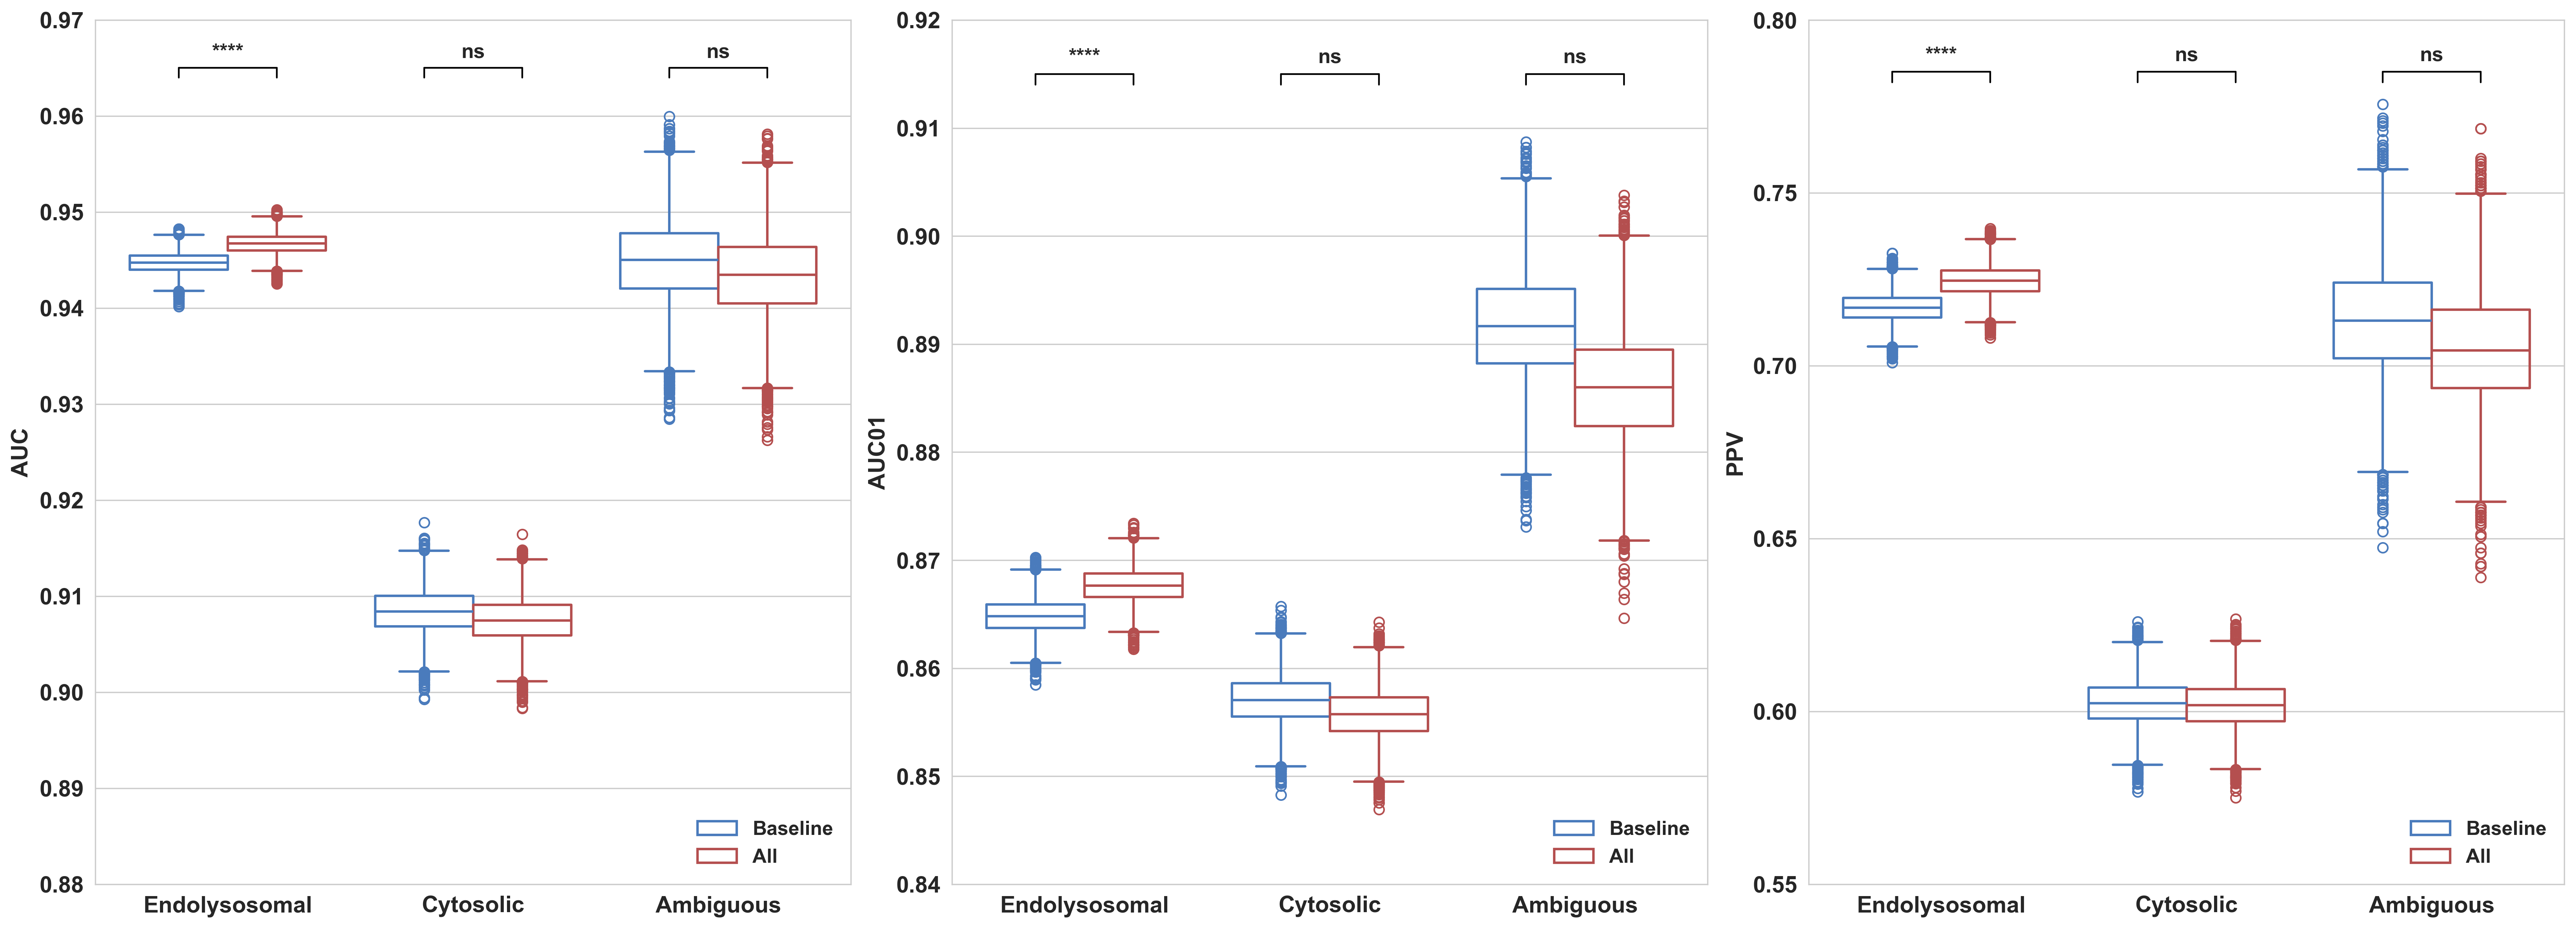

In [766]:
pal=sns.color_palette('vlag', 15)
sns.set_palette([pal[0], pal[-1]])
fig,ax = plt.subplots(1,3, figsize=(22,8))
fs=14
fw='semibold'
ylims = {'AUC':(0.88, .97), 
         'AUC01':(0.84, 0.92),
         'PPV':(0.55, 0.80)}
ydict = {0:0.965,
         1:0.915,
         2:0.785}

alpha=0.7
size=2.5
figsize=(18,10)
width=.8
saturation=1
swarm=True
fill=False

for i, variable in enumerate(melted_cat.variable.unique()):
    ax[i].set_ylim(ylims[variable])
    sns.boxplot(melted_cat.query('variable==@variable').replace({'structure':'All', 'baseline':'Baseline'}), 
                x='pathway', y='value', hue='model', ax=ax[i], fill=False,
               saturation = saturation)
    # sns.swarmplot(melted_cat.query('variable==@variable'), x='pathway', y='value', hue='model', ax=ax[i], dodge=True, size=.75,
    #                   alpha=min(1,alpha*2), legend=False)
    for patch in [x for x in ax[i].patches if type(x).__name__=='PathPatch']:
        patch.set_alpha(alpha)
    ax[i].set_ylabel(variable, fontsize=fs, fontweight=fw)
    ax[i].set_xlabel(None, fontsize=fs, fontweight=fw)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=fs, fontweight=fw)
    ax[i].set_yticklabels(ax[i].get_yticklabels(), fontsize=fs, fontweight=fw)
    ax[i].legend(prop={'weight':fw, 'size':fs-2}, loc='lower right', edgecolor='w')

    delta_y = 0.001 if i!=2 else 0.003
    ax[i].text(x=0, y=ydict[i]+delta_y, s='****', va='baseline', ha='center', fontweight=fw, fontsize=fs-1.5)
    ax[i].text(x=1, y=ydict[i]+delta_y, s='ns', va='baseline', ha='center', fontweight=fw, fontsize=fs-1.5)
    ax[i].text(x=2, y=ydict[i]+delta_y, s='ns', va='baseline', ha='center', fontweight=fw, fontsize=fs-1.5)
    ax[i].plot([0-(0.4/2), 0+(0.4/2)], [ydict[i], ydict[i]], lw=1.05, c='k')
    ax[i].plot([1-(0.4/2), 1+(0.4/2)], [ydict[i], ydict[i]], lw=1.05, c='k')
    ax[i].plot([2-(0.4/2), 2+(0.4/2)], [ydict[i], ydict[i]], lw=1.05, c='k')
    ax[i].plot([0-(0.4/2), 0-(0.4/2)], [ydict[i]-delta_y, ydict[i]], lw=1.05, c='k')
    ax[i].plot([0+(0.4/2), 0+(0.4/2)], [ydict[i]-delta_y, ydict[i]], lw=1.05, c='k')
    ax[i].plot([1-(0.4/2), 1-(0.4/2)], [ydict[i]-delta_y, ydict[i]], lw=1.05, c='k')
    ax[i].plot([1+(0.4/2), 1+(0.4/2)], [ydict[i]-delta_y, ydict[i]], lw=1.05, c='k')
    ax[i].plot([2-(0.4/2), 2-(0.4/2)], [ydict[i]-delta_y, ydict[i]], lw=1.05, c='k')
    ax[i].plot([2+(0.4/2), 2+(0.4/2)], [ydict[i]-delta_y, ydict[i]], lw=1.05, c='k')

fig.tight_layout()
fig.savefig('../../../writing/pynnalign_draft/figure/250328_Pathway_Metrics.png', dpi=300, bbox_inches='tight')

In [496]:
make_box??

Signature:
make_box(
    df,
    figsize=(12, 7),
    saturation=0.8,
    alpha=0.8,
    width=0.8,
    size=1,
    swarm=False,
    fill=True,
    fn=None,
    od='../output/250218_StructAll_results_REREDONE/',
)
Docstring: <no docstring>
Source:   
def make_box(df, figsize=(12,7), saturation=0.8, alpha=0.8, 
             width=0.8, size=1, swarm=False, fill=True, fn=None, od='../output/250218_StructAll_results_REREDONE/'):
    # df stuff
    fs = 16
    fw = 'semibold'
    pvals = do_binom(df)
    sigs = pvals.applymap(lambda x: 'ns' if x > 0.05 else 
                                    '****' if x <= 0.0001 else 
                                    '***' if x <= 0.001 else 
                                    '**' if x <= 0.01 else 
                                    '*')
    sigs = pd.concat([pd.DataFrame({'auc_pval':'None', 'auc01_pval':'None', 'ppv_pval':'None'}, 
                                   index=['baseline']),
                     sigs])
    tmp = df.melt(id_vars=['mode

# Change struct values

In [60]:
test_2['seq_id'] = [f'SEQ_{i:07}' for i in range(len(test_2))]
re_merged=pd.merge(test_2.reset_index(), ensemble_preds_structure, how='left',
         left_on=['seq_id', 'sequence', 'MHC', 'sample', 'target', 'Prot_ID'],
         right_on=['seq_id', 'sequence', 'MHC', 'sample', 'target', 'Prot_ID'])

In [72]:
test2_top10k.columns

Index(['index', 'target', 'sequence', 'MHC', 'Unnamed: 0', 'binding_core',
       'rank_prediction', 'sample', 'mhc_reliability', 'Prot_ID',
       'prot_seq_start', 'rsa', 'pq3_H', 'pq3_E', 'pq3_C', 'disorder', 'split',
       'fold', 'mean_rsa', 'mean_disorder', 'mean_pq3_H', 'mean_pq3_E',
       'mean_pq3_C', 'seq_id', 'ensemble_pred', 'rank', 'mhc_rel'],
      dtype='object')

In [71]:
test2_top10k = re_merged.query('target==1').sort_values('ensemble_pred', ascending=False).head(10000)

In [43]:
def modify_struct(x, p=1.0):
    return ','.join([str(x) for x in (np.array([float(z) for z in x.split(',')]) * p)])

In [76]:
%mkdir ../data/NetMHCII_EL_jonas/modified_struct/
for c,p in zip(['rsa', 'pq3_H', 'pq3_E', 'pq3_C', 'disorder'],
               [1.5, 1.5, 0.5, 0.5, 1.5]):
    wtf = test2_top10k.copy()
    wtf[f'mod_{c}'] = wtf[c].apply(modify_struct, p=p)
    wtf.drop(columns=[c]).rename(columns={f'mod_{c}':c})\
                .to_csv(f'../data/NetMHCII_EL_jonas/modified_struct/250327_HLA_DR_test_top10k_modified_{c}.csv', index=False)

mkdir: ../data/NetMHCII_EL_jonas/modified_struct/: File exists


In [767]:
%mkdir ../data/NetMHCII_EL_jonas/modified_struct/
for c,p in zip(['rsa', 'pq3_H', 'pq3_E', 'pq3_C', 'disorder'],
               [0,0,0,0,0]):
    wtf = test2_top10k.copy()
    wtf[f'mod_{c}'] = wtf[c].apply(modify_struct, p=p)
    wtf.drop(columns=[c]).rename(columns={f'mod_{c}':c})\
                .to_csv(f'../data/NetMHCII_EL_jonas/modified_struct/250327_HLA_DR_test_top10k_zeroed_{c}.csv', index=False)

mkdir: ../data/NetMHCII_EL_jonas/modified_struct/: File exists


In [77]:
pd.read_csv('../data/NetMHCII_EL_jonas/modified_struct/250327_HLA_DR_test_top10k_modified_disorder.csv').columns

Index(['index', 'target', 'sequence', 'MHC', 'Unnamed: 0', 'binding_core',
       'rank_prediction', 'sample', 'mhc_reliability', 'Prot_ID',
       'prot_seq_start', 'rsa', 'pq3_H', 'pq3_E', 'pq3_C', 'split', 'fold',
       'mean_rsa', 'mean_disorder', 'mean_pq3_H', 'mean_pq3_E', 'mean_pq3_C',
       'seq_id', 'ensemble_pred', 'rank', 'mhc_rel', 'disorder'],
      dtype='object')

In [65]:
%ls ../data/NetMHCII_EL_jonas/modified_struct/

250327_HLA_DR_test_top10k_modified_disorder.csv
250327_HLA_DR_test_top10k_modified_pq3_C.csv
250327_HLA_DR_test_top10k_modified_pq3_E.csv
250327_HLA_DR_test_top10k_modified_pq3_H.csv
250327_HLA_DR_test_top10k_modified_rsa.csv


In [534]:
mod_disorder = pd.read_csv('../output/250327_mod_struct_preds/mod_disorder_KFold_-1_250327_1256_Pyu6Tv/test_predictions_CONCAT_250327_HLA_DR_test_top10k_modified_disorder_mod_disorder_KFold_-1_250327_1256_Pyu6Tv.csv')
mod_rsa = pd.read_csv('../output/250327_mod_struct_preds/mod_rsa_KFold_-1_250327_1256_cSsPf5/test_predictions_CONCAT_250327_HLA_DR_test_top10k_modified_rsa_mod_rsa_KFold_-1_250327_1256_cSsPf5.csv')
mod_pq3_h = pd.read_csv('../output/250327_mod_struct_preds/mod_pq3_H_KFold_-1_250327_1257_HGEerj/test_predictions_CONCAT_250327_HLA_DR_test_top10k_modified_pq3_H_mod_pq3_H_KFold_-1_250327_1257_HGEerj.csv')
mod_pq3_c = pd.read_csv('../output/250327_mod_struct_preds/mod_pq3_C_KFold_-1_250327_1258_EzED4X/test_predictions_CONCAT_250327_HLA_DR_test_top10k_modified_pq3_C_mod_pq3_C_KFold_-1_250327_1258_EzED4X.csv')
mod_pq3_e = pd.read_csv('../output/250327_mod_struct_preds/mod_pq3_E_KFold_-1_250327_1257_EVdUY4/test_predictions_CONCAT_250327_HLA_DR_test_top10k_modified_pq3_E_mod_pq3_E_KFold_-1_250327_1257_EVdUY4.csv')


In [535]:
mod_disorder['seq_id'] = list(range(10000)) * 5
mod_rsa['seq_id'] = list(range(10000)) * 5
mod_pq3_h['seq_id'] = list(range(10000)) * 5
mod_pq3_c['seq_id'] = list(range(10000)) * 5
mod_pq3_e['seq_id'] = list(range(10000)) * 5

In [536]:
mod_rsa = mod_rsa.groupby(['seq_id', 'target', 'sequence', 'binding_core','rank_prediction','sample','mhc_reliability','Prot_ID', 'rank','mhc_rel','ensemble_pred']).agg(mean_pred=('pred', 'mean')).reset_index().rename(columns={'ensemble_pred':'old_pred', 'mean_pred':'modified_pred'})
mod_disorder = mod_disorder.groupby(['seq_id', 'target', 'sequence', 'binding_core','rank_prediction','sample','mhc_reliability','Prot_ID', 'rank','mhc_rel','ensemble_pred']).agg(mean_pred=('pred', 'mean')).reset_index().rename(columns={'ensemble_pred':'old_pred', 'mean_pred':'modified_pred'})
mod_pq3_h = mod_pq3_h.groupby(['seq_id', 'target', 'sequence', 'binding_core','rank_prediction','sample','mhc_reliability','Prot_ID', 'rank','mhc_rel','ensemble_pred']).agg(mean_pred=('pred', 'mean')).reset_index().rename(columns={'ensemble_pred':'old_pred', 'mean_pred':'modified_pred'})
mod_pq3_c = mod_pq3_c.groupby(['seq_id', 'target', 'sequence', 'binding_core','rank_prediction','sample','mhc_reliability','Prot_ID', 'rank','mhc_rel','ensemble_pred']).agg(mean_pred=('pred', 'mean')).reset_index().rename(columns={'ensemble_pred':'old_pred', 'mean_pred':'modified_pred'})
mod_pq3_e = mod_pq3_e.groupby(['seq_id', 'target', 'sequence', 'binding_core','rank_prediction','sample','mhc_reliability','Prot_ID', 'rank','mhc_rel','ensemble_pred']).agg(mean_pred=('pred', 'mean')).reset_index().rename(columns={'ensemble_pred':'old_pred', 'mean_pred':'modified_pred'})

(0.7, 1.0)

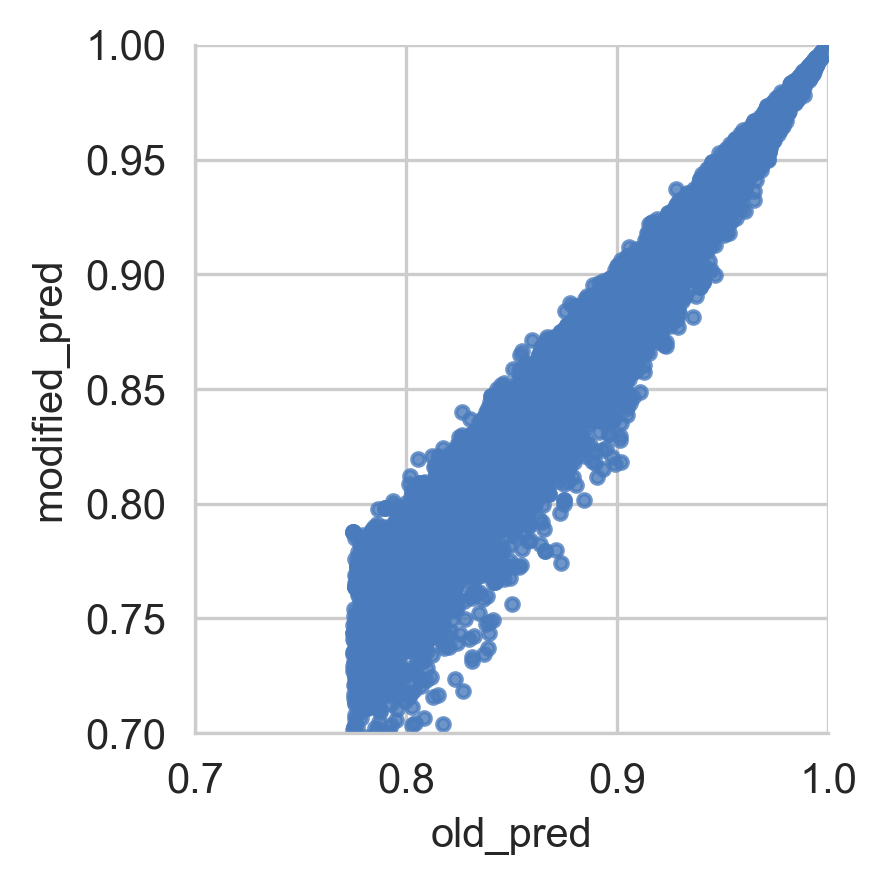

In [548]:

sns.lmplot(data= mod_rsa, x='old_pred', y='modified_pred', markers='.', height=3, aspect=1)
plt.ylim([0.7,1.0])
plt.xlim([0.7,1.0])

(0.7, 1.0)

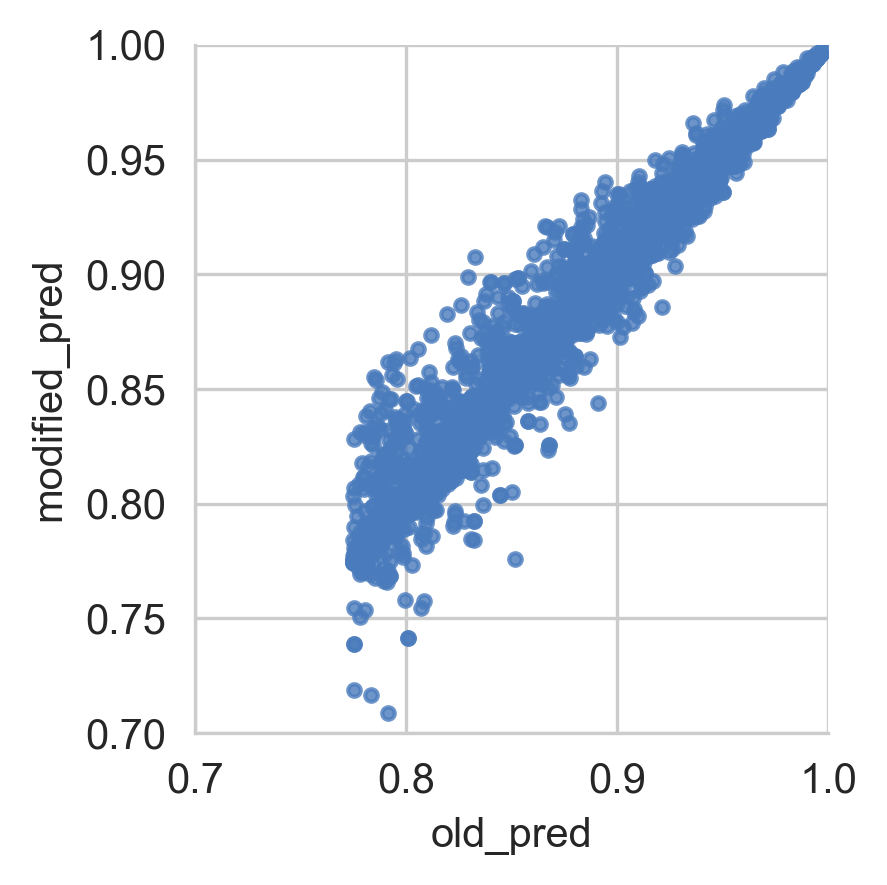

In [549]:

sns.lmplot(data= mod_disorder, x='old_pred', y='modified_pred', markers='.', height=3, aspect=1)
plt.ylim([0.7,1.0])
plt.xlim([0.7,1.0])

(0.7, 1.0)

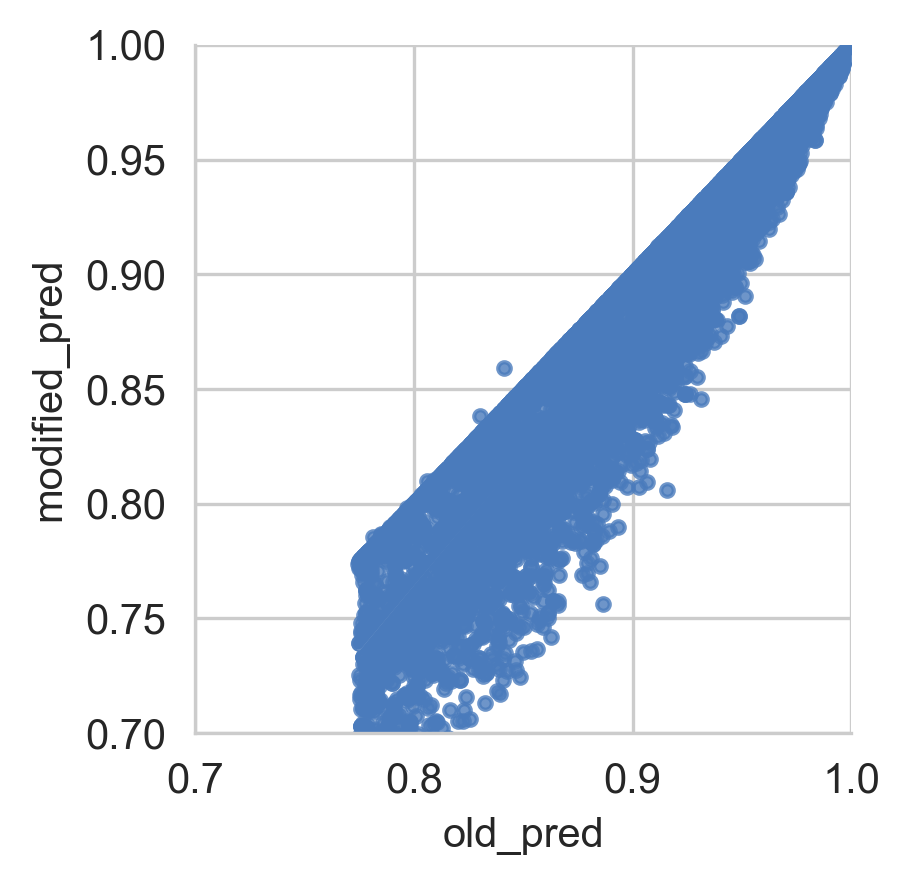

In [551]:

sns.lmplot(data= mod_pq3_e, x='old_pred', y='modified_pred', markers='.', height=3, aspect=1)
plt.ylim([0.7,1.0])
plt.xlim([0.7,1.0])

In [558]:
mod_pq3_e.columns

Index(['seq_id', 'target', 'sequence', 'binding_core', 'rank_prediction',
       'sample', 'mhc_reliability', 'Prot_ID', 'rank', 'mhc_rel', 'old_pred',
       'modified_pred'],
      dtype='object')

In [590]:
sns.regplot??

Signature:
sns.regplot(
    data=None,
    *,
    x=None,
    y=None,
    x_estimator=None,
    x_bins=None,
    x_ci='ci',
    scatter=True,
    fit_reg=True,
    ci=95,
    n_boot=1000,
    units=None,
    seed=None,
    order=1,
    logistic=False,
    lowess=False,
    robust=False,
    logx=False,
    x_partial=None,
    y_partial=None,
    truncate=True,
    dropna=True,
    x_jitter=None,
    y_jitter=None,
    label=None,
    color=None,
    marker='o',
    scatter_kws=None,
    line_kws=None,
    ax=None,
)
Docstring:
Plot data and a linear regression model fit.

There are a number of mutually exclusive options for estimating the
regression model. See the :ref:`tutorial <regression_tutorial>` for more
information.    

Parameters
----------
x, y: string, series, or vector array
    Input variables. If strings, these should correspond with column names
    in ``data``. When pandas objects are used, axes will be labeled with
    the series name.
data : DataFrame
    Tidy ("long-

y = 0.986x + 0.014 R² = 0.985


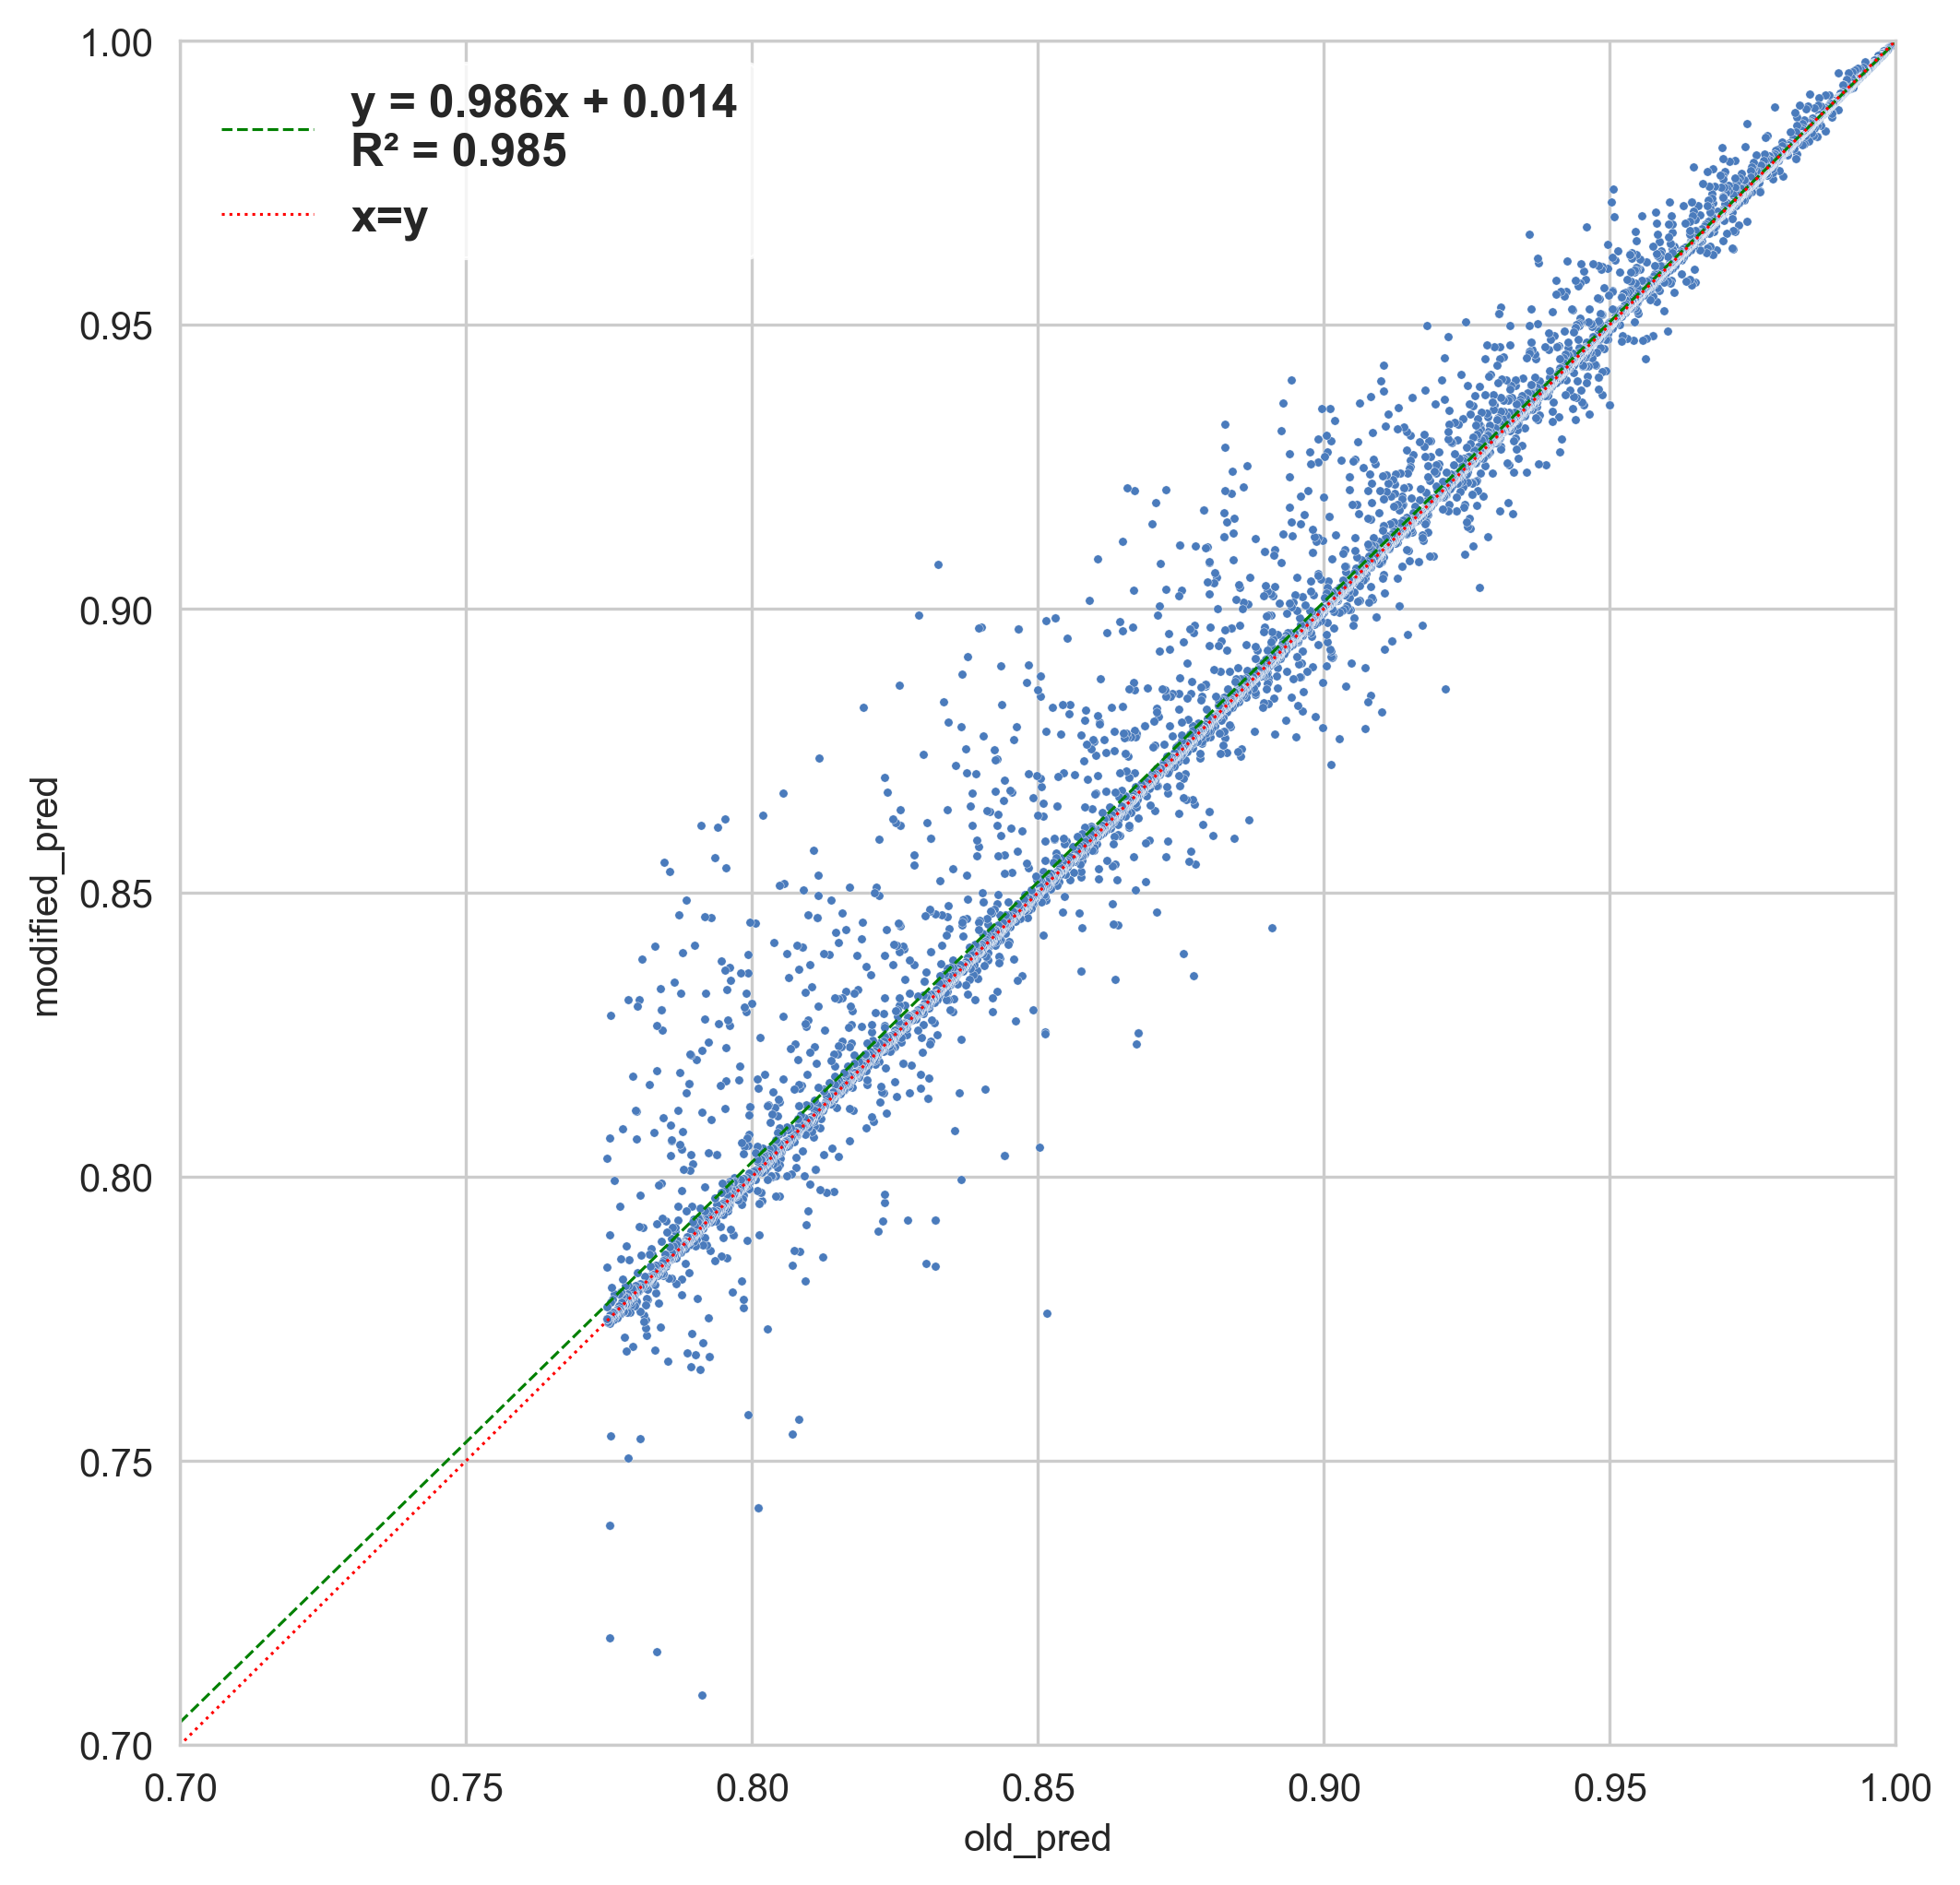

In [686]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress


def make_scatter_reg(df, fig=None, ax=None, 
                     x='old_pred', y='modified_pred',
                     figsize=(8,8), lims=[0.7, 1.0],
                     markers='o', s=1.25, linewidth=0.1, edgecolor='w',
                     ls='--', lw=0.75, c='g', 
                     title=None, fn=None):
         
    # Example dataframe with x, y columns
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=figsize)
    # Create an lmplot (returns a FacetGrid object)
    sns.scatterplot(data=df, x=x, y=y, ax=ax,
                    s=s, markers=markers, linewidth=linewidth, edgecolor=edgecolor)
                        #line_kws={'color':'red', 'linewidth':0.5, 'linestyle':'--'}, 
                        # scatter_kws={"s": 0.5, 'linewidths':0.25, 'marker':'x'})
    
    # Calculate regression stats using linregress
    slope, intercept, r_value, p_value, std_err = linregress(df[x], df[y])
    
    # Prepare the line equation and R² text
    line_eq = f"y = {slope:.3f}x + {intercept:.3f}"
    r2_text = f"R² = {r_value**2:.3f}"
    
    print(line_eq, r2_text)
   
    xs = np.linspace(lims[0], lims[1], 1000)
    ys = [slope*i + intercept for i in xs]
    ax.plot(xs, ys, c=c, lw=lw, ls=ls, label=f'{line_eq}'+f'\n{r2_text}')
    ax.plot([0,1],[0,1], c='r', ls=':', lw=lw, label='x=y')

    ax.set_ylim(lims)
    ax.set_xlim(lims)
    ax.legend(prop={'weight':'semibold', 'size':12}, edgecolor='w')
    if title is not None:
        ax.set_title(title, fontweight='semibold', fontsize=14)
    if fn is not None:
        fig.savefig(fn, dpi='300', bbox_inches='tight')

make_scatter_reg(mod_disorder, markers='.', s=5, linewidth=0.1, edgecolor='w',
                 lims=[0.7, 1])

In [699]:
mod_disorder['delta_score'] = mod_disorder['old_pred']-mod_disorder['modified_pred']
mod_rsa['delta_score'] = mod_rsa['old_pred']-mod_rsa['modified_pred']
mod_pq3_c['delta_score'] = mod_pq3_c['old_pred']-mod_pq3_c['modified_pred']
mod_pq3_e['delta_score'] = mod_pq3_e['old_pred']-mod_pq3_e['modified_pred']
mod_pq3_h['delta_score'] = mod_pq3_h['old_pred']-mod_pq3_h['modified_pred']

In [712]:
from scipy.stats import ttest_rel, ttest_ind

print(ttest_rel(mod_disorder['old_pred'], mod_disorder['modified_pred']))
print(ttest_ind(mod_disorder['old_pred'], mod_disorder['modified_pred']))

TtestResult(statistic=-15.537941057862056, pvalue=8.156409995696094e-54, df=9999)
TtestResult(statistic=-1.3423826610605514, pvalue=0.17948719194507703, df=19998.0)


In [733]:
def do_both_t(df):
    direction = 'greater' if df['old_pred'].mean()>df['modified_pred'].mean() else 'less'
    p_rel = ttest_rel(df['old_pred'], df['modified_pred'], alternative=direction).pvalue
    p_ind = ttest_ind(df['old_pred'], df['modified_pred'], alternative=direction).pvalue

    sig_rel = '****' if p_rel<0.0001 else\
              '***' if p_rel<0.001 else\
              '**' if p_rel<0.01 else\
              '*' if p_rel<0.05 else\
              'ns'

    sig_ind = '****' if p_ind<0.0001 else\
          '***' if p_ind<0.001 else\
          '**' if p_ind<0.01 else\
          '*' if p_ind<0.05 else\
          'ns'
    return sig_ind

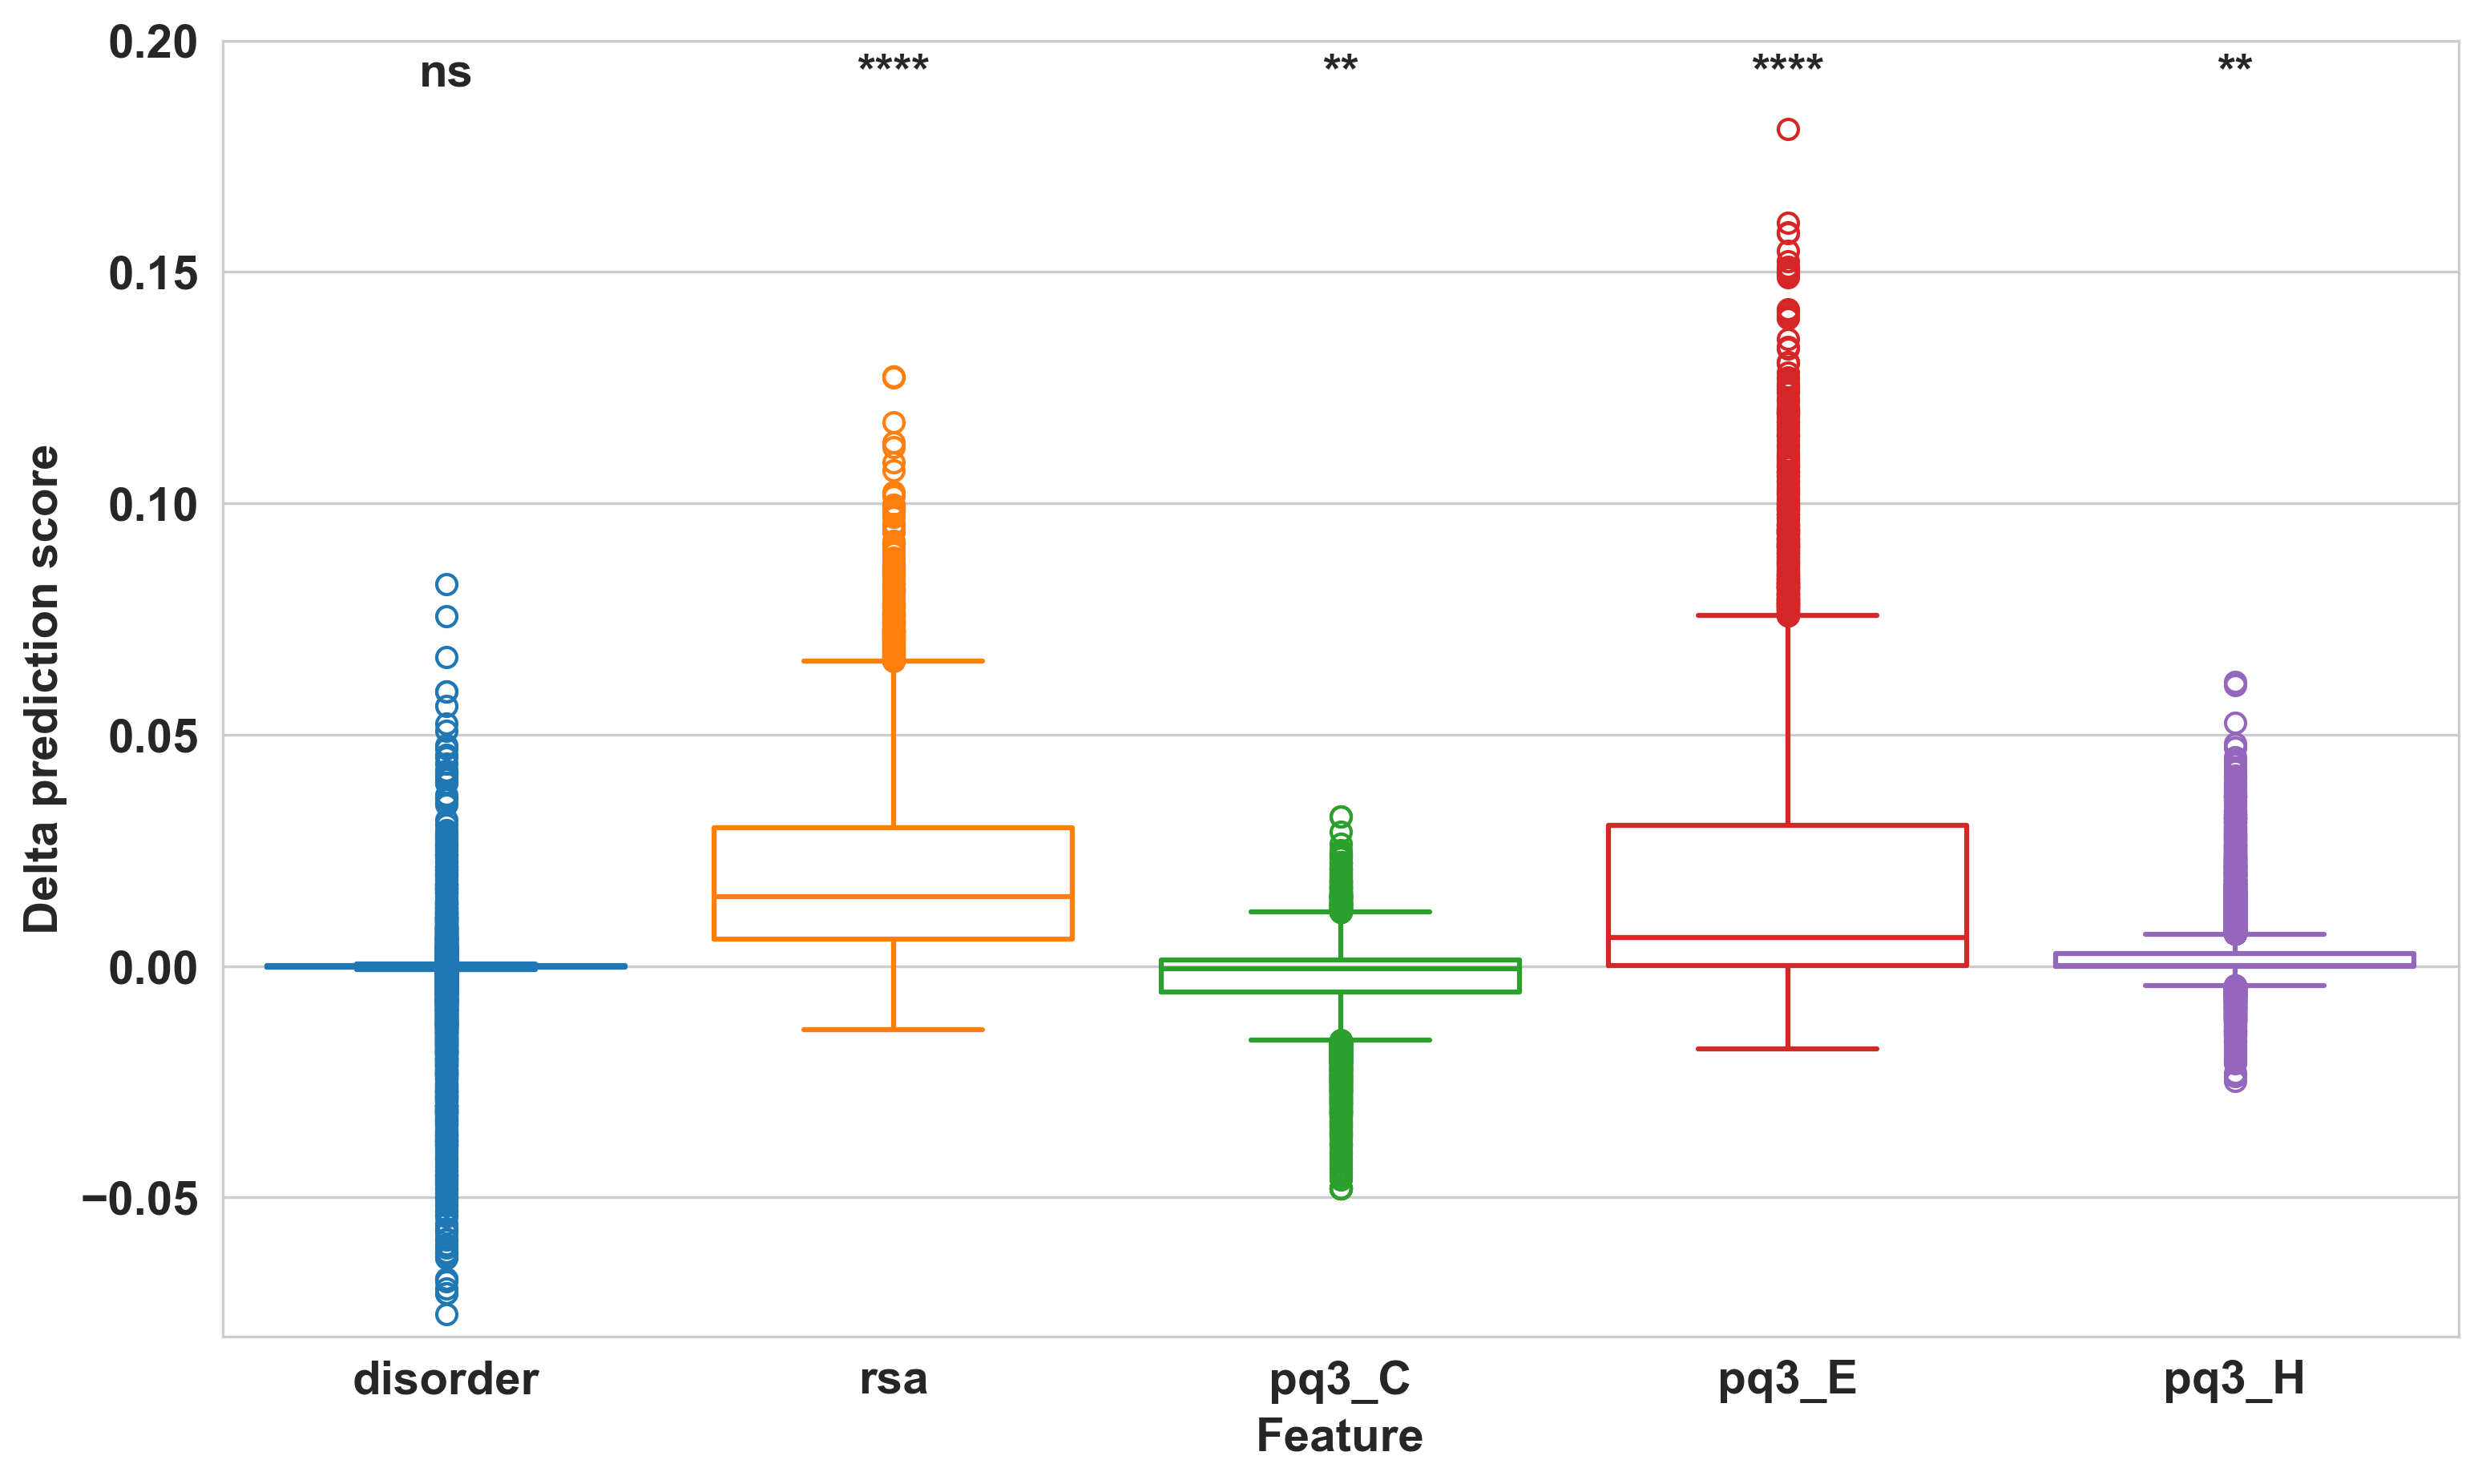

In [737]:
mod_scores = pd.concat([mod_disorder.assign(modified='disorder'),
                        mod_rsa.assign(modified='rsa'), 
                        mod_pq3_c.assign(modified='pq3_C'),
                        mod_pq3_e.assign(modified='pq3_E'),
                        mod_pq3_h.assign(modified='pq3_H'), 
                        ])
sns.set_palette('tab10', 5)
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.set_ylim([-0.08, 0.2])
sns.boxplot(mod_scores, fill=False, y='delta_score', x='modified', hue='modified', 
            order=['disorder', 'rsa', 'pq3_C', 'pq3_E', 'pq3_H'])

fw='semibold'
fs=14
ax.text(x=0, y=0.19, s=do_both_t(mod_disorder), ha='center', va='baseline', fontweight=fw, fontsize=fs)
ax.text(x=1, y=0.19, s=do_both_t(mod_rsa), ha='center', va='baseline', fontweight=fw, fontsize=fs)
ax.text(x=2, y=0.19, s=do_both_t(mod_pq3_c), ha='center', va='baseline', fontweight=fw, fontsize=fs)
ax.text(x=3, y=0.19, s=do_both_t(mod_pq3_e), ha='center', va='baseline', fontweight=fw, fontsize=fs)
ax.text(x=4, y=0.19, s=do_both_t(mod_pq3_h), ha='center', va='baseline', fontweight=fw, fontsize=fs)
ax.set_ylabel('Delta prediction score', fontweight=fw, fontsize=fs)
ax.set_xlabel('Feature', fontweight=fw, fontsize=fs)
ax.set_yticklabels(ax.get_yticklabels(), fontweight=fw, fontsize=fs)
ax.set_xticklabels(ax.get_xticklabels(), fontweight=fw, fontsize=fs)
fig.savefig('../../../writing/pynnalign_draft/figure/delta_scores.png', dpi=300, bbox_inches='tight')

y = 0.986x + 0.014 R² = 0.985
y = 1.171x + -0.174 R² = 0.961
y = 0.972x + 0.028 R² = 0.982
y = 1.137x + -0.142 R² = 0.896
y = 1.021x + -0.021 R² = 0.990


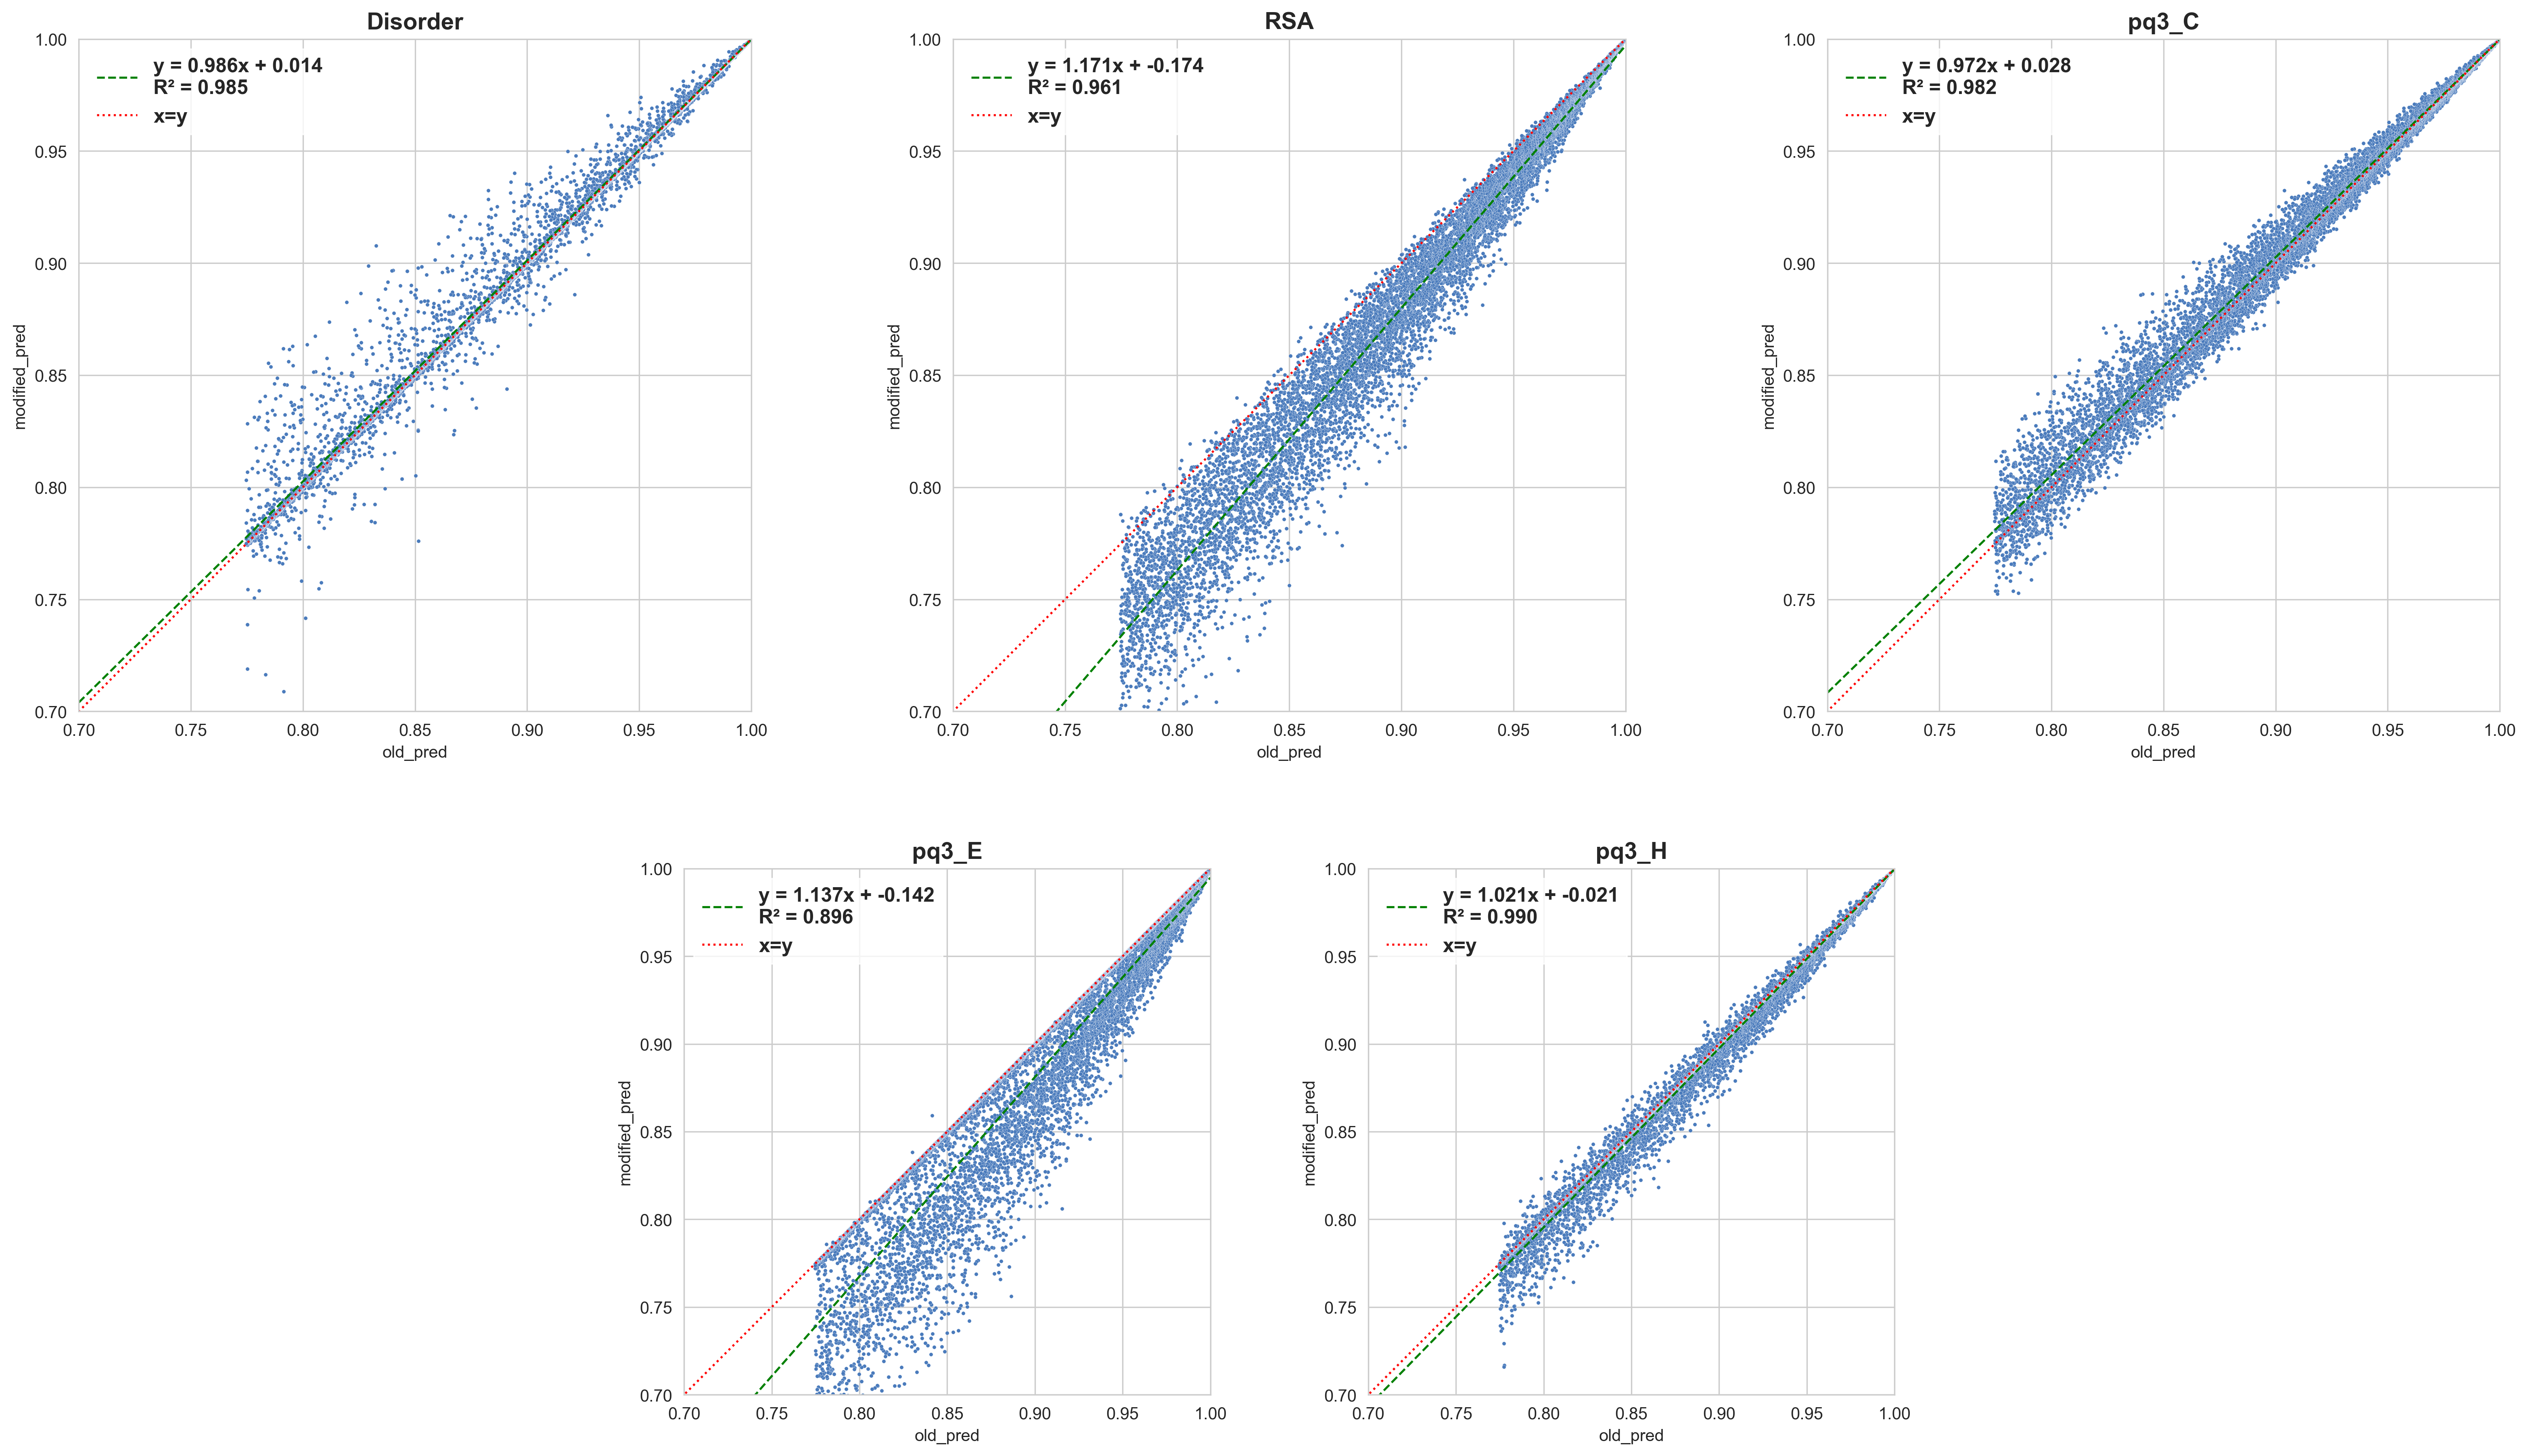

In [697]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create the figure
fig = plt.figure(figsize=(25, 25))

# Define GridSpec for the top row (3 subplots)
gs_top = gridspec.GridSpec(nrows=1, ncols=3, left=0.1, right=0.9, top=0.95, bottom=0.55, wspace=0.3)

# Define GridSpec for the bottom row (2 subplots, centred)
gs_bottom = gridspec.GridSpec(nrows=1, ncols=2, left=0.3, right=0.7, top=0.85, bottom=0.15, wspace=0.3)

# Create subplots for the top row
axes_top = [fig.add_subplot(gs_top[i]) for i in range(3)]
# Create subplots for the bottom row
axes_bottom = [fig.add_subplot(gs_bottom[i]) for i in range(2)]

# (Optional) For demonstration, plot a simple example on each subplot:
for ax, df, title in zip(axes_top + axes_bottom,
                         [mod_disorder, mod_rsa, mod_pq3_c, mod_pq3_e, mod_pq3_h],
                         ['Disorder', 'RSA', 'pq3_C', 'pq3_E', 'pq3_H']):

    # ax.plot([0, 1], [0, 1])
    ax.set_aspect('equal')
    make_scatter_reg(df, s=5, lw=1.25, markers='o',
                     ax=ax, title=title)

fig.tight_layout()